# Machine Learning Final Project
## 太平山莊訂房網驗證碼辨識
### 106030012 廖昱瑋 工院21

## <font color="#0000dd">題目描述</font>
訓練一個可以辨識[太平山莊訂房網站](https://tpsr.forest.gov.tw/TPSOrder/wSite/index.do?action=indexPage)入口驗證碼的model，此網站驗證碼為輸入圖片中英文數字。  
因為曾經搶房沒搶到，想要寫一個可以自動搶房的程式，但訂房網首頁就需要輸入驗證碼，在這學期學了機器學習後，便可以利用其解決驗證碼辨識的問題。

---

## <font color="#0000dd">摘要</font>
1. 圖片有先預處理再丟進model進行訓練
2. 此驗證碼識別為圖形識別，所以選用較適合圖形識別的CNN架構
3. 驗證碼中每個字元當作獨自label
4. 這次建立了3個CNN model，first_model為一開始train的model，second_model及third_model為嘗試改良first_model後的結果
5. 最後test accuracy  


model　　　|first_model | second_model |  third_model
------------ |----------- | ------------ | ------
test accuracy|67.63%      | 27.00%       | 85.58%

## <font color="#0000dd">主要流程</font>
1. 利用網路爬蟲進入網站並擷取驗證碼圖片儲存
2. 手動進行label
3. 觀察驗證碼圖片pattern並做圖片預處理
4. 將圖檔轉成np array，作為features及labels
5. 建立CNN model並訓練model
6. 觀察model訓練情形及predict accuracy，並進行優化改善
---

## <font color="#0000dd">Dataset</font>
* 剛從網站抓下來未label圖檔存在`"./data/raw_data/"`資料夾中
* 手動label完圖檔存在`"./data/label_data/"`資料夾中
* 圖片預處理完圖檔存在`"./data/gray_data/"`資料夾中

### 抓取驗證碼圖檔
利用網路爬蟲及selenium套件截圖，不斷抓取網站上的驗證碼，並儲存到`"./data/raw_data/"`資料夾中，檔名則命名為編號`1~5000.png`

In [3]:
from PIL import Image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

In [ ]:
options = Options()
options.add_experimental_option("excludeSwitches", ["disable-popup-blocking"])

for i in range(1,5001):
    chrome = webdriver.Chrome('./chromedriver', options=options)
    chrome.maximize_window()
    chrome.get("https://tpsr.forest.gov.tw/TPSOrder/wSite/index.do?action=indexPage#")

    #關閉彈出視窗
    popout = chrome.find_element_by_xpath('(//a[img/@src="css_zh/images/del.png"])[2]')
    while(popout.is_displayed() == False):
        pass
    popout.click()

    chrome.save_screenshot('./data/raw_data/' + str(i)+ '.png')
    imgelement = chrome.find_element_by_id('captchaImg')
    location = imgelement.location
    size = imgelement.size
    
    image = Image.open("./data/raw_data/" + str(i) + ".png")

    screensize = (chrome.execute_script("return document.body.clientWidth"),
                  chrome.execute_script("return window.innerHeight"))
    image = image.resize(screensize)

    img_location = (int(location['x'])-6, int(location['y']), int(location['x'] + size['width'])-6,
                    int(location['y'] + size['height']))
    image = image.crop(img_location)
    image.save("./data/raw_data/" + str(i) + ".png")

    chrome.quit()

### 手動label
將照片檔名手動改成圖片中驗證碼，手動進行label，並存到`'./data/label_data/'`資料夾中  
雖然上面做網路爬蟲時，爬了5000筆資料，但手動label非常耗時，所以我只有label 1500個資料就去train model了，接著便會以這1500筆資料做資料預處理及建dataset  
以下code只輸入2筆為展示用

1


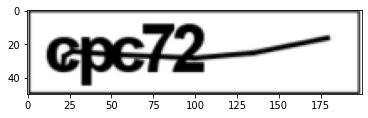

cpc72
2


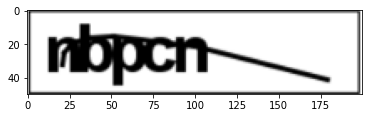

nbpcn
Image mode: RGBA
New image size: ( 50 200 )


<Figure size 432x288 with 0 Axes>

In [5]:
for i in range(1,3): 
    print(i)
    im = Image.open('./data/raw_data/'+str(i)+'.png') 
    plt.imshow(im)
    plt.show()
    file_name = input()
    im.save('./data/label_data/'+file_name+'.png')
    plt.clf()
print("Image mode:", im.mode)
w, h = im.size        
print("New image size: (", h, w, ")")

### 圖片預處理
在驗證碼識別中，圖片預處理及降噪蠻重要的，對之後model train出來的表現影響很大，所以我先觀察圖片pattern，及做以下處理  
  
由上面的圖片及key完1500筆資料後可以觀察出幾個資訊：
1. 每張圖驗證碼皆為5碼
2. 圖片格式為RGBA，但肉眼看起來只有黑白兩色
3. 圖片size為50*200
4. 英文只有小寫，並非36個英數字都有使用到，共只有使用到23種
5. 圖片有邊框及一條左右幾乎貫穿全圖的干擾線，但沒有干擾點
6. 字元集中在左側，右側有一部分沒字元
7. 字型都差不多，並且字體沒有翻轉、傾斜
8. 每個字元所在位置並不固定，且有些字體會相連
  
綜合以上結論，為了有較佳的training效果，需要先對圖片做以下預處理，使得圖片變得更乾淨、容易辨識：
1. RGBA轉灰階: 雖然圖檔看起來是黑白，但它背後的格式為RGBA，首先必須先將圖檔轉為真正的灰階
2. 二值化： 雖然肉眼看起來圖片只有黑與白，但轉為灰階後仔細觀察圖檔pixel會發現有少數pixel非全黑或全白，所以我設了一個thershold值177，使每個pixel值都為0或255。因為照片並非彩色，所以做二值化並不會破壞原本的字元。
3. 去除邊框： 去圖上下左右的邊框線，以免影響model識別
4. 去除干擾線： 以線降噪原理，試圖將干擾線去除
5. 裁減掉右邊多餘部分： 將圖片右半邊沒有字元部分裁減掉，裁剪後圖片大小為50 * 145
  
<center>線降噪原理：以一點為中心，檢查附近8個點是否為黑色，若小於4個為黑色，則將該點變為白色<center/>
<img src="./report_pic/線降噪原理.jpg"  width="300" height="230">

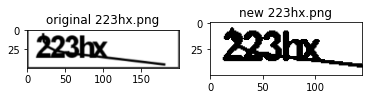

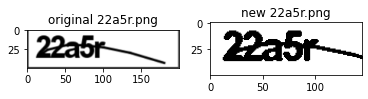

New image size: ( 50 145 )


In [6]:
files = os.listdir('./data/label_data/')
i = 0
for im_name in files:
    im = cv2.imread('./data/label_data/' + im_name)
    #轉灰階
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #二值化
    ret, th1 = cv2.threshold(im, 177, 255, cv2.THRESH_BINARY);
    cv2.imwrite('./data/gray_data/'+ im_name, th1)
    
    #去除邊框
    im = Image.open('./data/gray_data/'+im_name)
    width, height = im.size
    pixels = im.load()
    for x in range(0, width):
        for y in range(0, height):
            if x < 5 or x > width - 10:
                pixels[x, y] = 255
            if y < 2 or y > height -2:
                pixels[x, y] = 255
    
    #去除干擾線
    for iteration in range(0,2):
        for x in range(1, width - 1):
            for y in range(1, height - 1):            
                count = 0
                if pixels[x, y - 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x, y + 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x - 1, y] == pixels[x, y]:
                    count = count + 1
                if pixels[x + 1, y] == pixels[x, y]:
                    count = count + 1
                if pixels[x - 1, y - 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x - 1, y + 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x + 1, y - 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x + 1, y + 1] == pixels[x, y]:
                    count = count + 1
                if count <= 3 and count > 0:
                    pixels[x, y] = 255
    
    #切掉右邊沒數字部分
    crop_img = im.crop((0, 0, 145, height))
    crop_img.save('./data/gray_data/'+im_name)
    
    #print前2組圖片看效果
    if (i < 2):
        im = Image.open('./data/label_data/' + im_name)
        plt.subplot(3, 2, 2*i+1)
        plt.imshow(im)
        plt.title('original ' + im_name)

        im = Image.open('./data/gray_data/'+ im_name)
        plt.subplot(3, 2, 2*i+2)
        plt.imshow(im, cmap='gray', vmin=0, vmax=255)
        plt.title('new ' +im_name)
        plt.show()
        i += 1

w, h = crop_img.size        
print("New image size: (", h, w, ")")

由上圖可知去除干擾線效果不好，原因可能為干擾線太粗，因此改為附近8個點若小於5個為黑色，則將該點變為白色  

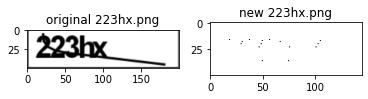

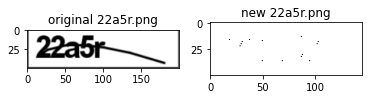

New image size: ( 50 145 )


In [7]:
files = os.listdir('./data/label_data/')
i = 0
for im_name in files:
    im = cv2.imread('./data/label_data/' + im_name)
    #轉灰階
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #二值化
    ret, th1 = cv2.threshold(im, 177, 255, cv2.THRESH_BINARY);
    cv2.imwrite('./data/gray_data/'+ im_name, th1)
    
    #去除邊框
    im = Image.open('./data/gray_data/'+im_name)
    width, height = im.size
    pixels = im.load()
    for x in range(0, width):
        for y in range(0, height):
            if x < 5 or x > width - 10:
                pixels[x, y] = 255
            if y < 2 or y > height -2:
                pixels[x, y] = 255
    
    #去除干擾線
    for iteration in range(0,1):
        for x in range(1, width - 1):
            for y in range(1, height - 1):            
                count = 0
                if pixels[x, y - 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x, y + 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x - 1, y] == pixels[x, y]:
                    count = count + 1
                if pixels[x + 1, y] == pixels[x, y]:
                    count = count + 1
                if pixels[x - 1, y - 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x - 1, y + 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x + 1, y - 1] == pixels[x, y]:
                    count = count + 1
                if pixels[x + 1, y + 1] == pixels[x, y]:
                    count = count + 1
                if count <= 4 and count > 0:
                    pixels[x, y] = 255
    
    #切掉右邊沒數字部分
    crop_img = im.crop((0, 0, 145, height))
    crop_img.save('./data/gray_data/'+im_name)
    
    #print前2組圖片看效果
    if (i < 2):
        im = Image.open('./data/label_data/' + im_name)
        plt.subplot(3, 2, 2*i+1)
        plt.imshow(im)
        plt.title('original ' + im_name)

        im = Image.open('./data/gray_data/'+ im_name)
        plt.subplot(3, 2, 2*i+2)
        plt.imshow(im, cmap='gray', vmin=0, vmax=255)
        plt.title('new ' +im_name)
        plt.show()
        i += 1

w, h = crop_img.size        
print("New image size: (", h, w, ")")

從上圖可已看到降噪強度高到已經把字母都去除了，所以最後還是決定不做去除干擾線的部分  
以下是把上面的code重跑一遍，但沒有去除干擾線的部分

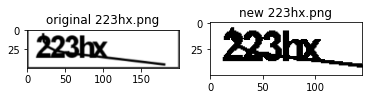

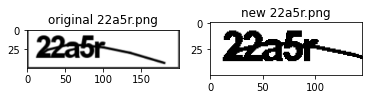

New image size: ( 50 145 )


In [8]:
files = os.listdir('./data/label_data/')
i = 0
for im_name in files:
    im = cv2.imread('./data/label_data/' + im_name)
    #轉灰階
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #二值化
    ret, th1 = cv2.threshold(im, 177, 255, cv2.THRESH_BINARY);
    cv2.imwrite('./data/gray_data/'+ im_name, th1)
    
    #去除邊框
    im = Image.open('./data/gray_data/'+im_name)
    width, height = im.size
    pixels = im.load()
    for x in range(0, width):
        for y in range(0, height):
            if x < 5 or x > width - 10:
                pixels[x, y] = 255
            if y < 2 or y > height -2:
                pixels[x, y] = 255
    
    #切掉右邊沒數字部分
    crop_img = im.crop((0, 0, 145, height))
    crop_img.save('./data/gray_data/'+im_name)
    
    #print前2組圖片看效果
    if (i < 2):
        im = Image.open('./data/label_data/' + im_name)
        plt.subplot(3, 2, 2*i+1)
        plt.imshow(im)
        plt.title('original ' + im_name)

        im = Image.open('./data/gray_data/'+ im_name)
        plt.subplot(3, 2, 2*i+2)
        plt.imshow(im, cmap='gray', vmin=0, vmax=255)
        plt.title('new ' +im_name)
        plt.show()
        i += 1

w, h = crop_img.size        
print("New image size: (", h, w, ")")

<center>共1500筆資料，沒有label重複的資料<center/>
<img src="./report_pic/data_1500.png"  width="600" height="460">

### 建立Dataset
圖片都預處理完後，便可將圖檔轉為np array，變成可以丟進model裡的features及labels  
將圖片裡的每個字元視為單獨的label，所以每張圖會有5個labels，並用onehot encode方式轉換原本的字元
首先先建立一個toonehot function以利後續做label onehot轉換，驗證碼裡只有出現23種英數字，它們為`2345678abcdefghkmnprwxy`

In [256]:
LETTERSTR = "2345678abcdefghkmnprwxy"
def toonehot(text):
    labellist = []
    for letter in text:
        onehot = np.zeros(23, dtype=float)
        num = LETTERSTR.find(letter)
        onehot[num] = 1.0
    return onehot

先將所有照片的pixel值存到X，onehot後的檔名存到Y，此時
* X size: $1500筆data \times 50 height \times 135 width \times 1 rgb$
* Y size: $1500筆data \times 5個digits \times 23 onehot  $

接著將X、Y隨機分成training及test data，因為資料量只有1500筆，對深度學習來說有點太少，所以只取20%(300筆)data為test data，而另外80%(1200筆)資料為train data  
為了能夠跟model predict每筆資料出來的5個labels做比對，所以再將Y_train、Y_test分別照五個digit分開存成獨立array

In [305]:
files = os.listdir('./data/gray_data/')
X = np.empty((0,50,145,1), int)
Y = np.empty((0,5,23), int)
for im_name in files:
    cur_features = np.asarray(Image.open('./data/gray_data/' + im_name))
    cur_features = np.reshape(cur_features, (50, 145, 1))
    cur_features = (cur_features.astype(np.float32))/255
    X = np.vstack([X, [cur_features]])
    
    labels = im_name.split(".")[0]
    cur_labels = np.empty((0,23), int)
    for i in range(5):
        label = toonehot(labels[i])
        cur_labels = np.append(cur_labels, [label], axis=0)
    Y = np.append(Y, [cur_labels], axis=0)

print("Original X shape:", X.shape)
print("Original Y shape:", Y.shape,"\n")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print("X_train shape:", X_train.shape)
print("Y_train shape:",  Y_train.shape)
print("X_test shape:",  X_test.shape)
print("Y_test shape:", Y_test.shape, "\n")

Y_train_1 = Y_train[:,0,:]
Y_train_2 = Y_train[:,1,:]
Y_train_3 = Y_train[:,2,:]
Y_train_4 = Y_train[:,3,:]
Y_train_5 = Y_train[:,4,:]

Y_test_1 = Y_test[:,0,:]
Y_test_2 = Y_test[:,1,:]
Y_test_3 = Y_test[:,2,:]
Y_test_4 = Y_test[:,3,:]
Y_test_5 = Y_test[:,4,:]

print("Y_train_1 shape:",  Y_train_1.shape)
print("Y_test_1 shape:",  Y_test_1.shape)

Original X shape: (2600, 50, 145, 1)
Original Y shape: (2600, 5, 23) 

X_train shape: (2080, 50, 145, 1)
Y_train shape: (2080, 5, 23)
X_test shape: (520, 50, 145, 1)
Y_test shape: (520, 5, 23) 

Y_train_1 shape: (2080, 23)
Y_test_1 shape: (520, 23)


此時data已經準備好，可以開始建立model及訓練了

---

## <font color="#0000dd">建立first_model</font>
因為文獻顯示，在圖形識別上CNN有著不錯的效果，所以我決定使用tensorflow keras建立CNN model  
我參考了JasonLiTW所做過的[臺鐵驗證碼CNN辨識器](https://github.com/JasonLiTW/simple-railway-captcha-solver)並加以客製化更改至符合我的需求  
因為這個model必須要有5個output，所以無法使用tf.keras.Sequential，我便一行一行獨立建立layer  
著個model主要部分為7層Conv2D layer，並每兩層做一次BatchNormalization、MaxPooling及Dropout  
* Conv2D: 因為input shape($50\times145$)偏大，並且最後又有5個output分別都為fully connected layer，可以預期的是需要train的weight會很多，為了避免運算量太大，kernel_size都設$3\times3$。而filter數由32開始，每兩層變多兩倍，越後面layer filter數越多原因為到越深圖片看得越全面，希望提升filter數可以同時看的全面也看的細節一點
* Maxpooling : 減少運算的資料量，並且將outlier去除
* Dropout : 使用的機率為0.3，用以減少運算量
* BatchNorm2d : 減少資料的variance與bias，加快 model訓練時converge
* flatten : 將資料變成一維，方便以fully connected連接到output layer
* output layer : 每個output layer個別有著softmax用作從CNN layers提取出來的features做運算與預測，五個output layer分別對應captcha的一個字元

In [260]:
#input layer
inputs = tf.keras.layers.Input(shape=(50,145,1))
outputs = inputs

#第一層Conv2D
outputs = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv_1')(outputs)

#第二層Conv2D
outputs = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv_2')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)

#第三層Conv2D
outputs = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv_3')(outputs)

#第四層Conv2D
outputs = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv_4')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)

#第五層Conv2D
out = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv_5')(outputs)

#第六層Conv2D
outputs = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv_6')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)

#第七層Conv2D
outputs = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv_7')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Flatten()(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)

#output layer
outputs = [tf.keras.layers.Dense(23, name='digit1', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit2', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit3', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit4', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit5', activation='softmax')(outputs)]

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 50, 145, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 50, 145, 32)  320         input_17[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 50, 145, 32)  9248        conv_1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 50, 145, 32)  128         conv_2[0][0]                     
___________________________________________________________________________________________

從上表可以看出需要train的weight有1,229,971個

### Train first_model
將training dataset丟進model做training，分20%training data為validation，batch_size設為32，並做500次epochs  
epoch值及batch_size為先隨機設的值，先將epoch設多一點，之後看learning curve和結果後再做調整

In [261]:
history = model.fit(X_train, (Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5), 
                    shuffle=True, epochs=500, 
                    batch_size = 32, validation_split=0.2, 
                    verbose=1)

Train on 960 samples, validate on 240 samples
Epoch 1/500
960/960 [==============================] - 7s 7ms/sample - loss: 29.0398 - digit1_loss: 5.8854 - digit2_loss: 5.9522 - digit3_loss: 5.7272 - digit4_loss: 5.6349 - digit5_loss: 5.8401 - digit1_accuracy: 0.0771 - digit2_accuracy: 0.0594 - digit3_accuracy: 0.0812 - digit4_accuracy: 0.0708 - digit5_accuracy: 0.0635 - val_loss: 19.1702 - val_digit1_loss: 4.3668 - val_digit2_loss: 3.7971 - val_digit3_loss: 3.6467 - val_digit4_loss: 3.4614 - val_digit5_loss: 3.8767 - val_digit1_accuracy: 0.0417 - val_digit2_accuracy: 0.0417 - val_digit3_accuracy: 0.0583 - val_digit4_accuracy: 0.0542 - val_digit5_accuracy: 0.0292
Epoch 2/500
960/960 [==============================] - 2s 2ms/sample - loss: 17.7877 - digit1_loss: 2.9330 - digit2_loss: 3.4573 - digit3_loss: 3.7495 - digit4_loss: 3.8191 - digit5_loss: 3.8288 - digit1_accuracy: 0.2677 - digit2_accuracy: 0.1937 - digit3_accuracy: 0.1531 - digit4_accuracy: 0.1635 - digit5_accuracy: 0.1510 - va

960/960 [==============================] - 2s 2ms/sample - loss: 0.1705 - digit1_loss: 0.0072 - digit2_loss: 0.0247 - digit3_loss: 0.0476 - digit4_loss: 0.0674 - digit5_loss: 0.0235 - digit1_accuracy: 0.9990 - digit2_accuracy: 0.9917 - digit3_accuracy: 0.9854 - digit4_accuracy: 0.9760 - digit5_accuracy: 0.9937 - val_loss: 3.5697 - val_digit1_loss: 0.0436 - val_digit2_loss: 0.4433 - val_digit3_loss: 0.9019 - val_digit4_loss: 1.3645 - val_digit5_loss: 0.7562 - val_digit1_accuracy: 0.9875 - val_digit2_accuracy: 0.8875 - val_digit3_accuracy: 0.7833 - val_digit4_accuracy: 0.7458 - val_digit5_accuracy: 0.8417
Epoch 28/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.1969 - digit1_loss: 0.0073 - digit2_loss: 0.0268 - digit3_loss: 0.0421 - digit4_loss: 0.0809 - digit5_loss: 0.0398 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9917 - digit3_accuracy: 0.9823 - digit4_accuracy: 0.9698 - digit5_accuracy: 0.9854 - val_loss: 3.7538 - val_digit1_loss: 0.0580 - val_digit2_loss: 

960/960 [==============================] - 2s 2ms/sample - loss: 0.1747 - digit1_loss: 0.0119 - digit2_loss: 0.0269 - digit3_loss: 0.0383 - digit4_loss: 0.0731 - digit5_loss: 0.0246 - digit1_accuracy: 0.9948 - digit2_accuracy: 0.9896 - digit3_accuracy: 0.9823 - digit4_accuracy: 0.9750 - digit5_accuracy: 0.9927 - val_loss: 5.4090 - val_digit1_loss: 0.1795 - val_digit2_loss: 0.6530 - val_digit3_loss: 1.5736 - val_digit4_loss: 2.1946 - val_digit5_loss: 0.8059 - val_digit1_accuracy: 0.9750 - val_digit2_accuracy: 0.8875 - val_digit3_accuracy: 0.7542 - val_digit4_accuracy: 0.7083 - val_digit5_accuracy: 0.8500
Epoch 54/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.1474 - digit1_loss: 0.0092 - digit2_loss: 0.0267 - digit3_loss: 0.0394 - digit4_loss: 0.0363 - digit5_loss: 0.0358 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9937 - digit3_accuracy: 0.9865 - digit4_accuracy: 0.9885 - digit5_accuracy: 0.9875 - val_loss: 4.7962 - val_digit1_loss: 0.1636 - val_digit2_loss: 

960/960 [==============================] - 2s 2ms/sample - loss: 0.1268 - digit1_loss: 0.0170 - digit2_loss: 0.0256 - digit3_loss: 0.0258 - digit4_loss: 0.0347 - digit5_loss: 0.0237 - digit1_accuracy: 0.9948 - digit2_accuracy: 0.9937 - digit3_accuracy: 0.9927 - digit4_accuracy: 0.9917 - digit5_accuracy: 0.9917 - val_loss: 5.7670 - val_digit1_loss: 0.0918 - val_digit2_loss: 0.9256 - val_digit3_loss: 1.8027 - val_digit4_loss: 2.2788 - val_digit5_loss: 0.7977 - val_digit1_accuracy: 0.9667 - val_digit2_accuracy: 0.8708 - val_digit3_accuracy: 0.8042 - val_digit4_accuracy: 0.7500 - val_digit5_accuracy: 0.8750
Epoch 80/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.1944 - digit1_loss: 0.0265 - digit2_loss: 0.0069 - digit3_loss: 0.0405 - digit4_loss: 0.0573 - digit5_loss: 0.0632 - digit1_accuracy: 0.9906 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9885 - digit4_accuracy: 0.9875 - digit5_accuracy: 0.9854 - val_loss: 5.8556 - val_digit1_loss: 0.2783 - val_digit2_loss: 

960/960 [==============================] - 2s 2ms/sample - loss: 0.0996 - digit1_loss: 0.0133 - digit2_loss: 0.0153 - digit3_loss: 0.0025 - digit4_loss: 0.0257 - digit5_loss: 0.0427 - digit1_accuracy: 0.9969 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9927 - digit5_accuracy: 0.9885 - val_loss: 6.4963 - val_digit1_loss: 0.0256 - val_digit2_loss: 1.0756 - val_digit3_loss: 2.0952 - val_digit4_loss: 2.4612 - val_digit5_loss: 0.9484 - val_digit1_accuracy: 0.9917 - val_digit2_accuracy: 0.9000 - val_digit3_accuracy: 0.8333 - val_digit4_accuracy: 0.8083 - val_digit5_accuracy: 0.8667
Epoch 106/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0594 - digit1_loss: 0.0081 - digit2_loss: 0.0065 - digit3_loss: 0.0088 - digit4_loss: 0.0085 - digit5_loss: 0.0275 - digit1_accuracy: 0.9969 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9958 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9896 - val_loss: 6.7226 - val_digit1_loss: 0.1308 - val_digit2_loss:

960/960 [==============================] - 2s 2ms/sample - loss: 0.0733 - digit1_loss: 4.5338e-04 - digit2_loss: 7.3752e-04 - digit3_loss: 0.0410 - digit4_loss: 0.0104 - digit5_loss: 0.0207 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9896 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9958 - val_loss: 6.7984 - val_digit1_loss: 0.0190 - val_digit2_loss: 0.9489 - val_digit3_loss: 1.7623 - val_digit4_loss: 2.9061 - val_digit5_loss: 1.1155 - val_digit1_accuracy: 0.9917 - val_digit2_accuracy: 0.9000 - val_digit3_accuracy: 0.8417 - val_digit4_accuracy: 0.7792 - val_digit5_accuracy: 0.9125
Epoch 132/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0323 - digit1_loss: 3.6871e-04 - digit2_loss: 2.8694e-04 - digit3_loss: 0.0155 - digit4_loss: 0.0099 - digit5_loss: 0.0062 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9969 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9969 - val_loss: 8.7174 - val_digit1_loss: 0.0992 - 

960/960 [==============================] - 2s 2ms/sample - loss: 0.0413 - digit1_loss: 6.5201e-04 - digit2_loss: 0.0016 - digit3_loss: 0.0118 - digit4_loss: 0.0173 - digit5_loss: 0.0100 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9969 - digit4_accuracy: 0.9958 - digit5_accuracy: 0.9979 - val_loss: 6.7391 - val_digit1_loss: 0.1490 - val_digit2_loss: 1.0415 - val_digit3_loss: 1.4176 - val_digit4_loss: 3.2446 - val_digit5_loss: 0.8881 - val_digit1_accuracy: 0.9833 - val_digit2_accuracy: 0.9042 - val_digit3_accuracy: 0.8750 - val_digit4_accuracy: 0.7958 - val_digit5_accuracy: 0.9292
Epoch 158/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.1034 - digit1_loss: 0.0134 - digit2_loss: 0.0259 - digit3_loss: 0.0194 - digit4_loss: 0.0432 - digit5_loss: 0.0015 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9958 - digit3_accuracy: 0.9937 - digit4_accuracy: 0.9917 - digit5_accuracy: 0.9990 - val_loss: 7.4566 - val_digit1_loss: 0.1231 - val_digit2_l

960/960 [==============================] - 2s 2ms/sample - loss: 0.0943 - digit1_loss: 0.0014 - digit2_loss: 0.0242 - digit3_loss: 0.0526 - digit4_loss: 0.0088 - digit5_loss: 0.0072 - digit1_accuracy: 0.9990 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9948 - digit4_accuracy: 0.9958 - digit5_accuracy: 0.9990 - val_loss: 8.7562 - val_digit1_loss: 0.2179 - val_digit2_loss: 1.3368 - val_digit3_loss: 2.3808 - val_digit4_loss: 3.9040 - val_digit5_loss: 1.1147 - val_digit1_accuracy: 0.9875 - val_digit2_accuracy: 0.9125 - val_digit3_accuracy: 0.8333 - val_digit4_accuracy: 0.7875 - val_digit5_accuracy: 0.9167
Epoch 184/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0782 - digit1_loss: 2.2810e-04 - digit2_loss: 0.0282 - digit3_loss: 0.0244 - digit4_loss: 0.0245 - digit5_loss: 8.4255e-04 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9958 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9958 - digit5_accuracy: 1.0000 - val_loss: 9.2367 - val_digit1_loss: 0.2928 - val_digi

960/960 [==============================] - 2s 2ms/sample - loss: 0.0939 - digit1_loss: 0.0084 - digit2_loss: 0.0139 - digit3_loss: 0.0148 - digit4_loss: 0.0185 - digit5_loss: 0.0383 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9937 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9906 - val_loss: 9.5125 - val_digit1_loss: 0.2488 - val_digit2_loss: 1.5147 - val_digit3_loss: 1.7612 - val_digit4_loss: 4.1261 - val_digit5_loss: 1.9316 - val_digit1_accuracy: 0.9792 - val_digit2_accuracy: 0.9167 - val_digit3_accuracy: 0.8583 - val_digit4_accuracy: 0.7792 - val_digit5_accuracy: 0.8750
Epoch 210/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0558 - digit1_loss: 5.3381e-04 - digit2_loss: 0.0065 - digit3_loss: 0.0124 - digit4_loss: 0.0194 - digit5_loss: 0.0169 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9969 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9958 - val_loss: 9.1947 - val_digit1_loss: 0.3776 - val_digit2_l

960/960 [==============================] - 2s 2ms/sample - loss: 0.0631 - digit1_loss: 1.3676e-05 - digit2_loss: 0.0183 - digit3_loss: 0.0170 - digit4_loss: 0.0277 - digit5_loss: 1.1717e-04 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9948 - digit5_accuracy: 1.0000 - val_loss: 9.6649 - val_digit1_loss: 0.2563 - val_digit2_loss: 1.2912 - val_digit3_loss: 2.5813 - val_digit4_loss: 4.3166 - val_digit5_loss: 1.4700 - val_digit1_accuracy: 0.9667 - val_digit2_accuracy: 0.9208 - val_digit3_accuracy: 0.8375 - val_digit4_accuracy: 0.8208 - val_digit5_accuracy: 0.9167
Epoch 236/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0192 - digit1_loss: 7.7084e-06 - digit2_loss: 0.0020 - digit3_loss: 0.0061 - digit4_loss: 0.0096 - digit5_loss: 0.0016 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9948 - digit5_accuracy: 0.9990 - val_loss: 9.9110 - val_digit1_loss: 0.5058 - val_

960/960 [==============================] - 2s 2ms/sample - loss: 0.0485 - digit1_loss: 6.6539e-05 - digit2_loss: 0.0180 - digit3_loss: 0.0119 - digit4_loss: 0.0163 - digit5_loss: 0.0023 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9979 - val_loss: 8.9162 - val_digit1_loss: 0.1196 - val_digit2_loss: 1.1370 - val_digit3_loss: 2.6203 - val_digit4_loss: 4.0498 - val_digit5_loss: 1.0931 - val_digit1_accuracy: 0.9833 - val_digit2_accuracy: 0.9208 - val_digit3_accuracy: 0.8458 - val_digit4_accuracy: 0.8125 - val_digit5_accuracy: 0.9333
Epoch 262/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0332 - digit1_loss: 9.9841e-04 - digit2_loss: 0.0011 - digit3_loss: 0.0053 - digit4_loss: 0.0123 - digit5_loss: 0.0135 - digit1_accuracy: 0.9990 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9969 - val_loss: 8.6206 - val_digit1_loss: 0.1131 - val_digi

960/960 [==============================] - 2s 2ms/sample - loss: 0.0301 - digit1_loss: 0.0044 - digit2_loss: 5.9732e-06 - digit3_loss: 0.0102 - digit4_loss: 0.0107 - digit5_loss: 0.0048 - digit1_accuracy: 0.9979 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9958 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9979 - val_loss: 7.6469 - val_digit1_loss: 0.0553 - val_digit2_loss: 1.2164 - val_digit3_loss: 1.8179 - val_digit4_loss: 3.5158 - val_digit5_loss: 1.0054 - val_digit1_accuracy: 0.9875 - val_digit2_accuracy: 0.9125 - val_digit3_accuracy: 0.8625 - val_digit4_accuracy: 0.8167 - val_digit5_accuracy: 0.9375
Epoch 275/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0488 - digit1_loss: 4.9698e-05 - digit2_loss: 4.7965e-04 - digit3_loss: 0.0161 - digit4_loss: 0.0309 - digit5_loss: 0.0013 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9969 - digit4_accuracy: 0.9958 - digit5_accuracy: 0.9990 - val_loss: 8.1448 - val_digit1_loss: 0.0736 - val_

960/960 [==============================] - 2s 2ms/sample - loss: 0.0288 - digit1_loss: 1.4895e-04 - digit2_loss: 3.8213e-04 - digit3_loss: 0.0048 - digit4_loss: 0.0033 - digit5_loss: 0.0202 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9958 - val_loss: 8.8693 - val_digit1_loss: 0.2701 - val_digit2_loss: 1.4216 - val_digit3_loss: 1.8798 - val_digit4_loss: 3.8256 - val_digit5_loss: 1.5546 - val_digit1_accuracy: 0.9750 - val_digit2_accuracy: 0.9167 - val_digit3_accuracy: 0.8375 - val_digit4_accuracy: 0.8083 - val_digit5_accuracy: 0.8875
Epoch 301/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0933 - digit1_loss: 0.0108 - digit2_loss: 0.0275 - digit3_loss: 0.0263 - digit4_loss: 7.1435e-04 - digit5_loss: 0.0280 - digit1_accuracy: 0.9990 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9969 - digit4_accuracy: 1.0000 - digit5_accuracy: 0.9969 - val_loss: 9.2271 - val_digit1_loss: 0.4233 - val_

960/960 [==============================] - 2s 2ms/sample - loss: 0.0755 - digit1_loss: 3.4342e-06 - digit2_loss: 1.3755e-04 - digit3_loss: 0.0240 - digit4_loss: 0.0397 - digit5_loss: 0.0116 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9937 - digit4_accuracy: 0.9906 - digit5_accuracy: 0.9958 - val_loss: 8.6486 - val_digit1_loss: 0.0870 - val_digit2_loss: 1.2329 - val_digit3_loss: 1.7062 - val_digit4_loss: 4.2097 - val_digit5_loss: 1.5921 - val_digit1_accuracy: 0.9833 - val_digit2_accuracy: 0.9125 - val_digit3_accuracy: 0.8500 - val_digit4_accuracy: 0.8125 - val_digit5_accuracy: 0.8875
Epoch 314/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0551 - digit1_loss: 3.0582e-05 - digit2_loss: 0.0074 - digit3_loss: 0.0221 - digit4_loss: 0.0146 - digit5_loss: 0.0109 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9948 - digit4_accuracy: 0.9958 - digit5_accuracy: 0.9990 - val_loss: 10.1953 - val_digit1_loss: 0.0743 - val

Epoch 339/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0694 - digit1_loss: 0.0234 - digit2_loss: 2.5502e-05 - digit3_loss: 4.5012e-04 - digit4_loss: 0.0240 - digit5_loss: 0.0215 - digit1_accuracy: 0.9979 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9969 - val_loss: 9.5719 - val_digit1_loss: 0.1761 - val_digit2_loss: 1.7085 - val_digit3_loss: 2.0947 - val_digit4_loss: 4.4472 - val_digit5_loss: 1.4181 - val_digit1_accuracy: 0.9792 - val_digit2_accuracy: 0.9167 - val_digit3_accuracy: 0.8750 - val_digit4_accuracy: 0.8208 - val_digit5_accuracy: 0.9125
Epoch 340/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0358 - digit1_loss: 3.8474e-04 - digit2_loss: 2.3370e-06 - digit3_loss: 1.0271e-04 - digit4_loss: 0.0329 - digit5_loss: 0.0024 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9927 - digit5_accuracy: 0.9990 - val_loss: 9.3469 - val_digi

Epoch 352/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0358 - digit1_loss: 7.5538e-05 - digit2_loss: 0.0062 - digit3_loss: 0.0069 - digit4_loss: 0.0109 - digit5_loss: 0.0118 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9969 - val_loss: 10.0121 - val_digit1_loss: 0.1892 - val_digit2_loss: 1.7831 - val_digit3_loss: 1.7526 - val_digit4_loss: 4.9508 - val_digit5_loss: 1.5508 - val_digit1_accuracy: 0.9708 - val_digit2_accuracy: 0.9083 - val_digit3_accuracy: 0.8708 - val_digit4_accuracy: 0.8000 - val_digit5_accuracy: 0.9125
Epoch 353/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0399 - digit1_loss: 0.0018 - digit2_loss: 0.0095 - digit3_loss: 0.0111 - digit4_loss: 0.0130 - digit5_loss: 0.0045 - digit1_accuracy: 0.9990 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9979 - val_loss: 9.6016 - val_digit1_loss: 0.0531

Epoch 365/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0366 - digit1_loss: 3.7893e-06 - digit2_loss: 5.8868e-05 - digit3_loss: 0.0235 - digit4_loss: 0.0090 - digit5_loss: 0.0041 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9958 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9979 - val_loss: 9.5012 - val_digit1_loss: 0.0575 - val_digit2_loss: 1.7536 - val_digit3_loss: 1.7894 - val_digit4_loss: 4.3674 - val_digit5_loss: 1.6439 - val_digit1_accuracy: 0.9875 - val_digit2_accuracy: 0.8958 - val_digit3_accuracy: 0.8500 - val_digit4_accuracy: 0.8333 - val_digit5_accuracy: 0.9167
Epoch 366/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0246 - digit1_loss: 5.3134e-04 - digit2_loss: 2.7252e-05 - digit3_loss: 1.6978e-04 - digit4_loss: 0.0123 - digit5_loss: 0.0115 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9948 - digit5_accuracy: 0.9979 - val_loss: 10.0839 - val_dig

Epoch 378/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0359 - digit1_loss: 0.0014 - digit2_loss: 0.0141 - digit3_loss: 0.0011 - digit4_loss: 0.0162 - digit5_loss: 0.0031 - digit1_accuracy: 0.9990 - digit2_accuracy: 0.9990 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9990 - val_loss: 10.9554 - val_digit1_loss: 0.4018 - val_digit2_loss: 1.9692 - val_digit3_loss: 1.7304 - val_digit4_loss: 4.3614 - val_digit5_loss: 2.6604 - val_digit1_accuracy: 0.9708 - val_digit2_accuracy: 0.8958 - val_digit3_accuracy: 0.8375 - val_digit4_accuracy: 0.7708 - val_digit5_accuracy: 0.8417
Epoch 379/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0360 - digit1_loss: 4.4000e-05 - digit2_loss: 0.0099 - digit3_loss: 7.6970e-07 - digit4_loss: 0.0239 - digit5_loss: 0.0021 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9948 - digit5_accuracy: 0.9990 - val_loss: 10.8372 - val_digit1_loss: 0

Epoch 391/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0392 - digit1_loss: 7.3262e-08 - digit2_loss: 0.0248 - digit3_loss: 0.0024 - digit4_loss: 0.0103 - digit5_loss: 0.0017 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9958 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9990 - val_loss: 11.5192 - val_digit1_loss: 0.2954 - val_digit2_loss: 2.1373 - val_digit3_loss: 1.6962 - val_digit4_loss: 4.2511 - val_digit5_loss: 3.1682 - val_digit1_accuracy: 0.9750 - val_digit2_accuracy: 0.8750 - val_digit3_accuracy: 0.8667 - val_digit4_accuracy: 0.7708 - val_digit5_accuracy: 0.7958
Epoch 392/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0868 - digit1_loss: 2.0637e-07 - digit2_loss: 0.0078 - digit3_loss: 0.0455 - digit4_loss: 0.0183 - digit5_loss: 0.0151 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9937 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9979 - val_loss: 9.2352 - val_digit1_loss: 0.

Epoch 404/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0147 - digit1_loss: 0.0030 - digit2_loss: 0.0075 - digit3_loss: 5.4823e-05 - digit4_loss: 0.0040 - digit5_loss: 1.7607e-04 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9990 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9990 - digit5_accuracy: 1.0000 - val_loss: 9.3971 - val_digit1_loss: 0.0477 - val_digit2_loss: 1.7182 - val_digit3_loss: 1.8864 - val_digit4_loss: 4.4063 - val_digit5_loss: 1.5009 - val_digit1_accuracy: 0.9875 - val_digit2_accuracy: 0.9167 - val_digit3_accuracy: 0.9000 - val_digit4_accuracy: 0.8250 - val_digit5_accuracy: 0.9417
Epoch 405/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0297 - digit1_loss: 0.0019 - digit2_loss: 0.0077 - digit3_loss: 4.1077e-06 - digit4_loss: 0.0169 - digit5_loss: 0.0032 - digit1_accuracy: 0.9990 - digit2_accuracy: 0.9990 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9969 - val_loss: 10.5868 - val_digit1_loss

Epoch 417/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0622 - digit1_loss: 0.0140 - digit2_loss: 0.0215 - digit3_loss: 9.5193e-04 - digit4_loss: 0.0256 - digit5_loss: 6.8342e-05 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9948 - digit5_accuracy: 1.0000 - val_loss: 9.8758 - val_digit1_loss: 0.2347 - val_digit2_loss: 1.7831 - val_digit3_loss: 2.0550 - val_digit4_loss: 3.8903 - val_digit5_loss: 1.8692 - val_digit1_accuracy: 0.9750 - val_digit2_accuracy: 0.9042 - val_digit3_accuracy: 0.8833 - val_digit4_accuracy: 0.8583 - val_digit5_accuracy: 0.9208
Epoch 418/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0281 - digit1_loss: 9.2521e-05 - digit2_loss: 0.0149 - digit3_loss: 3.2620e-05 - digit4_loss: 0.0076 - digit5_loss: 0.0054 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9979 - val_loss: 15.4232 - val_digit1_

Epoch 430/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0308 - digit1_loss: 0.0064 - digit2_loss: 1.5488e-04 - digit3_loss: 7.6236e-06 - digit4_loss: 0.0177 - digit5_loss: 0.0065 - digit1_accuracy: 0.9990 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9990 - val_loss: 8.5754 - val_digit1_loss: 0.1132 - val_digit2_loss: 1.7666 - val_digit3_loss: 1.7860 - val_digit4_loss: 3.3803 - val_digit5_loss: 1.5317 - val_digit1_accuracy: 0.9917 - val_digit2_accuracy: 0.9250 - val_digit3_accuracy: 0.8833 - val_digit4_accuracy: 0.8375 - val_digit5_accuracy: 0.9292
Epoch 431/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0121 - digit1_loss: 1.0809e-04 - digit2_loss: 2.4895e-05 - digit3_loss: 0.0020 - digit4_loss: 0.0099 - digit5_loss: 1.1701e-04 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9979 - digit5_accuracy: 1.0000 - val_loss: 8.2888 - val_digi

Epoch 443/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0188 - digit1_loss: 3.7353e-05 - digit2_loss: 0.0012 - digit3_loss: 0.0050 - digit4_loss: 0.0116 - digit5_loss: 9.8325e-04 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9990 - val_loss: 8.8240 - val_digit1_loss: 0.0777 - val_digit2_loss: 1.7063 - val_digit3_loss: 1.7734 - val_digit4_loss: 3.6614 - val_digit5_loss: 1.5442 - val_digit1_accuracy: 0.9917 - val_digit2_accuracy: 0.9083 - val_digit3_accuracy: 0.8792 - val_digit4_accuracy: 0.8250 - val_digit5_accuracy: 0.9375
Epoch 444/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0366 - digit1_loss: 4.5900e-06 - digit2_loss: 9.4169e-05 - digit3_loss: 0.0109 - digit4_loss: 0.0256 - digit5_loss: 6.3846e-06 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9969 - digit5_accuracy: 1.0000 - val_loss: 8.1961 - val_digi

Epoch 456/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0594 - digit1_loss: 0.0023 - digit2_loss: 0.0058 - digit3_loss: 0.0080 - digit4_loss: 0.0142 - digit5_loss: 0.0292 - digit1_accuracy: 0.9990 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9958 - digit5_accuracy: 0.9969 - val_loss: 9.4556 - val_digit1_loss: 0.0540 - val_digit2_loss: 1.6100 - val_digit3_loss: 2.3345 - val_digit4_loss: 3.7252 - val_digit5_loss: 1.7792 - val_digit1_accuracy: 0.9917 - val_digit2_accuracy: 0.9125 - val_digit3_accuracy: 0.8750 - val_digit4_accuracy: 0.8167 - val_digit5_accuracy: 0.9417
Epoch 457/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0446 - digit1_loss: 0.0052 - digit2_loss: 0.0065 - digit3_loss: 0.0307 - digit4_loss: 8.6040e-04 - digit5_loss: 0.0013 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9958 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9990 - val_loss: 10.6205 - val_digit1_loss: 0.2590

Epoch 469/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0296 - digit1_loss: 1.1717e-05 - digit2_loss: 0.0090 - digit3_loss: 0.0020 - digit4_loss: 0.0185 - digit5_loss: 3.9065e-05 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9990 - digit5_accuracy: 1.0000 - val_loss: 10.0541 - val_digit1_loss: 6.2792e-04 - val_digit2_loss: 1.7616 - val_digit3_loss: 2.4604 - val_digit4_loss: 4.3884 - val_digit5_loss: 1.6018 - val_digit1_accuracy: 1.0000 - val_digit2_accuracy: 0.9167 - val_digit3_accuracy: 0.8625 - val_digit4_accuracy: 0.8083 - val_digit5_accuracy: 0.9458
Epoch 470/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0215 - digit1_loss: 2.4835e-10 - digit2_loss: 0.0102 - digit3_loss: 0.0079 - digit4_loss: 0.0033 - digit5_loss: 8.9021e-05 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9990 - digit5_accuracy: 1.0000 - val_loss: 10.4309 - val_di

Epoch 482/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0330 - digit1_loss: 6.8345e-06 - digit2_loss: 2.8694e-04 - digit3_loss: 0.0292 - digit4_loss: 0.0011 - digit5_loss: 0.0024 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9990 - val_loss: 9.7166 - val_digit1_loss: 0.1487 - val_digit2_loss: 1.6491 - val_digit3_loss: 2.7043 - val_digit4_loss: 3.8320 - val_digit5_loss: 1.4705 - val_digit1_accuracy: 0.9958 - val_digit2_accuracy: 0.9208 - val_digit3_accuracy: 0.8625 - val_digit4_accuracy: 0.8292 - val_digit5_accuracy: 0.9333
Epoch 483/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0128 - digit1_loss: 5.5134e-08 - digit2_loss: 5.3147e-08 - digit3_loss: 0.0038 - digit4_loss: 0.0090 - digit5_loss: 1.0135e-05 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9979 - digit5_accuracy: 1.0000 - val_loss: 8.9702 - val_digi

Epoch 495/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0780 - digit1_loss: 2.8264e-04 - digit2_loss: 0.0374 - digit3_loss: 0.0234 - digit4_loss: 0.0148 - digit5_loss: 0.0021 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9990 - val_loss: 10.3446 - val_digit1_loss: 0.1397 - val_digit2_loss: 1.4562 - val_digit3_loss: 2.3352 - val_digit4_loss: 4.9535 - val_digit5_loss: 1.7724 - val_digit1_accuracy: 0.9917 - val_digit2_accuracy: 0.9167 - val_digit3_accuracy: 0.8625 - val_digit4_accuracy: 0.8500 - val_digit5_accuracy: 0.9292
Epoch 496/500
960/960 [==============================] - 2s 2ms/sample - loss: 0.0226 - digit1_loss: 4.5127e-06 - digit2_loss: 0.0048 - digit3_loss: 6.2175e-06 - digit4_loss: 5.5365e-04 - digit5_loss: 0.0173 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 1.0000 - digit4_accuracy: 1.0000 - digit5_accuracy: 0.9979 - val_loss: 9.6171 - val_digit1_

在我的電腦上運行，每次epoch約花2秒，訓練這個model大約花17分鐘

### 觀察first_model結果
我主要透過4種方式觀察model效能
1. training及validation learning curve
2. test accuracy
3. confusion matrix
4. print predict錯誤的data並觀察

#### training及validation learning curve
分別畫epochs v.s. loss及accuracy圖

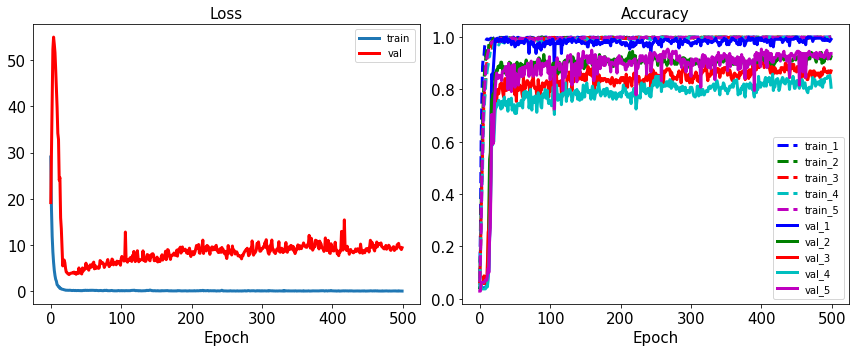

In [262]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3, label="train")
ax.plot(hist['val_loss'], 'r', lw=3, label="val")
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc="upper right")

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['digit1_accuracy'], 'b--', lw=3, label="train_1")
ax.plot(hist['digit2_accuracy'], 'g--', lw=3, label="train_2")
ax.plot(hist['digit3_accuracy'], 'r--', lw=3, label="train_3")
ax.plot(hist['digit4_accuracy'], 'c--', lw=3, label="train_4")
ax.plot(hist['digit5_accuracy'], 'm--', lw=3, label="train_5")
ax.plot(hist['val_digit1_accuracy'], 'b', lw=3, label="val_1")
ax.plot(hist['val_digit2_accuracy'], 'g', lw=3, label="val_2")
ax.plot(hist['val_digit3_accuracy'], 'r', lw=3, label="val_3")
ax.plot(hist['val_digit4_accuracy'], 'c', lw=3, label="val_4")
ax.plot(hist['val_digit5_accuracy'], 'm', lw=3, label="val_5")
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.legend(loc="lower right")

plt.show()

由上圖可以得知
1. validation loss在大約100個epochs後會越train越大，代表有over-fitting產生了  
2. training accuracy在大約70個epochs後就都趨於穩定，而validation acccuracy則是緩慢上升到約250個epochs後才來到最高點，但在那時loss是緩慢提升，可能為over-fitting現象
3. 其中training accuracy都近乎100%，而validation accuracy則介於約75~90%之間

#### test accuracy
分別計算5個digits的test accuracy

In [287]:
results = model.evaluate(X_test, (Y_test_1,Y_test_2,Y_test_3,Y_test_4,Y_test_5), batch_size=200, verbose=1)
print('\nTest loss: %.4f' % results[0])
print("Digit 1 test accuracy: %.4f" % results[6])
print("Digit 2 test accuracy: %.4f" % results[7])
print("Digit 3 test accuracy: %.4f" % results[8])
print("Digit 4 test accuracy: %.4f" % results[9])
print("Digit 5 test accuracy: %.4f" % results[10])

520/520 [==============================] - 1s 2ms/sample - loss: 6.6149 - digit1_loss: 0.1997 - digit2_loss: 0.4784 - digit3_loss: 1.6377 - digit4_loss: 3.6641 - digit5_loss: 0.5573 - digit1_accuracy: 0.9904 - digit2_accuracy: 0.9635 - digit3_accuracy: 0.9096 - digit4_accuracy: 0.8635 - digit5_accuracy: 0.9712

Test loss: 6.6149
Digit 1 test accuracy: 0.9904
Digit 2 test accuracy: 0.9635
Digit 3 test accuracy: 0.9096
Digit 4 test accuracy: 0.8635
Digit 5 test accuracy: 0.9712


五個digits test accuracy分別為：99.04%、96.35%、90.96%、86.35%、97.12%  
若digit分開看accuracy還算不錯

#### confusion matrix
畫出confusion matrix

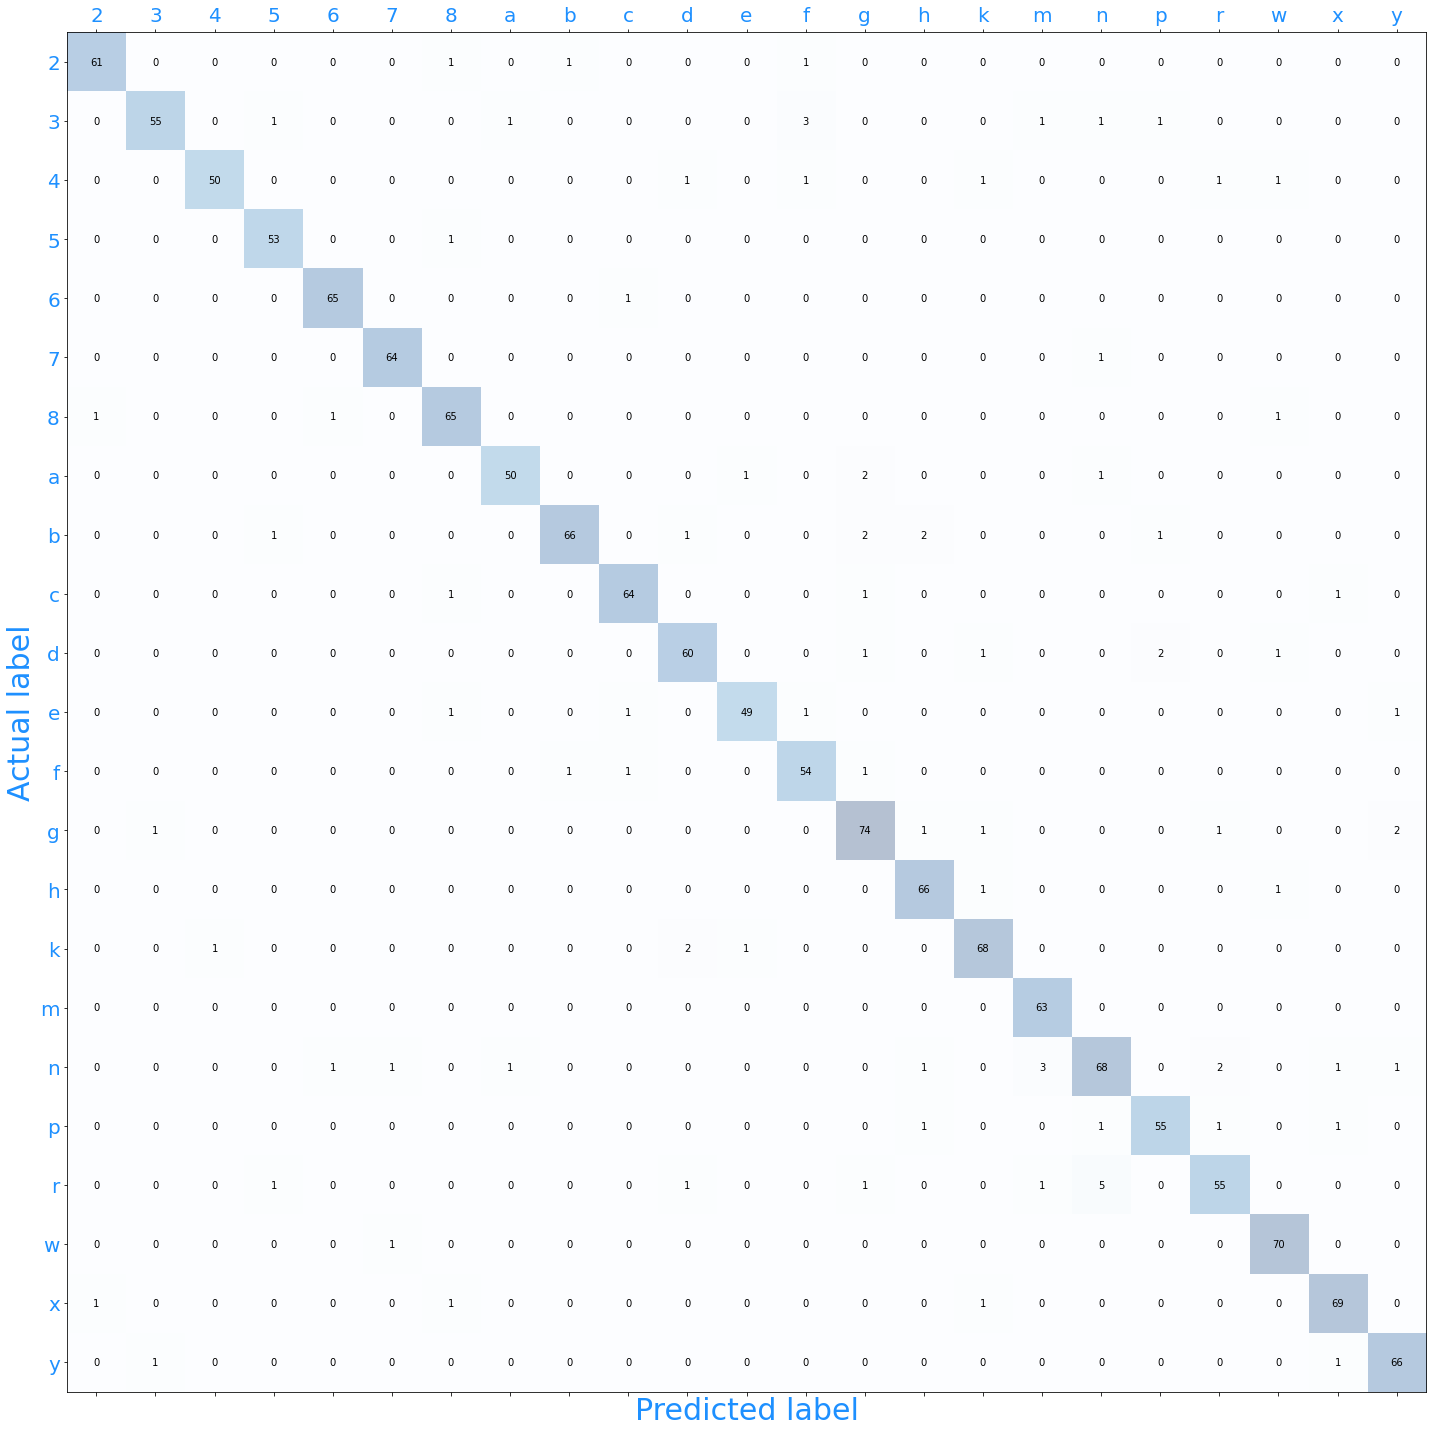

In [307]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)

Y_pred_flatten = np.empty((0,23), int)
for i in range(300):
    for j in range(5):
        Y_pred_flatten = np.vstack([Y_pred_flatten,Y_pred[j][i]])

Y_pred_flatten = np.argmax(Y_pred_flatten,axis = 1)

Y_test_flatten = np.reshape(Y_test, (1500, 23))
Y_test_flatten = np.argmax(Y_test_flatten,axis = 1)


confmat = confusion_matrix(y_true=Y_test_flatten, y_pred=Y_pred_flatten)
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label', fontsize=30, c='dodgerblue')
plt.ylabel('Actual label', fontsize=30, c='dodgerblue')

plt.xticks(np.arange(23) ,list(LETTERSTR), fontsize=20, c='dodgerblue')
plt.yticks(np.arange(23), list(LETTERSTR), fontsize=20, c='dodgerblue')

plt.tight_layout()
plt.savefig('./report_pic/first_model_conufusion_matrix.png')
plt.show()

從confusion matrix可以看出基本上正確率滿高的，predict錯誤的地方較為分散，幾乎都是單獨1筆或2筆，可能原因為data數太少，所以無法明顯觀察  
而predict錯最多的為r被predict為n，次數為5次，這個也蠻合理的，因為原圖很多字體都相連在一起，若那張圖的r剛好跟下一個字相連在一起，看起來就會很像n

#### print predict錯誤的data並觀察

Original label:r7nbm     Predict label:r7bcm


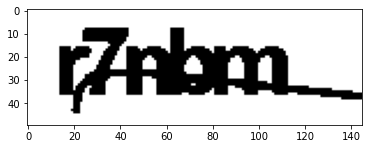

Original label:f2yac     Predict label:f24ac


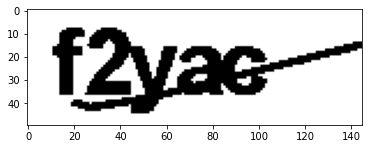

Original label:m5nep     Predict label:m55ep


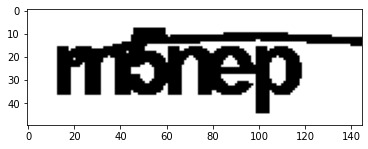

Original label:dpw7c     Predict label:dpwnc


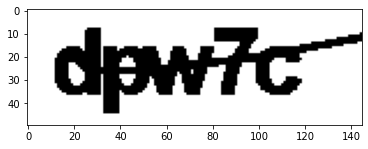

Original label:pmdph     Predict label:pm6pm


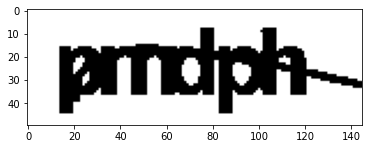

Original label:3pw2a     Predict label:3pw7a


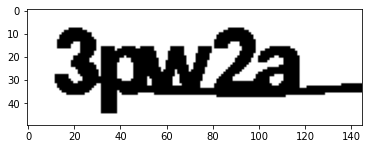

Original label:dwefr     Predict label:dwerr


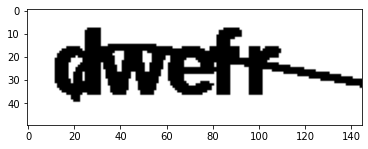

Original label:xffe6     Predict label:xff6g


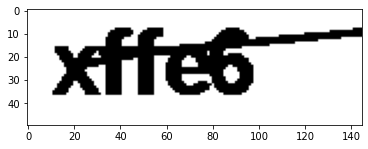

Original label:reg6k     Predict label:rgg6k


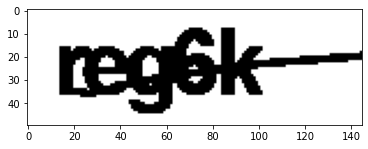

Original label:y7hhr     Predict label:y7bhr


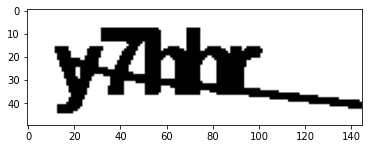

Original label:3r4gy     Predict label:3r4yy


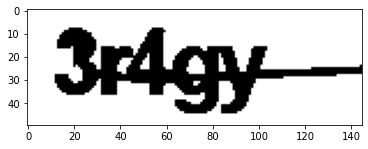

Original label:xanr4     Predict label:xanf4


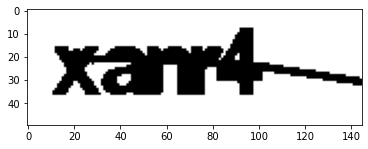

Original label:py4nm     Predict label:py4mm


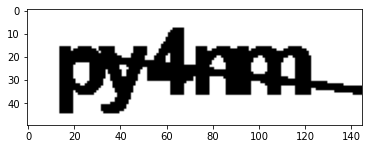

Original label:rnk35     Predict label:r8k55


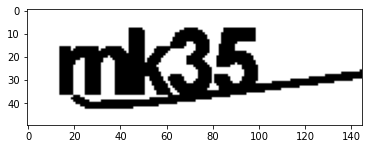

Original label:ex6hf     Predict label:ex6ff


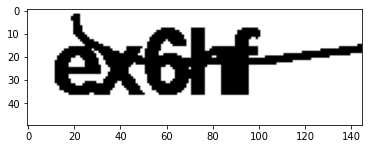

Original label:wb447     Predict label:wbx47


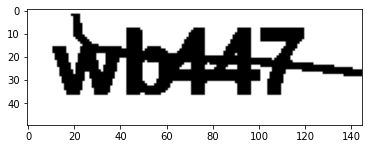

Original label:5wmmp     Predict label:5wmmm


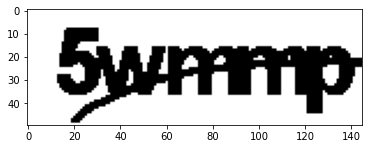

Original label:m5bwf     Predict label:m55ww


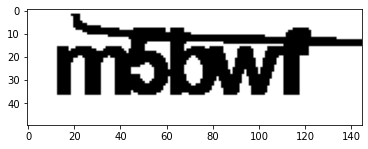

Original label:ndahh     Predict label:nbahh


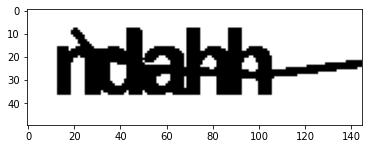

Original label:byadw     Predict label:5yadw


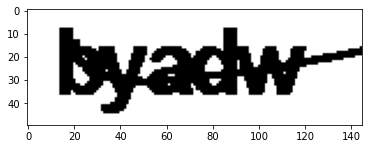

Original label:cd3nb     Predict label:ed3nb


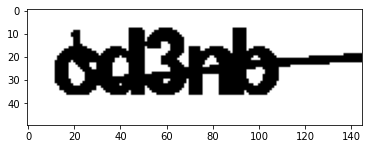

Original label:5ca34     Predict label:5cad4


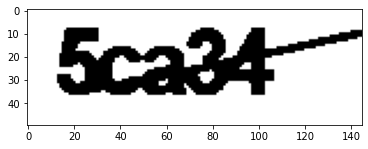

Original label:wh3e8     Predict label:whhg8


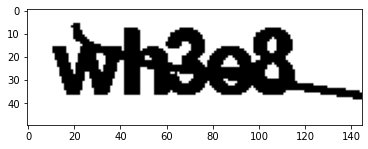

Original label:8f27r     Predict label:8f2rr


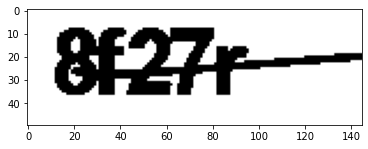

Original label:m3wdy     Predict label:m8wdb


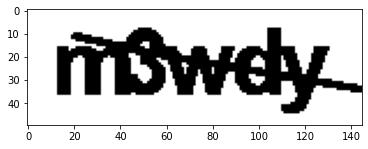

Original label:xmnxy     Predict label:xmnnx


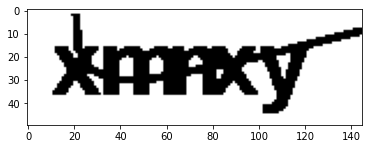

Original label:6xh42     Predict label:6xb42


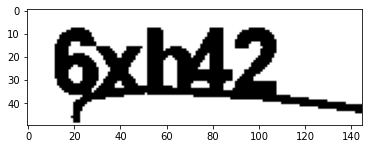

Original label:wy5a3     Predict label:wyp52


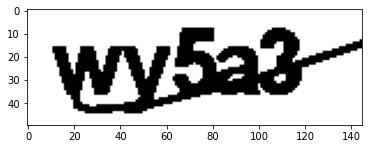

Original label:m8y5n     Predict label:m8y5m


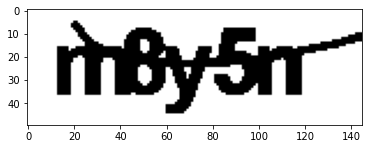

Original label:mbwc8     Predict label:mbwwc


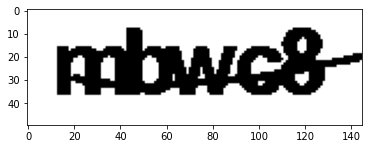

Original label:8mnn2     Predict label:8mmn2


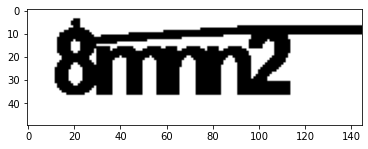

Original label:mbc67     Predict label:mdc67


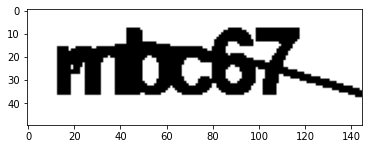

Original label:m8re2     Predict label:mdre2


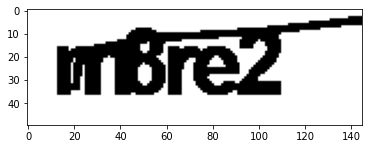

Original label:m7n26     Predict label:m7726


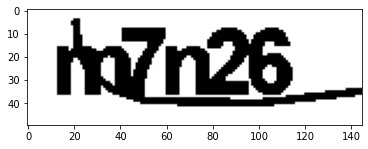

Original label:mg2ea     Predict label:mg27a


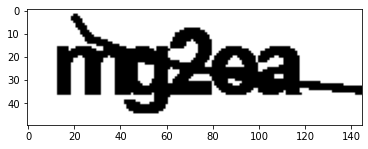

Original label:gemr3     Predict label:gemn6


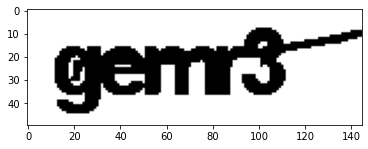

Original label:3wm8m     Predict label:3wma8


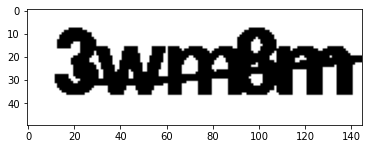

Original label:f8rkb     Predict label:f8kbn


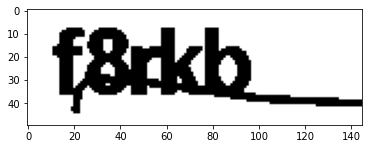

Original label:mmhr8     Predict label:mmmh8


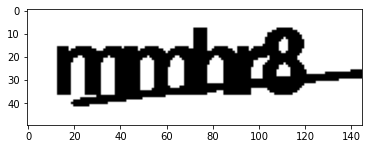

Original label:xm2xc     Predict label:xm82x


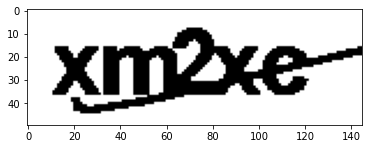

Original label:f26nm     Predict label:f26rm


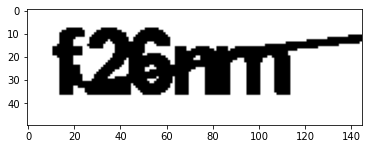

Original label:3f8ye     Predict label:3ffye


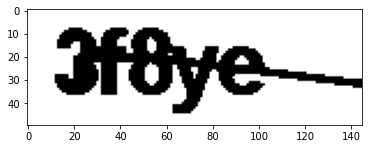

Original label:d3m8w     Predict label:d3mfw


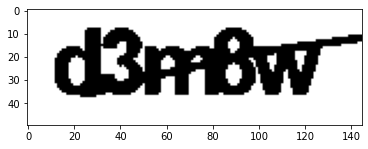

Original label:3w8k4     Predict label:3w8kk


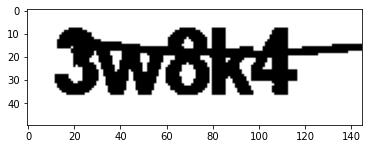

Original label:c7w67     Predict label:c7wf7


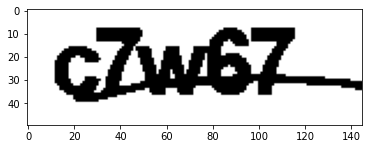

Original label:35yna     Predict label:35yra


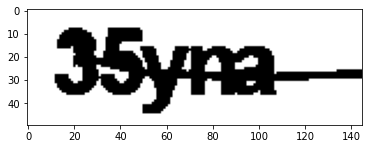

Original label:437rx     Predict label:437fx


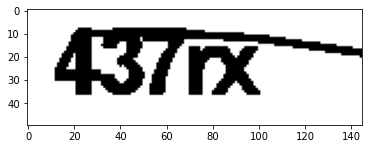

Original label:7whnn     Predict label:7whnm


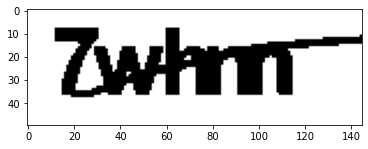

Original label:rfrd4     Predict label:rfdkr


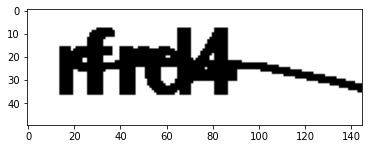

Original label:7r82d     Predict label:7r22d


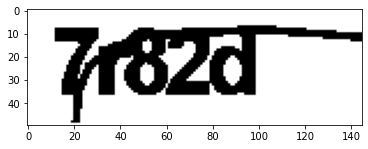

Original label:mpx7m     Predict label:mppxm


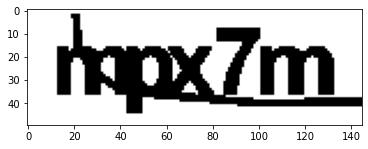

Original label:mpn5a     Predict label:mep5a


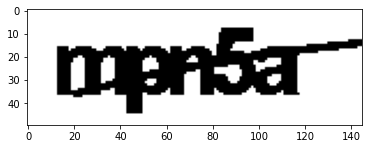

Original label:865m5     Predict label:855m5


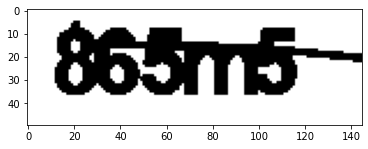

Original label:pwwee     Predict label:pwwwe


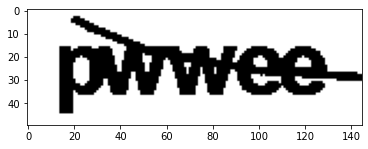

Original label:3re8c     Predict label:3r88c


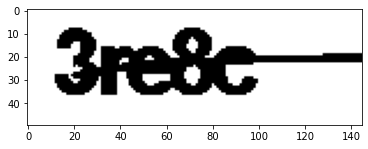

Original label:68erg     Predict label:68ecg


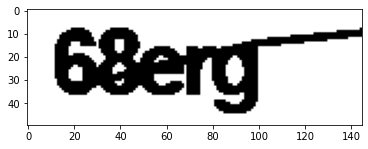

Original label:wkbhh     Predict label:wkkbh


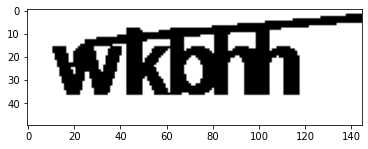

Original label:c2pf7     Predict label:capf7


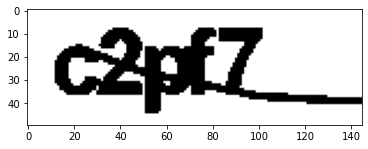

Original label:7rpah     Predict label:7rphh


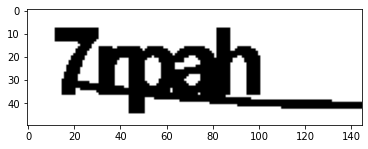

Original label:3wb7g     Predict label:3wbbg


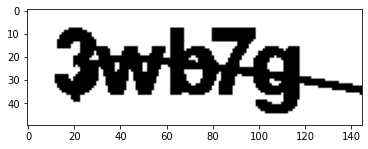

Original label:kwwbp     Predict label:kwwwb


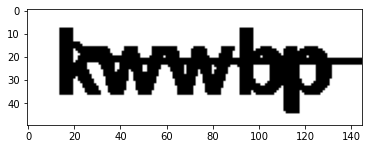

Original label:fka7x     Predict label:fkafx


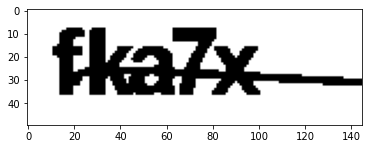

Original label:wyxnh     Predict label:wyyxh


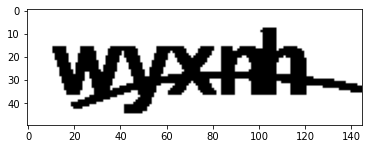

Original label:cweym     Predict label:cwnem


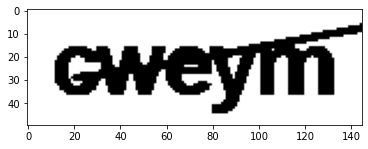

Original label:rrp6b     Predict label:rp6fb


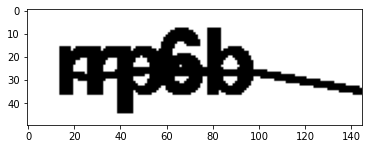

Original label:rxhf6     Predict label:rxhfb


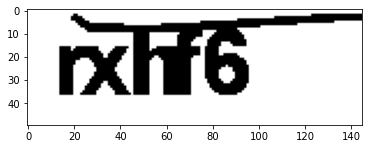

Original label:pwyep     Predict label:pwyyp


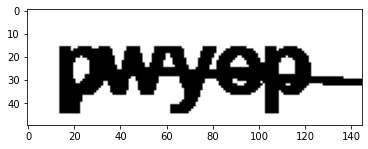

Original label:cwb46     Predict label:cwbb6


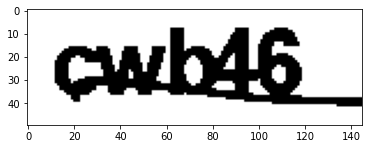

Original label:w2krg     Predict label:w22wg


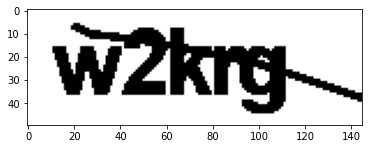

Original label:4mkgd     Predict label:4megg


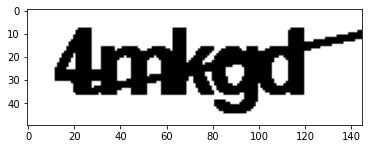

Original label:w6784     Predict label:w6774


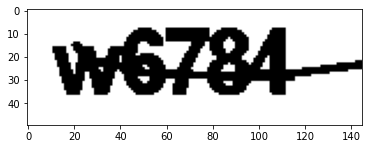

Original label:mpeew     Predict label:mppew


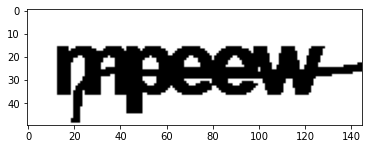

Original label:rm3gy     Predict label:rn3gy


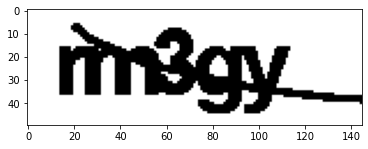

Original label:bgar3     Predict label:hgar3


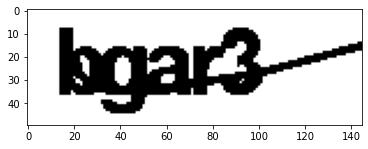

Original label:pxenx     Predict label:pxerx


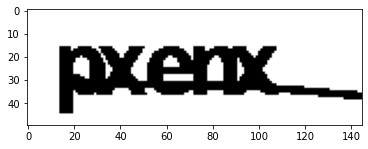

Original label:fn6c3     Predict label:fn6e3


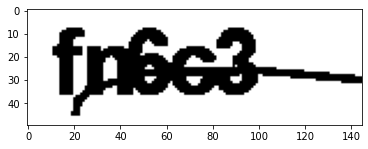

Original label:mnfw3     Predict label:mmfwb


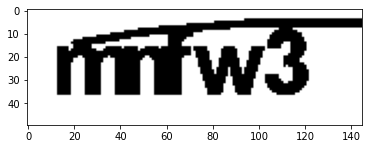

Original label:yr5dx     Predict label:yr5bx


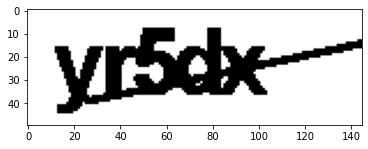

Original label:hnhdh     Predict label:hrhnh


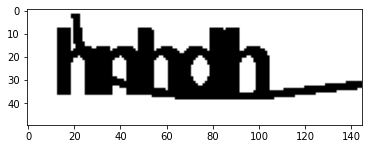

Original label:cm2kg     Predict label:cm27g


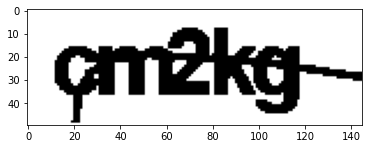

Original label:7m5r6     Predict label:7m5n6


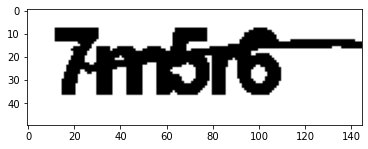

Original label:hkfgx     Predict label:hkfrx


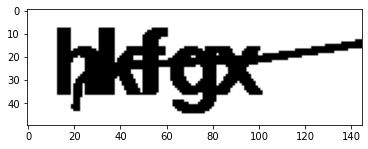

Original label:e3rhw     Predict label:e2rww


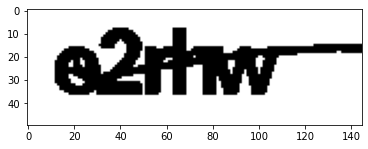

Original label:4dxwr     Predict label:4dxw7


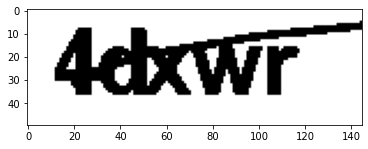

Original label:pwckp     Predict label:pwcxp


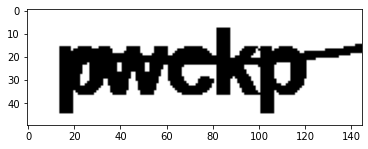

Original label:8b8nn     Predict label:8bfnn


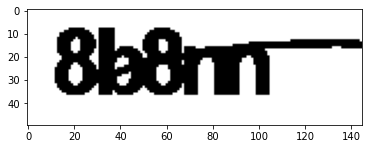

Original label:dd5a4     Predict label:dd5p4


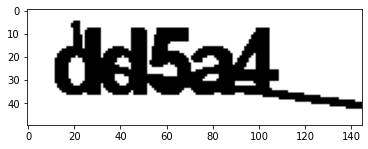

Original label:b8n47     Predict label:b8r47


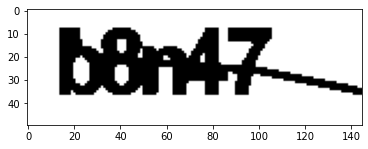

Original label:mw378     Predict label:mww37


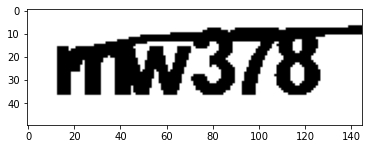

Original label:5rrng     Predict label:5rrgy


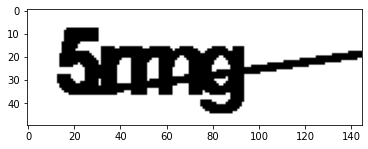

Original label:5b5hn     Predict label:5b5mn


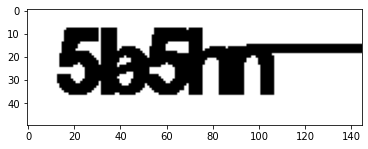

Original label:3yrne     Predict label:3yrae


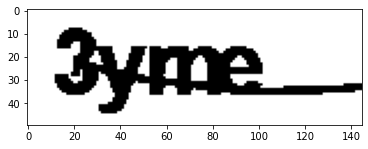

Original label:6ardx     Predict label:6arbx


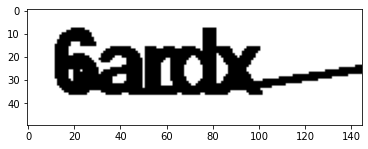

Original label:ag44r     Predict label:ag4dr


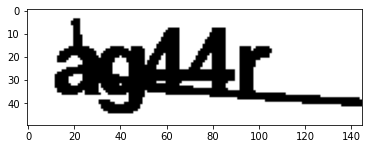

Original label:f67y2     Predict label:567y2


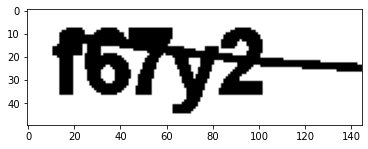

Original label:cefyc     Predict label:ceffc


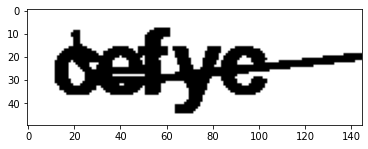

Original label:mna3e     Predict label:mha3e


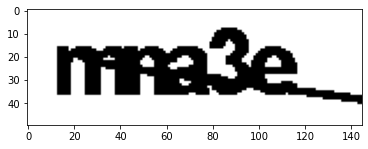

Original label:dbn3f     Predict label:dbnff


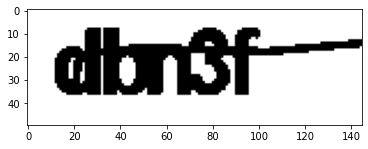

Original label:6ywmf     Predict label:6yw46


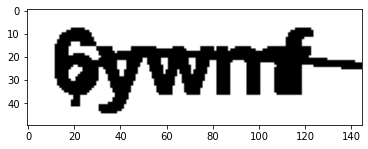

Original label:ya4ay     Predict label:ya4wy


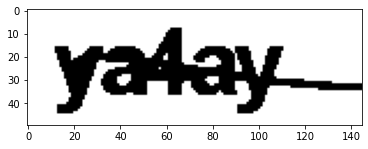

Original label:r7grn     Predict label:r7gca


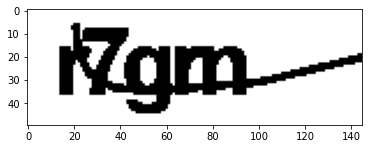

Original label:rhw8n     Predict label:rww8n


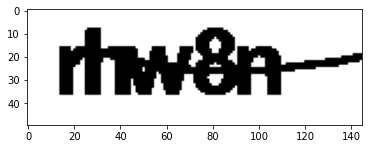

Original label:m6cd2     Predict label:m8cx2


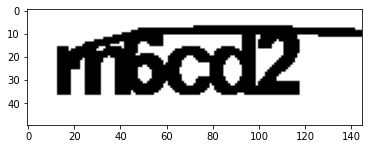

Original label:rbffc     Predict label:rbfcn


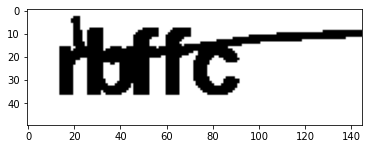

Original label:h8nr4     Predict label:h8nn4


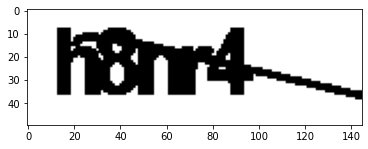

Original label:c7f4p     Predict label:c7ffp


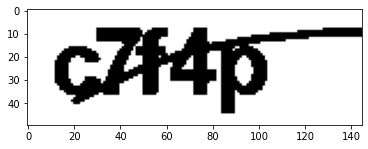

Original label:mr564     Predict label:mm564


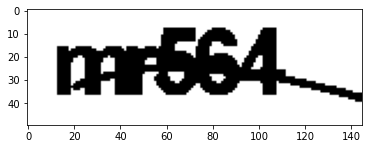

Original label:nahdn     Predict label:nahdh


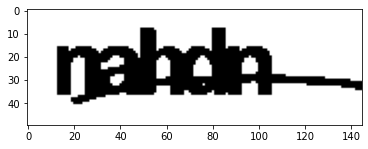

Original label:2amcf     Predict label:2anrf


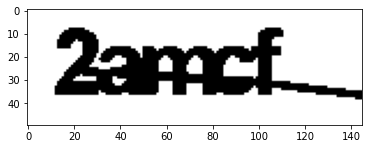

Total accuracy: 0.6367


In [273]:
count = 0
for i in range(300):
    if Y_test_flatten[i*5] != Y_pred_flatten[i*5] or\
       Y_test_flatten[i*5+1] != Y_pred_flatten[i*5+1] or\
       Y_test_flatten[i*5+2] != Y_pred_flatten[i*5+2] or\
       Y_test_flatten[i*5+3] != Y_pred_flatten[i*5+3] or\
       Y_test_flatten[i*5+4] != Y_pred_flatten[i*5+4]:
        print("Original label:" +LETTERSTR[Y_test_flatten[i*5]]+
                                 LETTERSTR[Y_test_flatten[i*5+1]]+
                                 LETTERSTR[Y_test_flatten[i*5+2]]+
                                 LETTERSTR[Y_test_flatten[i*5+3]]+
                                 LETTERSTR[Y_test_flatten[i*5+4]], end='')
        print("     Predict label:" +LETTERSTR[Y_pred_flatten[i*5]]+
                                     LETTERSTR[Y_pred_flatten[i*5+1]]+
                                     LETTERSTR[Y_pred_flatten[i*5+2]]+
                                     LETTERSTR[Y_pred_flatten[i*5+3]]+
                                     LETTERSTR[Y_pred_flatten[i*5+4]])
        wrong_pic = (X_test[i].astype(np.float32))*255
        plt.imshow(wrong_pic, cmap='gray', vmin=0, vmax=255)
        plt.show()
        count += 1

print("Total accuracy: %.4f" % float((300-count)/300))

總體test accuracy為63.37%

### 儲存first_model

In [266]:
model.save('./model/first_model.h5', 
            overwrite=True,
            include_optimizer=True,
            save_format='h5')

## <font color="#0000dd">first_model結論</font>
五個digits accuracy分別為：99.04%、96.35%、90.96%、86.35%、97.12%  
總體test accuracy為63.37%  
  
做完以上觀察，我覺得accuracy應該可以再提升，而提升方式有兩種不同方向，分別是：
1. <b><font color="red">將model中dropout及max-pooling數減少，以獲得更多資訊</font></b>
2. <b><font color="red">保留原model樣貌，但餵更多data進去訓練</font></b>  
因此，我朝著這兩種方向分別又建立了以下兩個model

---

## <font color="#0000dd">建second_model</font>
修改上一個model並將dropout及max-pooling數減少
1. dropout機率一率改為0.2
2. 第二層Conv2D後dropout拿掉
3. 第二、六層Conv2D後max-pooling拿掉
4. 由於要train的weight數太多，將第一、二層Conv2D的kernel_size改為$2\times2$

In [269]:
#input layer
inputs = tf.keras.layers.Input(shape=(50,145,1))
outputs = inputs

#第一層Conv2D
outputs = tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu', name='conv_1')(outputs)

#第二層Conv2D
outputs = tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu', name='conv_2')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)

#第三層Conv2D
outputs = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv_3')(outputs)

#第四層Conv2D
outputs = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv_4')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Dropout(rate=0.2)(outputs)

#第五層Conv2D
out = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv_5')(outputs)

#第六層Conv2D
outputs = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv_6')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.Dropout(rate=0.2)(outputs)

#第七層Conv2D
outputs = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv_7')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Flatten()(outputs)
outputs = tf.keras.layers.Dropout(rate=0.2)(outputs)

#output layer
outputs = [tf.keras.layers.Dense(23, name='digit1', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit2', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit3', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit4', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit5', activation='softmax')(outputs)]
second_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
second_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
second_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 50, 145, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 50, 145, 32)  160         input_18[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 50, 145, 32)  4128        conv_1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 50, 145, 32)  128         conv_2[0][0]                     
___________________________________________________________________________________________

從上表可以看出要train的weight有6,641,011個，大約是上一個model的5倍

### Train second_model
將training dataset丟進model做training，分20%training data為validation，batch_size設為32，並做300次epochs  
由於上一個model在大約70個epochs就train的差不多，這次model的weight比較多，我就設epochs數300

In [270]:
history = second_model.fit(X_train, (Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5), 
                    shuffle=True, epochs=300, 
                    batch_size = 32, validation_split=0.2, 
                    verbose=1)

Train on 960 samples, validate on 240 samples
Epoch 1/300
960/960 [==============================] - 10s 11ms/sample - loss: 139.8631 - digit1_loss: 25.6836 - digit2_loss: 27.4059 - digit3_loss: 25.7941 - digit4_loss: 30.4483 - digit5_loss: 30.5311 - digit1_accuracy: 0.1448 - digit2_accuracy: 0.1115 - digit3_accuracy: 0.0958 - digit4_accuracy: 0.0688 - digit5_accuracy: 0.0708 - val_loss: 203.7866 - val_digit1_loss: 37.8924 - val_digit2_loss: 38.3987 - val_digit3_loss: 29.2633 - val_digit4_loss: 43.2061 - val_digit5_loss: 55.5070 - val_digit1_accuracy: 0.0417 - val_digit2_accuracy: 0.0500 - val_digit3_accuracy: 0.0417 - val_digit4_accuracy: 0.0583 - val_digit5_accuracy: 0.0375
Epoch 2/300
960/960 [==============================] - 5s 5ms/sample - loss: 27.2733 - digit1_loss: 2.6813 - digit2_loss: 4.7452 - digit3_loss: 6.3899 - digit4_loss: 6.5289 - digit5_loss: 6.9280 - digit1_accuracy: 0.6948 - digit2_accuracy: 0.5260 - digit3_accuracy: 0.3990 - digit4_accuracy: 0.3677 - digit5_accurac

Epoch 14/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.7650 - digit1_loss: 0.0243 - digit2_loss: 0.0796 - digit3_loss: 0.3554 - digit4_loss: 0.1243 - digit5_loss: 0.1813 - digit1_accuracy: 0.9958 - digit2_accuracy: 0.9844 - digit3_accuracy: 0.9385 - digit4_accuracy: 0.9698 - digit5_accuracy: 0.9656 - val_loss: 139.7390 - val_digit1_loss: 14.4135 - val_digit2_loss: 21.2146 - val_digit3_loss: 32.8930 - val_digit4_loss: 35.5277 - val_digit5_loss: 36.4995 - val_digit1_accuracy: 0.1250 - val_digit2_accuracy: 0.1083 - val_digit3_accuracy: 0.0875 - val_digit4_accuracy: 0.0417 - val_digit5_accuracy: 0.0458
Epoch 15/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.5906 - digit1_loss: 0.0100 - digit2_loss: 0.1197 - digit3_loss: 0.1607 - digit4_loss: 0.1874 - digit5_loss: 0.1128 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9719 - digit3_accuracy: 0.9656 - digit4_accuracy: 0.9490 - digit5_accuracy: 0.9740 - val_loss: 115.9091 - val_digit1_loss: 9.95

960/960 [==============================] - 5s 5ms/sample - loss: 0.3597 - digit1_loss: 0.0153 - digit2_loss: 0.0298 - digit3_loss: 0.0653 - digit4_loss: 0.1920 - digit5_loss: 0.0573 - digit1_accuracy: 0.9958 - digit2_accuracy: 0.9948 - digit3_accuracy: 0.9896 - digit4_accuracy: 0.9740 - digit5_accuracy: 0.9896 - val_loss: 32.5371 - val_digit1_loss: 0.6283 - val_digit2_loss: 4.2559 - val_digit3_loss: 8.1554 - val_digit4_loss: 11.2041 - val_digit5_loss: 8.3501 - val_digit1_accuracy: 0.9458 - val_digit2_accuracy: 0.8042 - val_digit3_accuracy: 0.6208 - val_digit4_accuracy: 0.5458 - val_digit5_accuracy: 0.6167
Epoch 41/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.3388 - digit1_loss: 0.0173 - digit2_loss: 0.0604 - digit3_loss: 0.0174 - digit4_loss: 0.2102 - digit5_loss: 0.0335 - digit1_accuracy: 0.9969 - digit2_accuracy: 0.9917 - digit3_accuracy: 0.9937 - digit4_accuracy: 0.9792 - digit5_accuracy: 0.9906 - val_loss: 35.4361 - val_digit1_loss: 0.6200 - val_digit2_los

960/960 [==============================] - 5s 5ms/sample - loss: 0.3688 - digit1_loss: 2.1326e-05 - digit2_loss: 0.1355 - digit3_loss: 0.0670 - digit4_loss: 0.0615 - digit5_loss: 0.1048 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9906 - digit3_accuracy: 0.9917 - digit4_accuracy: 0.9875 - digit5_accuracy: 0.9875 - val_loss: 47.0392 - val_digit1_loss: 0.8897 - val_digit2_loss: 7.0105 - val_digit3_loss: 10.8545 - val_digit4_loss: 15.6708 - val_digit5_loss: 12.3790 - val_digit1_accuracy: 0.9292 - val_digit2_accuracy: 0.7875 - val_digit3_accuracy: 0.6292 - val_digit4_accuracy: 0.5542 - val_digit5_accuracy: 0.5917
Epoch 67/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.4496 - digit1_loss: 0.0030 - digit2_loss: 0.0593 - digit3_loss: 0.1596 - digit4_loss: 0.1461 - digit5_loss: 0.0816 - digit1_accuracy: 0.9990 - digit2_accuracy: 0.9896 - digit3_accuracy: 0.9833 - digit4_accuracy: 0.9865 - digit5_accuracy: 0.9865 - val_loss: 40.8373 - val_digit1_loss: 0.7800 - val_digi

960/960 [==============================] - 5s 5ms/sample - loss: 0.1679 - digit1_loss: 4.9341e-04 - digit2_loss: 0.0200 - digit3_loss: 3.7825e-04 - digit4_loss: 0.0721 - digit5_loss: 0.0749 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9958 - digit5_accuracy: 0.9927 - val_loss: 47.4719 - val_digit1_loss: 0.7271 - val_digit2_loss: 8.4432 - val_digit3_loss: 11.6710 - val_digit4_loss: 16.1817 - val_digit5_loss: 10.8597 - val_digit1_accuracy: 0.9583 - val_digit2_accuracy: 0.7875 - val_digit3_accuracy: 0.6708 - val_digit4_accuracy: 0.6083 - val_digit5_accuracy: 0.6292
Epoch 93/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.2396 - digit1_loss: 1.0769e-05 - digit2_loss: 0.1302 - digit3_loss: 0.0156 - digit4_loss: 0.0450 - digit5_loss: 0.0488 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9937 - digit3_accuracy: 0.9969 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9948 - val_loss: 44.8915 - val_digit1_loss: 0.8208 - 

Epoch 105/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1826 - digit1_loss: 4.8521e-07 - digit2_loss: 0.0645 - digit3_loss: 5.6946e-04 - digit4_loss: 0.0891 - digit5_loss: 0.0284 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9896 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9917 - digit5_accuracy: 0.9969 - val_loss: 48.3187 - val_digit1_loss: 0.8519 - val_digit2_loss: 8.8187 - val_digit3_loss: 11.7255 - val_digit4_loss: 15.1713 - val_digit5_loss: 11.7295 - val_digit1_accuracy: 0.9583 - val_digit2_accuracy: 0.8083 - val_digit3_accuracy: 0.6875 - val_digit4_accuracy: 0.6167 - val_digit5_accuracy: 0.6500
Epoch 106/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1637 - digit1_loss: 1.1921e-07 - digit2_loss: 0.0980 - digit3_loss: 9.8079e-06 - digit4_loss: 0.0471 - digit5_loss: 0.0186 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9917 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9948 - digit5_accuracy: 0.9969 - val_loss: 48.9197 - val_dig

Epoch 118/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1617 - digit1_loss: 0.0070 - digit2_loss: 0.0289 - digit3_loss: 0.0865 - digit4_loss: 0.0134 - digit5_loss: 0.0258 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9917 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9948 - val_loss: 48.0615 - val_digit1_loss: 1.0638 - val_digit2_loss: 7.9769 - val_digit3_loss: 11.5632 - val_digit4_loss: 14.4811 - val_digit5_loss: 12.4651 - val_digit1_accuracy: 0.9500 - val_digit2_accuracy: 0.7958 - val_digit3_accuracy: 0.6625 - val_digit4_accuracy: 0.6250 - val_digit5_accuracy: 0.6042
Epoch 119/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.2613 - digit1_loss: 4.0144e-04 - digit2_loss: 0.0550 - digit3_loss: 0.0825 - digit4_loss: 0.0242 - digit5_loss: 0.0993 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9917 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9927 - val_loss: 56.0076 - val_digit1_loss: 0.

Epoch 131/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1139 - digit1_loss: 4.5615e-04 - digit2_loss: 2.2963e-04 - digit3_loss: 6.6243e-04 - digit4_loss: 0.0095 - digit5_loss: 0.1031 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9958 - digit5_accuracy: 0.9906 - val_loss: 51.8292 - val_digit1_loss: 0.7772 - val_digit2_loss: 8.0382 - val_digit3_loss: 13.0742 - val_digit4_loss: 15.2516 - val_digit5_loss: 14.1820 - val_digit1_accuracy: 0.9625 - val_digit2_accuracy: 0.8125 - val_digit3_accuracy: 0.6875 - val_digit4_accuracy: 0.6417 - val_digit5_accuracy: 0.6333
Epoch 132/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0541 - digit1_loss: 1.5252e-06 - digit2_loss: 6.7137e-06 - digit3_loss: 7.6506e-05 - digit4_loss: 0.0081 - digit5_loss: 0.0459 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9937 - val_loss: 53.9629 -

Epoch 144/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.4196 - digit1_loss: 7.1276e-08 - digit2_loss: 0.0892 - digit3_loss: 0.0483 - digit4_loss: 0.1762 - digit5_loss: 0.1059 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9927 - digit3_accuracy: 0.9958 - digit4_accuracy: 0.9844 - digit5_accuracy: 0.9917 - val_loss: 76.8548 - val_digit1_loss: 0.6544 - val_digit2_loss: 10.1332 - val_digit3_loss: 21.9579 - val_digit4_loss: 22.6945 - val_digit5_loss: 22.3529 - val_digit1_accuracy: 0.9417 - val_digit2_accuracy: 0.7917 - val_digit3_accuracy: 0.5708 - val_digit4_accuracy: 0.5458 - val_digit5_accuracy: 0.5250
Epoch 145/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.3647 - digit1_loss: 1.8557e-04 - digit2_loss: 0.1259 - digit3_loss: 0.0525 - digit4_loss: 0.0963 - digit5_loss: 0.0898 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9885 - digit3_accuracy: 0.9927 - digit4_accuracy: 0.9885 - digit5_accuracy: 0.9937 - val_loss: 56.3300 - val_digit1_los

Epoch 157/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0698 - digit1_loss: 4.7166e-05 - digit2_loss: 0.0190 - digit3_loss: 0.0064 - digit4_loss: 0.0227 - digit5_loss: 0.0216 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9958 - digit5_accuracy: 0.9990 - val_loss: 64.8714 - val_digit1_loss: 0.9868 - val_digit2_loss: 10.4131 - val_digit3_loss: 17.6193 - val_digit4_loss: 20.1303 - val_digit5_loss: 16.4658 - val_digit1_accuracy: 0.9542 - val_digit2_accuracy: 0.7708 - val_digit3_accuracy: 0.6083 - val_digit4_accuracy: 0.5833 - val_digit5_accuracy: 0.6333
Epoch 158/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0385 - digit1_loss: 1.2045e-08 - digit2_loss: 0.0308 - digit3_loss: 1.6627e-06 - digit4_loss: 0.0061 - digit5_loss: 0.0016 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9990 - val_loss: 52.3934 - val_digit1

Epoch 170/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1942 - digit1_loss: 2.5083e-08 - digit2_loss: 0.0193 - digit3_loss: 0.1209 - digit4_loss: 0.0101 - digit5_loss: 0.0439 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9958 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9948 - val_loss: 54.6110 - val_digit1_loss: 0.7748 - val_digit2_loss: 9.8759 - val_digit3_loss: 12.7735 - val_digit4_loss: 16.9258 - val_digit5_loss: 14.6294 - val_digit1_accuracy: 0.9542 - val_digit2_accuracy: 0.8000 - val_digit3_accuracy: 0.6667 - val_digit4_accuracy: 0.6125 - val_digit5_accuracy: 0.5958
Epoch 171/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1235 - digit1_loss: 5.2154e-09 - digit2_loss: 0.0356 - digit3_loss: 0.0351 - digit4_loss: 0.0220 - digit5_loss: 0.0308 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9958 - digit3_accuracy: 0.9969 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9969 - val_loss: 57.4809 - val_digit1_loss

Epoch 183/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1365 - digit1_loss: 0.0171 - digit2_loss: 4.1736e-04 - digit3_loss: 0.0590 - digit4_loss: 0.0284 - digit5_loss: 0.0316 - digit1_accuracy: 0.9969 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9948 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9958 - val_loss: 61.7646 - val_digit1_loss: 0.7362 - val_digit2_loss: 9.9555 - val_digit3_loss: 16.4555 - val_digit4_loss: 18.3326 - val_digit5_loss: 16.1222 - val_digit1_accuracy: 0.9583 - val_digit2_accuracy: 0.7792 - val_digit3_accuracy: 0.6542 - val_digit4_accuracy: 0.6292 - val_digit5_accuracy: 0.6417
Epoch 184/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0953 - digit1_loss: 0.0174 - digit2_loss: 0.0054 - digit3_loss: 0.0416 - digit4_loss: 0.0110 - digit5_loss: 0.0200 - digit1_accuracy: 0.9979 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9990 - val_loss: 60.2670 - val_digit1_loss: 0.

Epoch 196/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0787 - digit1_loss: 1.2911e-06 - digit2_loss: 0.0100 - digit3_loss: 0.0622 - digit4_loss: 0.0065 - digit5_loss: 1.0613e-05 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9969 - digit4_accuracy: 0.9990 - digit5_accuracy: 1.0000 - val_loss: 55.9772 - val_digit1_loss: 0.8281 - val_digit2_loss: 10.0510 - val_digit3_loss: 15.2824 - val_digit4_loss: 15.9940 - val_digit5_loss: 13.5226 - val_digit1_accuracy: 0.9625 - val_digit2_accuracy: 0.8333 - val_digit3_accuracy: 0.6542 - val_digit4_accuracy: 0.6208 - val_digit5_accuracy: 0.6708
Epoch 197/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1507 - digit1_loss: 0.0000e+00 - digit2_loss: 0.0546 - digit3_loss: 0.0302 - digit4_loss: 0.0130 - digit5_loss: 0.0529 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9969 - digit3_accuracy: 0.9969 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9979 - val_loss: 60.5152 - val_digit1

Epoch 209/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1104 - digit1_loss: 1.2632e-06 - digit2_loss: 0.0084 - digit3_loss: 0.0239 - digit4_loss: 0.0658 - digit5_loss: 0.0123 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9979 - digit4_accuracy: 0.9937 - digit5_accuracy: 0.9979 - val_loss: 55.2898 - val_digit1_loss: 1.5132 - val_digit2_loss: 9.8212 - val_digit3_loss: 15.4695 - val_digit4_loss: 15.7209 - val_digit5_loss: 12.8516 - val_digit1_accuracy: 0.9500 - val_digit2_accuracy: 0.8125 - val_digit3_accuracy: 0.6583 - val_digit4_accuracy: 0.6250 - val_digit5_accuracy: 0.6792
Epoch 210/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0924 - digit1_loss: 2.4835e-10 - digit2_loss: 0.0165 - digit3_loss: 0.0254 - digit4_loss: 0.0396 - digit5_loss: 0.0109 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9990 - val_loss: 53.6264 - val_digit1_loss

Epoch 222/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0576 - digit1_loss: 1.6775e-07 - digit2_loss: 2.7724e-04 - digit3_loss: 8.1391e-04 - digit4_loss: 0.0229 - digit5_loss: 0.0336 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9958 - val_loss: 53.2229 - val_digit1_loss: 0.3984 - val_digit2_loss: 9.5643 - val_digit3_loss: 12.7185 - val_digit4_loss: 16.7928 - val_digit5_loss: 13.7707 - val_digit1_accuracy: 0.9708 - val_digit2_accuracy: 0.8125 - val_digit3_accuracy: 0.7083 - val_digit4_accuracy: 0.6458 - val_digit5_accuracy: 0.6708
Epoch 223/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1502 - digit1_loss: 0.0056 - digit2_loss: 2.3718e-06 - digit3_loss: 0.0037 - digit4_loss: 0.0517 - digit5_loss: 0.0892 - digit1_accuracy: 0.9990 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9948 - val_loss: 52.0737 - val_dig

Epoch 235/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0873 - digit1_loss: 0.0066 - digit2_loss: 4.5817e-05 - digit3_loss: 0.0084 - digit4_loss: 0.0100 - digit5_loss: 0.0623 - digit1_accuracy: 0.9990 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9948 - val_loss: 50.2998 - val_digit1_loss: 0.6191 - val_digit2_loss: 9.5942 - val_digit3_loss: 11.9223 - val_digit4_loss: 16.0992 - val_digit5_loss: 11.4881 - val_digit1_accuracy: 0.9708 - val_digit2_accuracy: 0.8042 - val_digit3_accuracy: 0.7292 - val_digit4_accuracy: 0.6333 - val_digit5_accuracy: 0.6792
Epoch 236/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0575 - digit1_loss: 7.3564e-06 - digit2_loss: 0.0025 - digit3_loss: 0.0043 - digit4_loss: 0.0143 - digit5_loss: 0.0364 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9979 - digit5_accuracy: 0.9958 - val_loss: 52.5352 - val_digit1_loss

Epoch 248/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0663 - digit1_loss: 8.9661e-05 - digit2_loss: 0.0157 - digit3_loss: 0.0055 - digit4_loss: 0.0109 - digit5_loss: 0.0341 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9969 - val_loss: 54.3886 - val_digit1_loss: 0.8337 - val_digit2_loss: 9.5366 - val_digit3_loss: 13.8835 - val_digit4_loss: 15.8574 - val_digit5_loss: 13.9650 - val_digit1_accuracy: 0.9667 - val_digit2_accuracy: 0.8167 - val_digit3_accuracy: 0.6875 - val_digit4_accuracy: 0.7000 - val_digit5_accuracy: 0.6667
Epoch 249/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0366 - digit1_loss: 2.4835e-10 - digit2_loss: 9.1215e-06 - digit3_loss: 0.0075 - digit4_loss: 3.2917e-04 - digit5_loss: 0.0288 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9990 - digit4_accuracy: 1.0000 - digit5_accuracy: 0.9979 - val_loss: 57.1720 - val_dig

Epoch 261/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0375 - digit1_loss: 2.5219e-04 - digit2_loss: 6.8028e-04 - digit3_loss: 0.0321 - digit4_loss: 8.0560e-06 - digit5_loss: 0.0044 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9979 - digit4_accuracy: 1.0000 - digit5_accuracy: 0.9979 - val_loss: 58.5837 - val_digit1_loss: 0.6587 - val_digit2_loss: 9.3312 - val_digit3_loss: 15.5250 - val_digit4_loss: 17.3473 - val_digit5_loss: 16.3527 - val_digit1_accuracy: 0.9625 - val_digit2_accuracy: 0.8208 - val_digit3_accuracy: 0.7125 - val_digit4_accuracy: 0.6625 - val_digit5_accuracy: 0.6208
Epoch 262/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1112 - digit1_loss: 0.0000e+00 - digit2_loss: 5.7837e-06 - digit3_loss: 0.0249 - digit4_loss: 1.3659e-09 - digit5_loss: 0.0863 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9969 - digit4_accuracy: 1.0000 - digit5_accuracy: 0.9958 - val_loss: 57.6208 -

Epoch 274/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.1153 - digit1_loss: 7.4591e-07 - digit2_loss: 0.0223 - digit3_loss: 0.0074 - digit4_loss: 0.0371 - digit5_loss: 0.0485 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 0.9990 - digit4_accuracy: 0.9969 - digit5_accuracy: 0.9979 - val_loss: 56.2541 - val_digit1_loss: 0.6823 - val_digit2_loss: 9.3502 - val_digit3_loss: 13.8962 - val_digit4_loss: 16.4914 - val_digit5_loss: 15.5653 - val_digit1_accuracy: 0.9708 - val_digit2_accuracy: 0.8208 - val_digit3_accuracy: 0.7208 - val_digit4_accuracy: 0.6500 - val_digit5_accuracy: 0.6167
Epoch 275/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0838 - digit1_loss: 0.0000e+00 - digit2_loss: 0.0130 - digit3_loss: 1.7507e-07 - digit4_loss: 0.0363 - digit5_loss: 0.0345 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9979 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9948 - digit5_accuracy: 0.9979 - val_loss: 55.0483 - val_digit1_

Epoch 287/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0890 - digit1_loss: 1.2418e-10 - digit2_loss: 0.0432 - digit3_loss: 1.6684e-04 - digit4_loss: 0.0384 - digit5_loss: 0.0072 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9958 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9990 - digit5_accuracy: 0.9969 - val_loss: 56.1137 - val_digit1_loss: 0.7945 - val_digit2_loss: 9.8732 - val_digit3_loss: 14.2890 - val_digit4_loss: 16.6024 - val_digit5_loss: 14.0022 - val_digit1_accuracy: 0.9542 - val_digit2_accuracy: 0.8042 - val_digit3_accuracy: 0.7083 - val_digit4_accuracy: 0.6708 - val_digit5_accuracy: 0.6750
Epoch 288/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0256 - digit1_loss: 3.7253e-10 - digit2_loss: 0.0239 - digit3_loss: 2.8658e-06 - digit4_loss: 0.0017 - digit5_loss: 6.0685e-06 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9990 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9990 - digit5_accuracy: 1.0000 - val_loss: 55.8955 - val

Epoch 300/300
960/960 [==============================] - 5s 5ms/sample - loss: 0.0130 - digit1_loss: 0.0000e+00 - digit2_loss: 3.1775e-07 - digit3_loss: 0.0122 - digit4_loss: 7.3961e-04 - digit5_loss: 3.0135e-05 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 0.9979 - digit4_accuracy: 1.0000 - digit5_accuracy: 1.0000 - val_loss: 60.6886 - val_digit1_loss: 0.7610 - val_digit2_loss: 10.9279 - val_digit3_loss: 13.6669 - val_digit4_loss: 18.3155 - val_digit5_loss: 16.5073 - val_digit1_accuracy: 0.9583 - val_digit2_accuracy: 0.8083 - val_digit3_accuracy: 0.7042 - val_digit4_accuracy: 0.6458 - val_digit5_accuracy: 0.6458


在我的電腦計算，每次epoch約花5秒，共花約25分鐘完成model訓練

### 觀察second_model結果

#### training及validation learning curve
分別畫epochs v.s. loss及accuracy圖

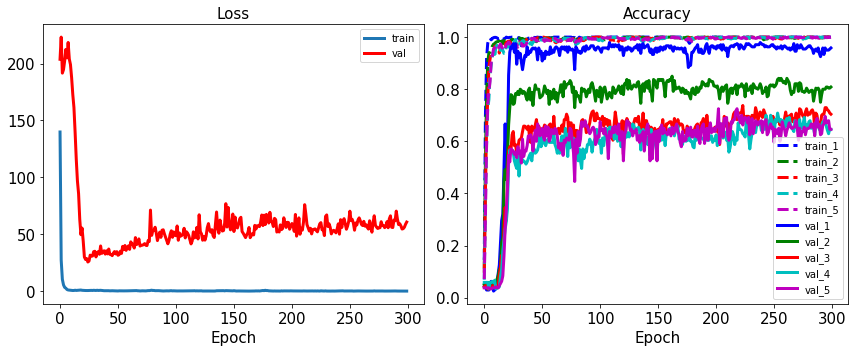

In [271]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3, label="train")
ax.plot(hist['val_loss'], 'r', lw=3, label="val")
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc="upper right")

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['digit1_accuracy'], 'b--', lw=3, label="train_1")
ax.plot(hist['digit2_accuracy'], 'g--', lw=3, label="train_2")
ax.plot(hist['digit3_accuracy'], 'r--', lw=3, label="train_3")
ax.plot(hist['digit4_accuracy'], 'c--', lw=3, label="train_4")
ax.plot(hist['digit5_accuracy'], 'm--', lw=3, label="train_5")
ax.plot(hist['val_digit1_accuracy'], 'b', lw=3, label="val_1")
ax.plot(hist['val_digit2_accuracy'], 'g', lw=3, label="val_2")
ax.plot(hist['val_digit3_accuracy'], 'r', lw=3, label="val_3")
ax.plot(hist['val_digit4_accuracy'], 'c', lw=3, label="val_4")
ax.plot(hist['val_digit5_accuracy'], 'm', lw=3, label="val_5")
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.legend(loc="lower right")

plt.show()

由上圖可以得知
1. validation loss在大約60個epochs後會越train越大，代表有over-fitting產生了  
2. training accuracy在大約40個epochs後就趨於穩定，而validation acccuracy則是大約50個epochs後就趨於穩定
3. 其中training accuracy都近乎100%，而validation accuracy則介於約50~90%之間
4. 此model表現反而比上一個model差

#### test accuracy
分別計算5個digits的test accuracy

In [274]:
results = second_model.evaluate(X_test, (Y_test_1,Y_test_2,Y_test_3,Y_test_4,Y_test_5), batch_size=200, verbose=1)
print('\nTest loss: %.4f' % results[0])
print("Digit 1 test accuracy: %.4f" % results[6])
print("Digit 2 test accuracy: %.4f" % results[7])
print("Digit 3 test accuracy: %.4f" % results[8])
print("Digit 4 test accuracy: %.4f" % results[9])
print("Digit 5 test accuracy: %.4f" % results[10])

300/300 [==============================] - 0s 1ms/sample - loss: 63.5012 - digit1_loss: 0.7693 - digit2_loss: 11.1229 - digit3_loss: 14.9322 - digit4_loss: 20.9151 - digit5_loss: 15.5116 - digit1_accuracy: 0.9567 - digit2_accuracy: 0.8133 - digit3_accuracy: 0.6800 - digit4_accuracy: 0.6200 - digit5_accuracy: 0.6467

Test loss: 63.5012
Digit 1 test accuracy: 0.9567
Digit 2 test accuracy: 0.8133
Digit 3 test accuracy: 0.6800
Digit 4 test accuracy: 0.6200
Digit 5 test accuracy: 0.6467


五個digits test accuracy分別為：95.67%、81.33%、68.00%、62.00%、64.67%  
很明顯可以看出這個model表現較上一個model差了不少

#### confusion matrix
畫出confusion matrix

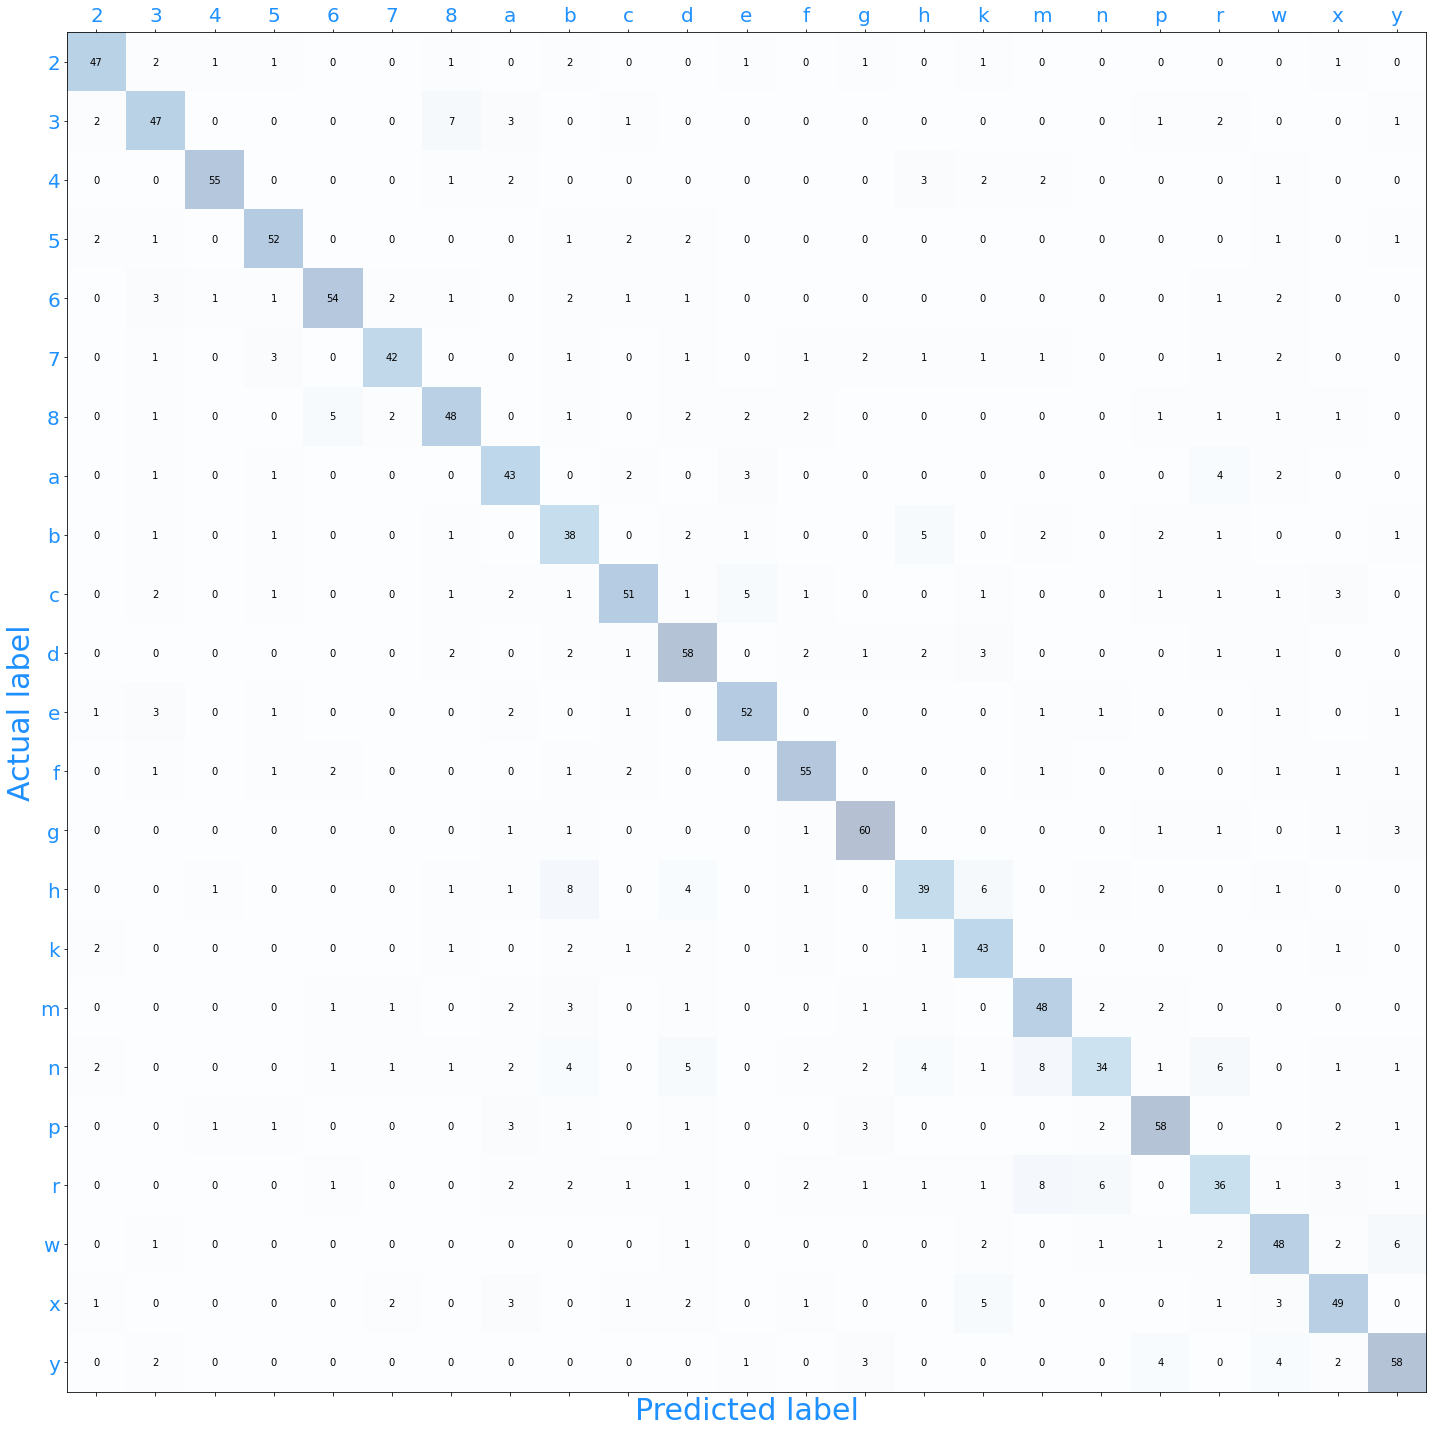

In [275]:
Y_pred_2 = second_model.predict(X_test)

Y_pred_flatten_2 = np.empty((0,23), int)
for i in range(300):
    for j in range(5):
        Y_pred_flatten_2 = np.vstack([Y_pred_flatten_2,Y_pred_2[j][i]])

Y_pred_flatten_2 = np.argmax(Y_pred_flatten_2,axis = 1)

Y_test_flatten_2 = np.reshape(Y_test, (1500, 23))
Y_test_flatten_2 = np.argmax(Y_test_flatten_2,axis = 1)


confmat = confusion_matrix(y_true=Y_test_flatten_2, y_pred=Y_pred_flatten_2)
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label', fontsize=30, c='dodgerblue')
plt.ylabel('Actual label', fontsize=30, c='dodgerblue')

plt.xticks(np.arange(23) ,list(LETTERSTR), fontsize=20, c='dodgerblue')
plt.yticks(np.arange(23), list(LETTERSTR), fontsize=20, c='dodgerblue')

plt.tight_layout()
plt.savefig('./report_pic/second_model_conufusion_matrix.png')
plt.show()

predict錯誤的地方較為分散，幾乎都是單獨1筆或2筆，可能原因為data數太少，所以無法明顯觀察  
而predict錯最多的為r被predict為m及n被predict成m，次數為8次，這個也蠻合理的，因為原圖很多字體都相連在一起，容易導致這些字體判斷錯誤

#### print predict錯誤的data並觀察

Original label:3hxkn     Predict label:3hxkm


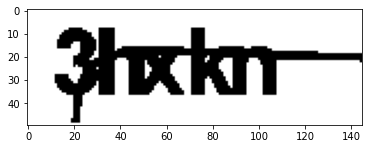

Original label:r7nbm     Predict label:rmbbb


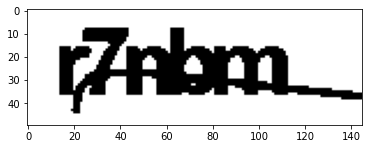

Original label:wg257     Predict label:wgx55


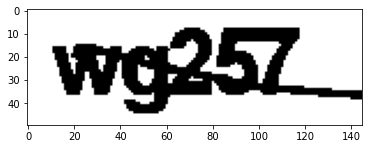

Original label:f2yac     Predict label:f2pac


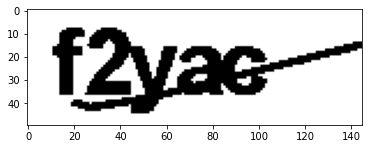

Original label:m5nep     Predict label:mda5p


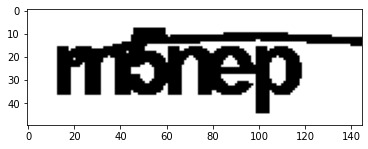

Original label:rg2xf     Predict label:rg2af


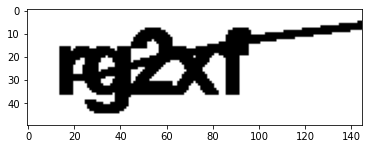

Original label:dpw7c     Predict label:dpwwc


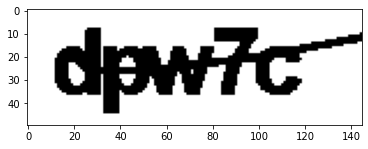

Original label:56h86     Predict label:56h66


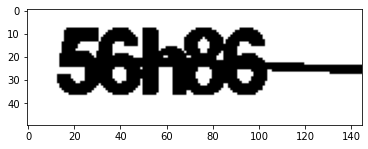

Original label:pmdph     Predict label:pmryh


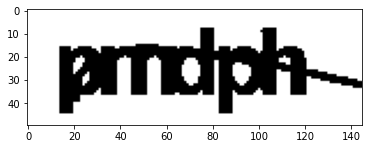

Original label:3pw2a     Predict label:3pw3a


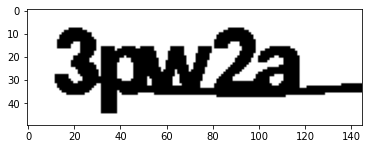

Original label:dwefr     Predict label:dwefx


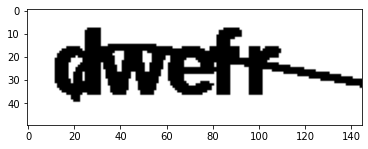

Original label:n6m2c     Predict label:n6m3c


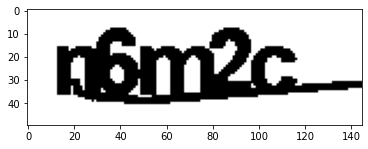

Original label:rndxy     Predict label:mddxp


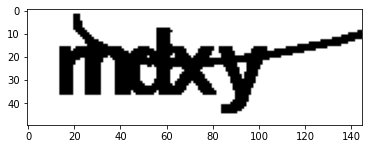

Original label:xffe6     Predict label:xff33


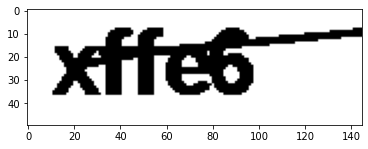

Original label:reg6k     Predict label:ray7k


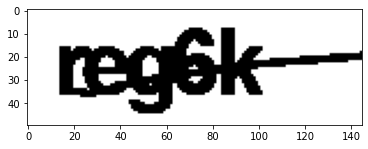

Original label:y7hhr     Predict label:y7bhr


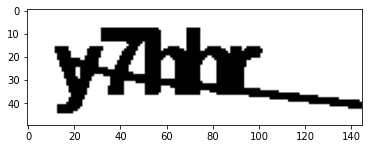

Original label:fg7d5     Predict label:fghd5


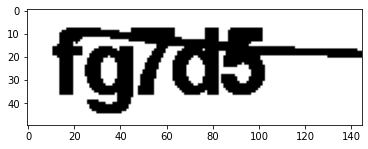

Original label:3r4gy     Predict label:3r4ye


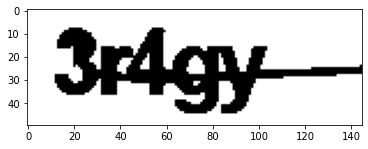

Original label:xanr4     Predict label:xarf4


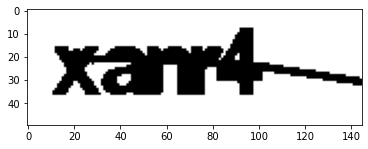

Original label:py4nm     Predict label:pymkm


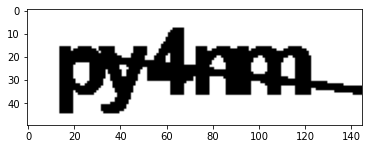

Original label:hay8c     Predict label:nay8c


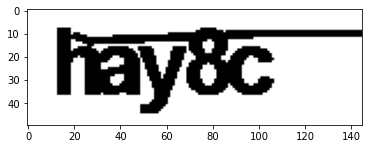

Original label:rnk35     Predict label:mrk85


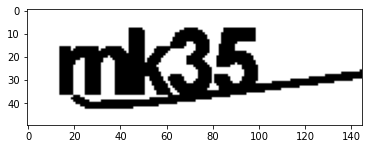

Original label:ex6hf     Predict label:ex6kf


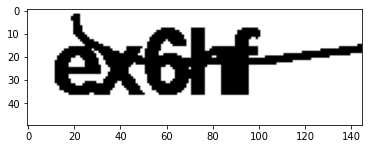

Original label:npg84     Predict label:npg34


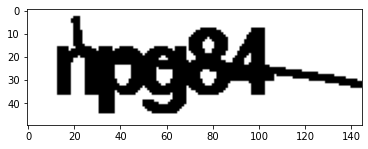

Original label:6mf5y     Predict label:6mfcg


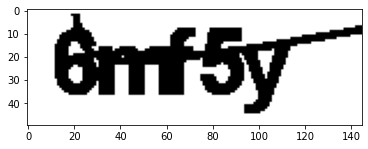

Original label:wb447     Predict label:wy445


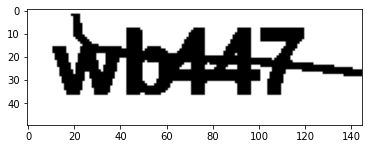

Original label:pcn3b     Predict label:pcn3m


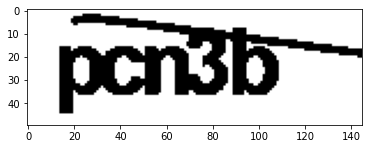

Original label:5wmmp     Predict label:5wmbn


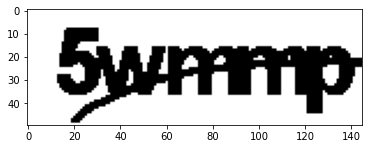

Original label:m5bwf     Predict label:mc536


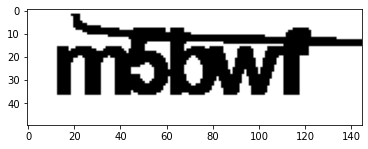

Original label:ndahh     Predict label:n8ahh


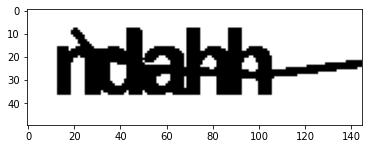

Original label:2r26e     Predict label:2r43e


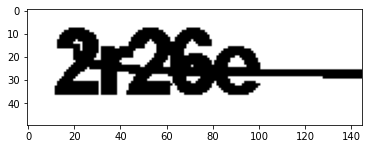

Original label:hc7ag     Predict label:hcrag


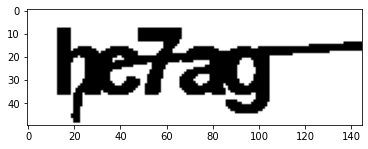

Original label:byadw     Predict label:byrfw


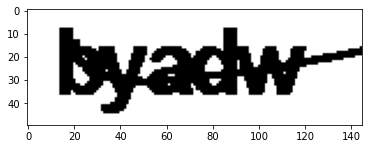

Original label:cd3nb     Predict label:dd3nb


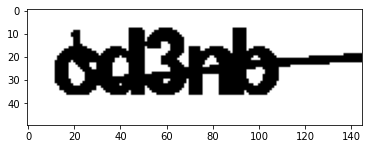

Original label:gwrww     Predict label:gwmww


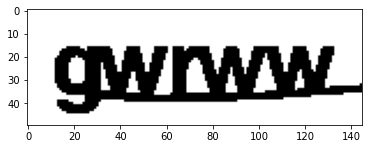

Original label:dxpx4     Predict label:dkpw4


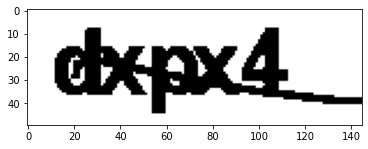

Original label:pg443     Predict label:5g443


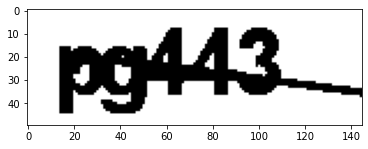

Original label:gxb7c     Predict label:gdb7e


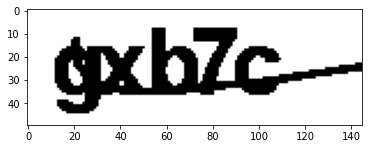

Original label:y6ckh     Predict label:y6xka


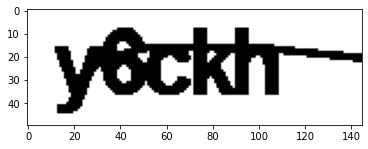

Original label:p2n5f     Predict label:p2b5f


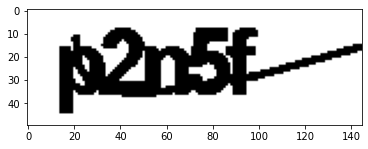

Original label:r5yf5     Predict label:r3pfw


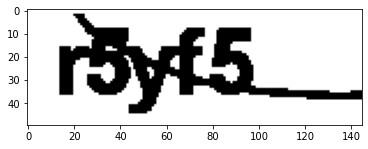

Original label:p3g6w     Predict label:p3g6y


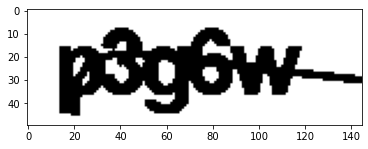

Original label:wh3e8     Predict label:wd838


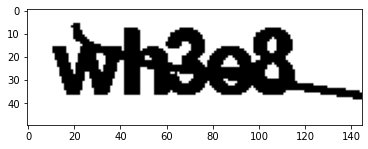

Original label:8f27r     Predict label:8f27m


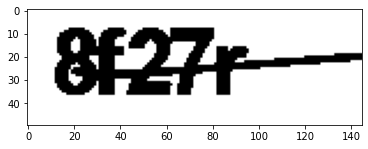

Original label:m3wdy     Predict label:mcwww


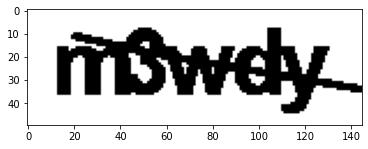

Original label:xmnxy     Predict label:xmmrx


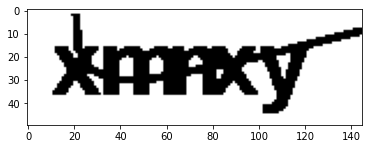

Original label:c6p85     Predict label:56p85


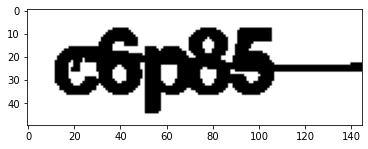

Original label:6wcfy     Predict label:6wexw


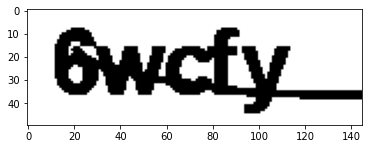

Original label:6d5g8     Predict label:6d5gf


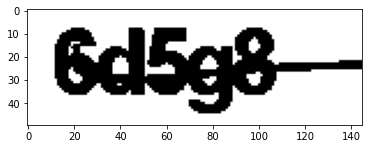

Original label:6xh42     Predict label:6ab42


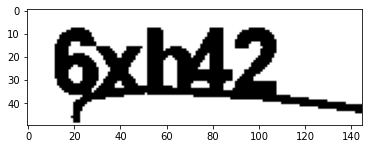

Original label:wy5a3     Predict label:wyy5a


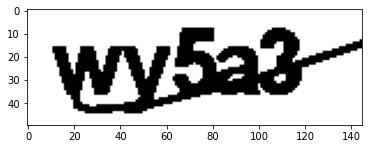

Original label:bfw2h     Predict label:bfx2d


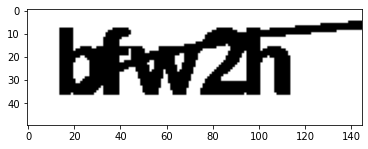

Original label:m8y5n     Predict label:m8y5h


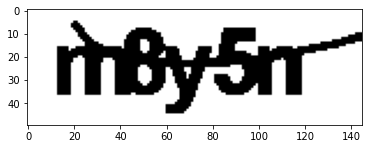

Original label:8ywew     Predict label:8ywnw


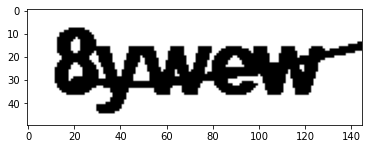

Original label:hb3xh     Predict label:hh3xh


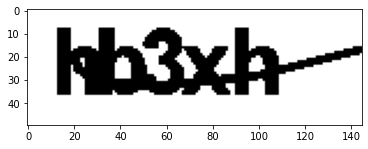

Original label:kbg2r     Predict label:kbg2c


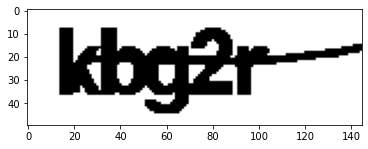

Original label:mbwc8     Predict label:mdwwp


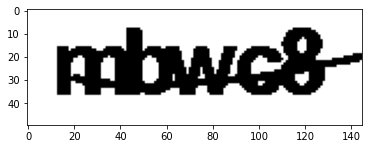

Original label:4dg4e     Predict label:4dbaa


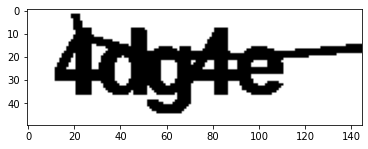

Original label:8mnn2     Predict label:8myb2


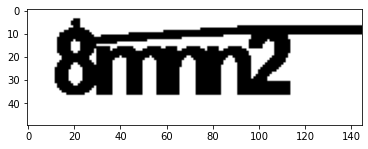

Original label:mbc67     Predict label:mdxc7


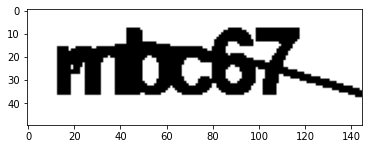

Original label:m8re2     Predict label:m8ae2


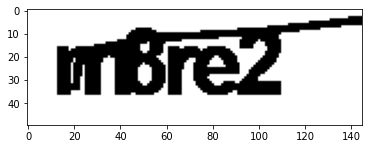

Original label:m7n26     Predict label:mw726


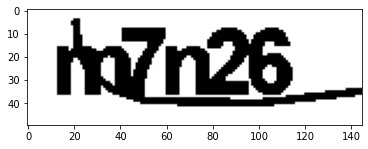

Original label:mg2ea     Predict label:mgg3a


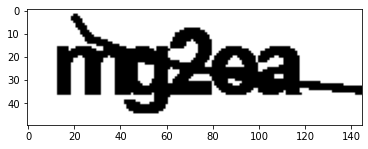

Original label:p2axb     Predict label:p2ax3


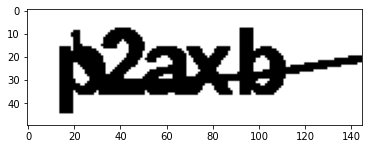

Original label:a4gyg     Predict label:a4gyx


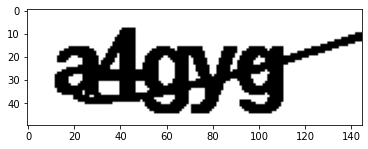

Original label:84y4m     Predict label:84x4n


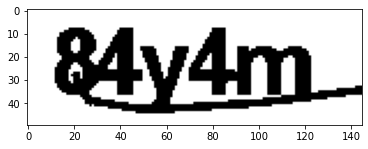

Original label:fp37p     Predict label:f437d


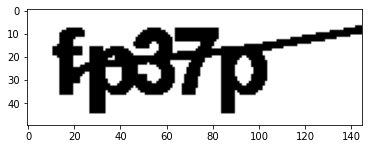

Original label:2y524     Predict label:2yd24


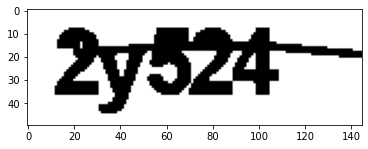

Original label:gemr3     Predict label:gemh8


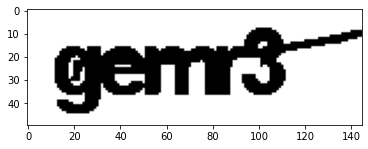

Original label:3wm8m     Predict label:3wmw6


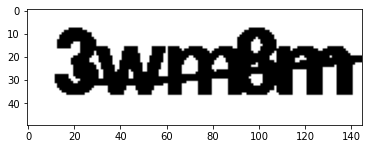

Original label:f8rkb     Predict label:f8rbh


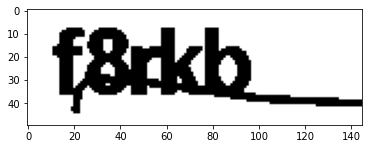

Original label:gaw68     Predict label:gaw66


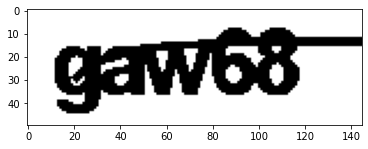

Original label:mmhr8     Predict label:mmdb8


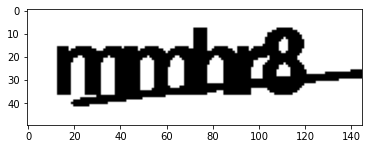

Original label:x8km8     Predict label:xdkm8


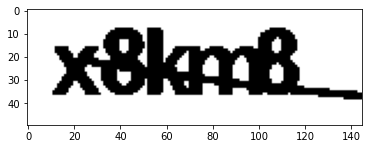

Original label:xm2xc     Predict label:xmb2x


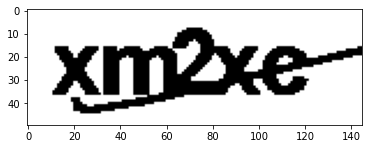

Original label:f26nm     Predict label:f26nd


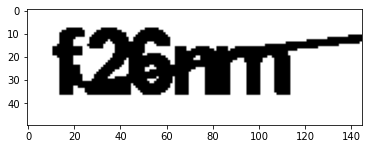

Original label:3f8ye     Predict label:3f83e


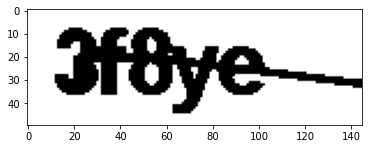

Original label:b3gfe     Predict label:brgfe


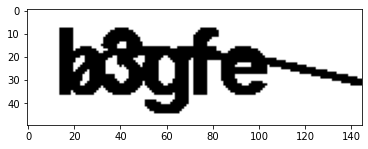

Original label:d3m8w     Predict label:d3m6w


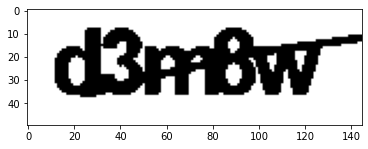

Original label:3w8k4     Predict label:3wrf4


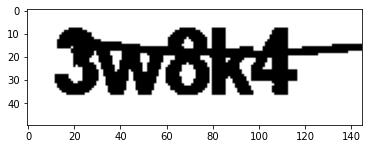

Original label:xenf3     Predict label:xenf8


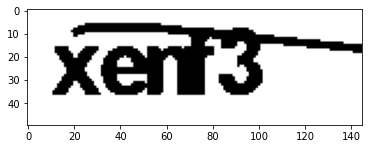

Original label:yep8x     Predict label:yex8x


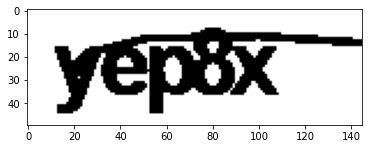

Original label:cgrhh     Predict label:cgrdh


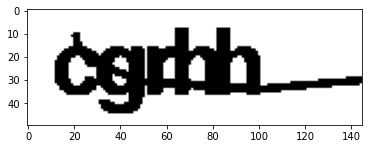

Original label:arpnr     Predict label:arpnx


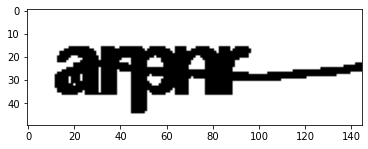

Original label:437rx     Predict label:437x7


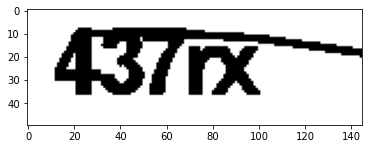

Original label:7whnn     Predict label:7whnm


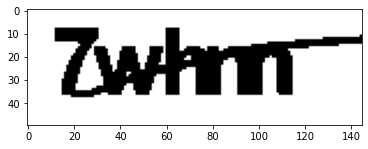

Original label:cwa6h     Predict label:cwcbh


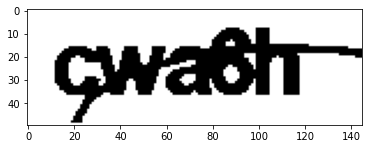

Original label:rfrd4     Predict label:r6dhk


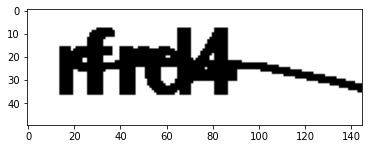

Original label:gm7xm     Predict label:ga57m


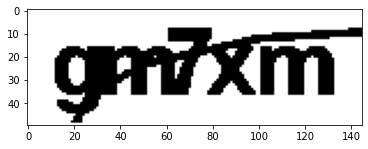

Original label:mnnk7     Predict label:mgadf


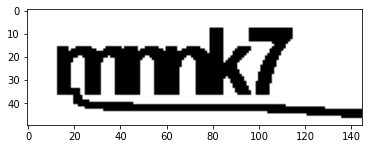

Original label:7r82d     Predict label:7re5k


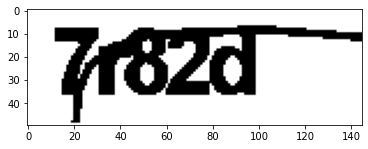

Original label:ge36p     Predict label:gc36p


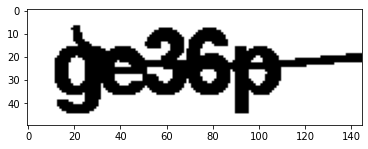

Original label:2depn     Predict label:2deph


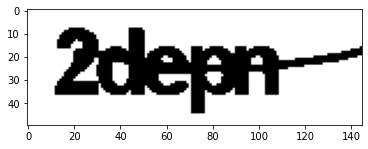

Original label:mpx7m     Predict label:mgad7


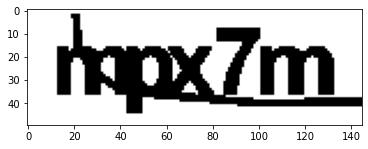

Original label:77wyh     Predict label:77ryb


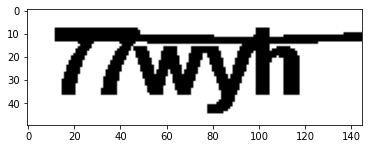

Original label:5f6w8     Predict label:5bww8


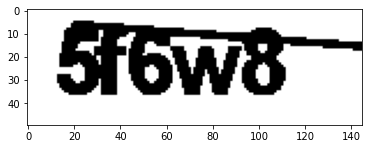

Original label:6gxca     Predict label:5gxaa


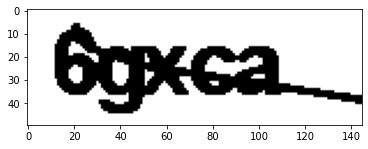

Original label:gyakm     Predict label:gyekp


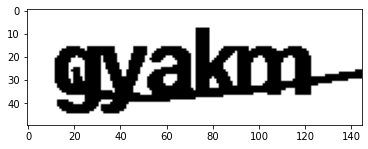

Original label:mpn5a     Predict label:mgm5a


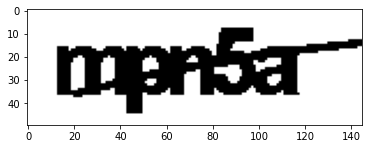

Original label:8rwey     Predict label:8wweg


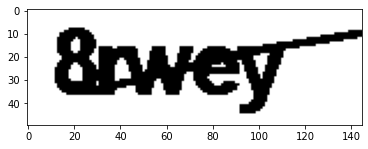

Original label:865m5     Predict label:865h5


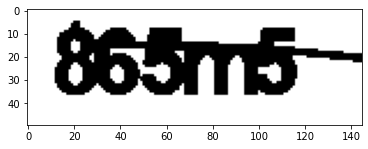

Original label:brcxm     Predict label:brcxa


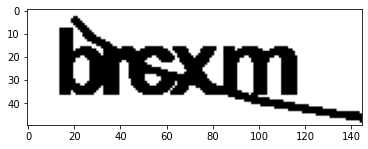

Original label:pw55f     Predict label:py555


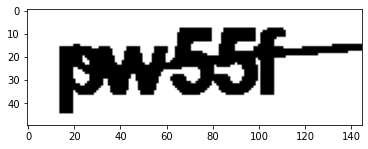

Original label:pygbn     Predict label:pygb8


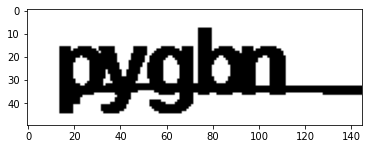

Original label:pwwee     Predict label:pwwwe


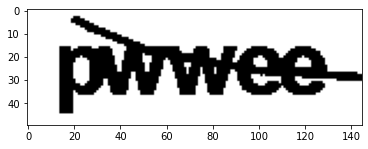

Original label:r3f52     Predict label:r8f2b


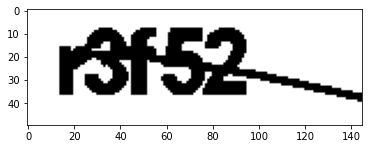

Original label:2ykr3     Predict label:2ydr3


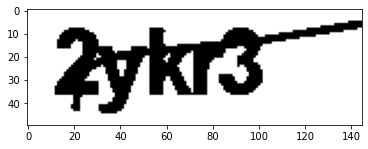

Original label:dyhg2     Predict label:dy4ge


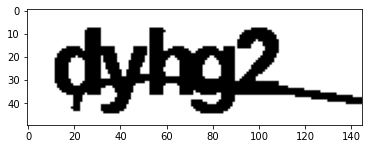

Original label:ydcxg     Predict label:ydrxg


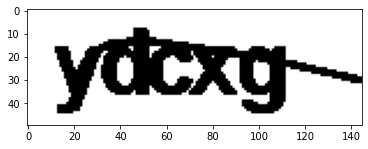

Original label:3re8c     Predict label:3re8e


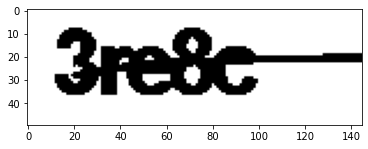

Original label:nxhfh     Predict label:nxhf8


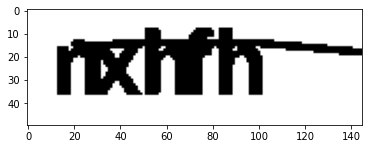

Original label:68erg     Predict label:68egp


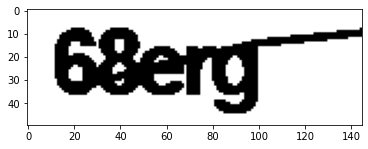

Original label:e5n5b     Predict label:e5b5b


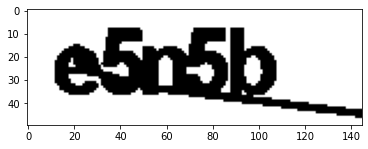

Original label:a5fda     Predict label:a5fka


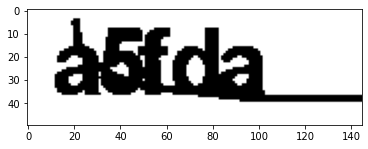

Original label:dhf63     Predict label:dhf3a


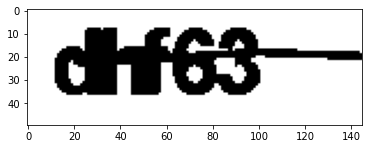

Original label:wkbhh     Predict label:w2hbh


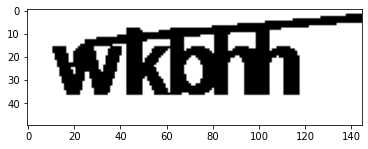

Original label:h8wff     Predict label:h8w3f


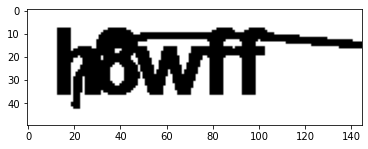

Original label:h84wh     Predict label:h88wh


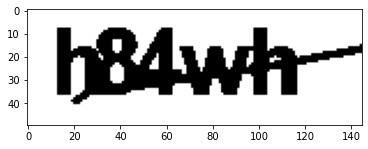

Original label:2yx85     Predict label:2yxe5


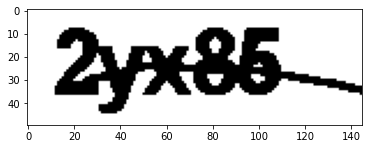

Original label:7rpah     Predict label:7rarn


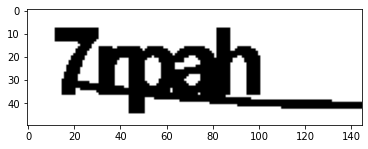

Original label:cpprp     Predict label:cppra


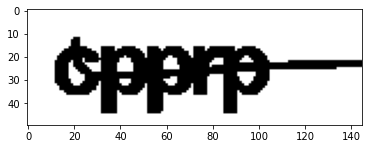

Original label:ex542     Predict label:2x542


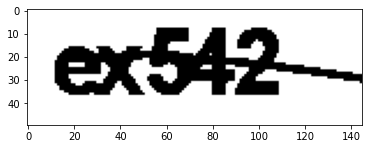

Original label:3wb7g     Predict label:3wrgg


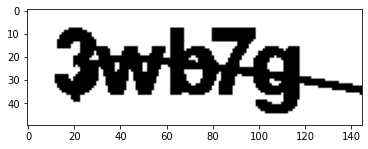

Original label:fwyce     Predict label:fky3e


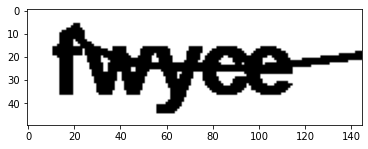

Original label:fg6wf     Predict label:fg6nf


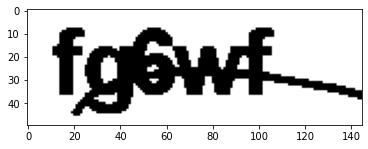

Original label:x2k7x     Predict label:x2k7k


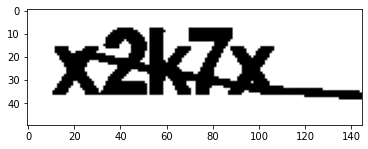

Original label:kwwbp     Predict label:hwyhb


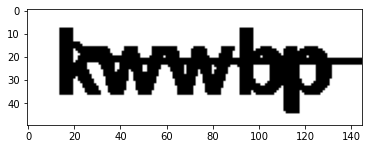

Original label:wyxnh     Predict label:wwxxh


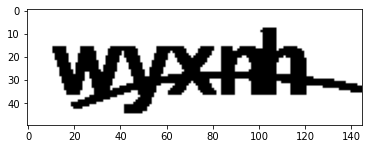

Original label:bgbxw     Predict label:bgpfw


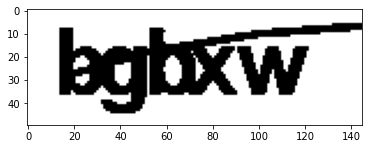

Original label:fhwc2     Predict label:fkrc2


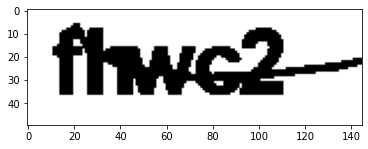

Original label:cweym     Predict label:cwygp


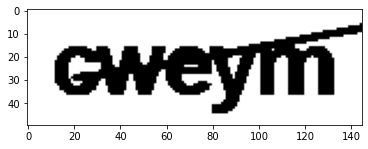

Original label:6kkyw     Predict label:6k8yw


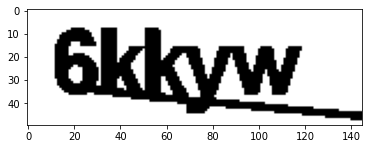

Original label:rrp6b     Predict label:ryxde


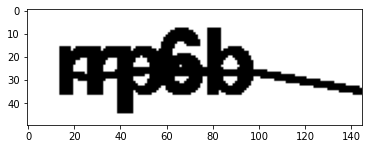

Original label:ecf5f     Predict label:ecf5m


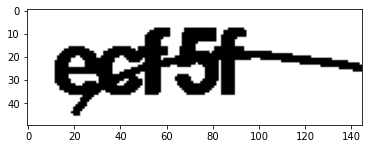

Original label:bg4nw     Predict label:bghdw


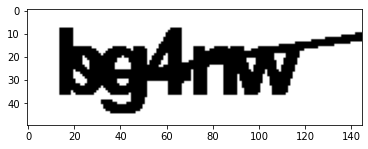

Original label:bcf8n     Predict label:bcf8m


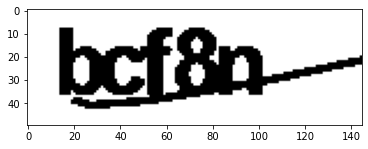

Original label:rxhf6     Predict label:rdff7


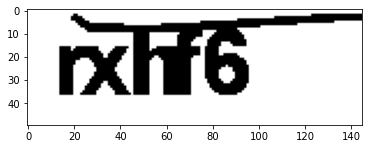

Original label:cwb46     Predict label:cwpa4


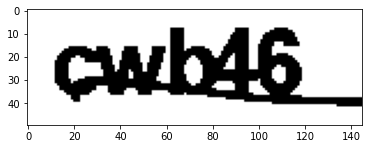

Original label:f4476     Predict label:f447b


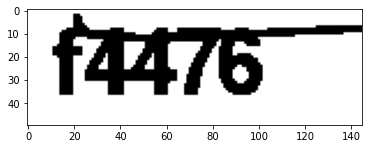

Original label:5hg82     Predict label:5kg62


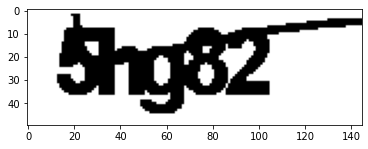

Original label:cn768     Predict label:c676f


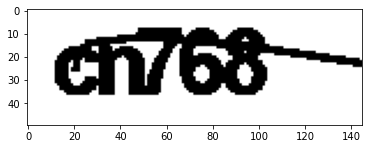

Original label:mp3d5     Predict label:maph5


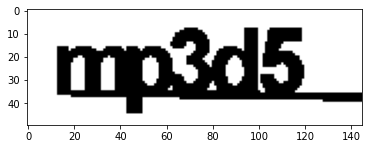

Original label:w2krg     Predict label:w2kng


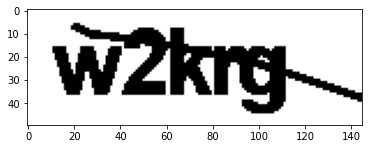

Original label:kx7he     Predict label:kx7be


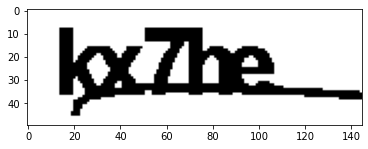

Original label:bxh5y     Predict label:bxb5y


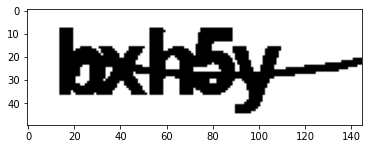

Original label:4mkgd     Predict label:4mkgg


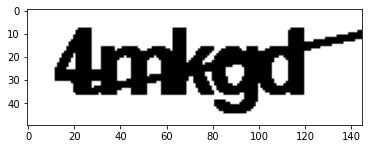

Original label:eynfc     Predict label:eyrfc


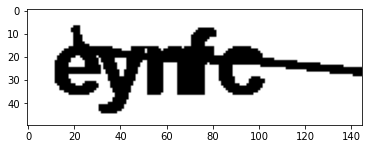

Original label:w6784     Predict label:w6774


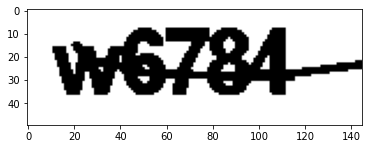

Original label:6ddr3     Predict label:6dbka


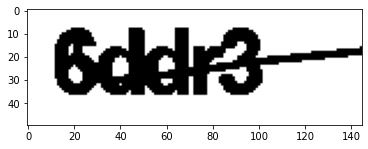

Original label:mpeew     Predict label:mgeew


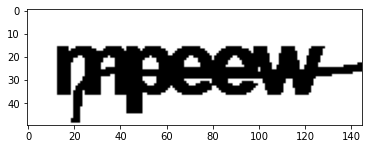

Original label:rm3gy     Predict label:ng2gw


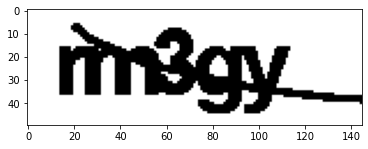

Original label:bgar3     Predict label:hgrf8


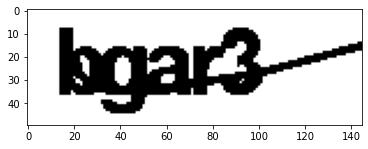

Original label:pxenx     Predict label:pxepx


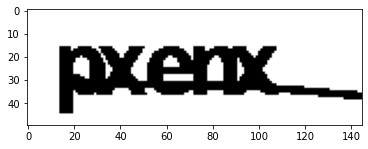

Original label:b4h36     Predict label:b4k36


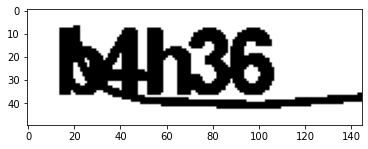

Original label:fn6c3     Predict label:fdr38


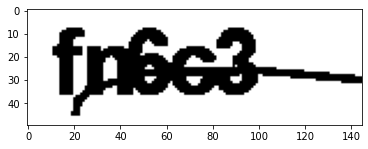

Original label:mnfw3     Predict label:mmyyr


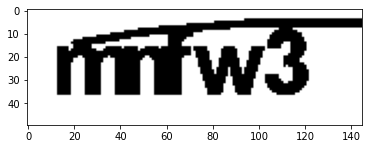

Original label:yr5dx     Predict label:yr5fx


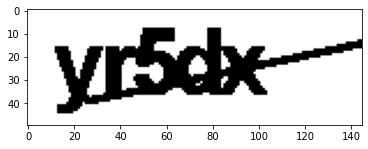

Original label:hnhdh     Predict label:hdbdh


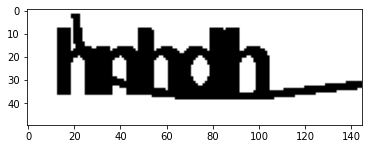

Original label:cm2kg     Predict label:cmk2g


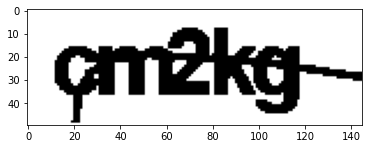

Original label:373pa     Predict label:373nw


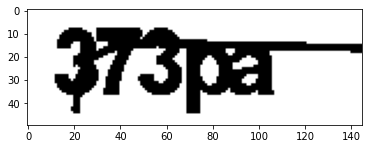

Original label:c7nkx     Predict label:c7rkx


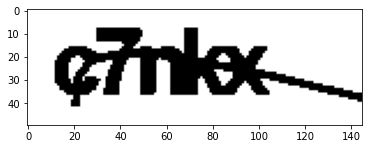

Original label:7m5r6     Predict label:7m5n6


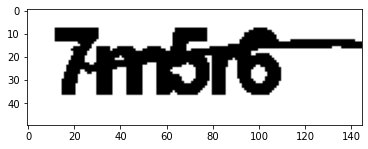

Original label:hkfgx     Predict label:hkfax


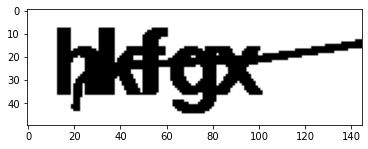

Original label:ycdhp     Predict label:ycdbp


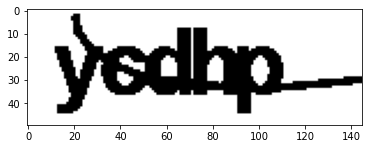

Original label:dfema     Predict label:dfmma


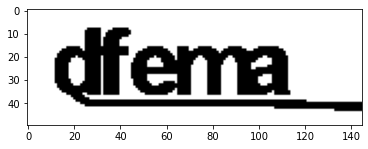

Original label:nbdpx     Predict label:nbdpc


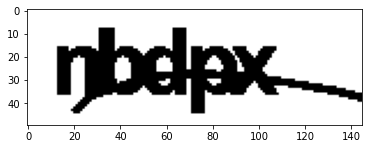

Original label:e3rhw     Predict label:e2mww


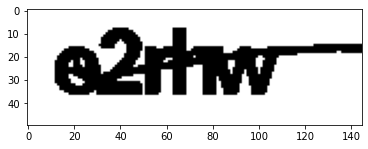

Original label:dp734     Predict label:dpk34


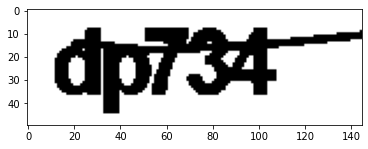

Original label:344b4     Predict label:344bh


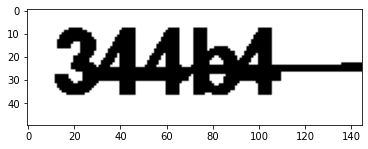

Original label:4dxwr     Predict label:4dxym


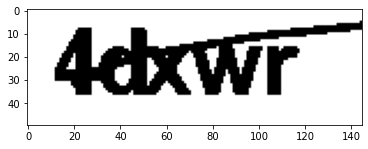

Original label:gadew     Predict label:gcdek


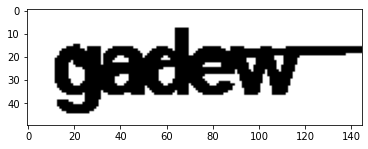

Original label:pwckp     Predict label:pwccp


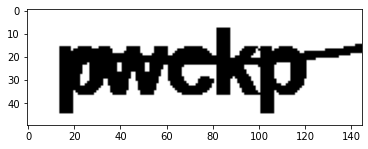

Original label:8b8nn     Predict label:8b8nm


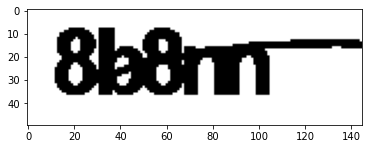

Original label:dd5a4     Predict label:dd5e4


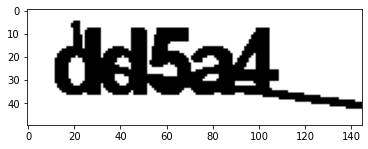

Original label:d6y8n     Predict label:d6ydf


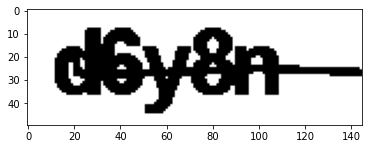

Original label:ncf68     Predict label:2cf68


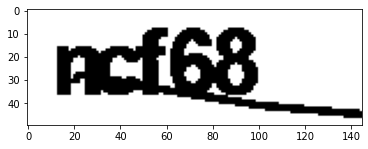

Original label:66yex     Predict label:66yek


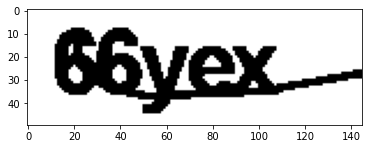

Original label:6cwd5     Predict label:6cw85


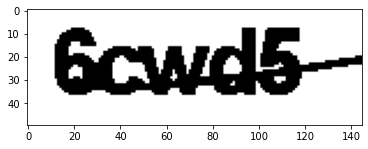

Original label:ragm5     Predict label:rayb2


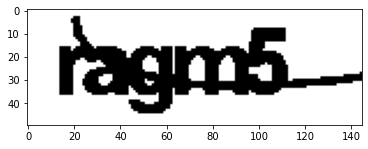

Original label:6nkr6     Predict label:6db6w


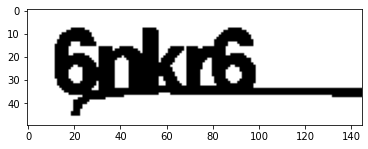

Original label:b8n47     Predict label:b8r47


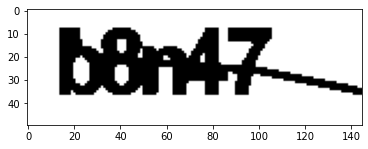

Original label:mw378     Predict label:mdy37


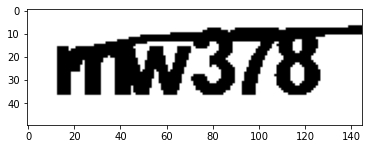

Original label:4n248     Predict label:4n246


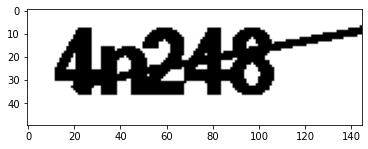

Original label:5rrng     Predict label:5rrgf


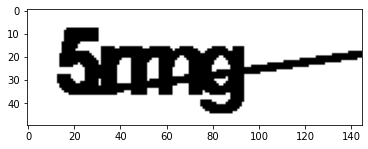

Original label:5b5hn     Predict label:5b5kn


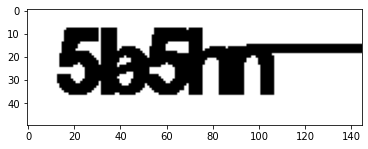

Original label:73pcx     Predict label:73pfx


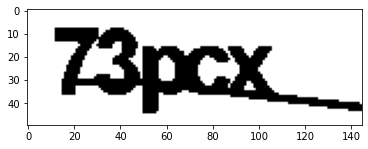

Original label:6ardx     Predict label:6arbx


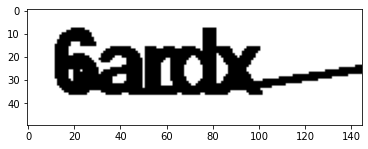

Original label:gaxdn     Predict label:gaxdh


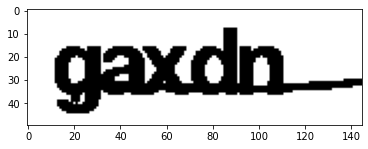

Original label:kb4w5     Predict label:kmwp5


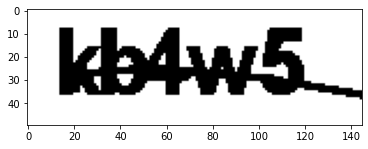

Original label:ypc54     Predict label:ypb5k


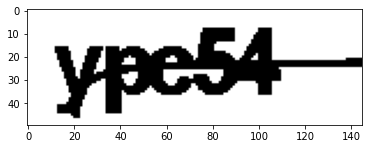

Original label:f67y2     Predict label:f6b32


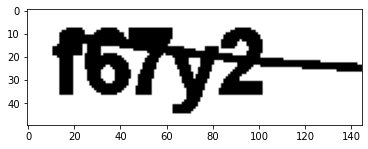

Original label:cefyc     Predict label:cefye


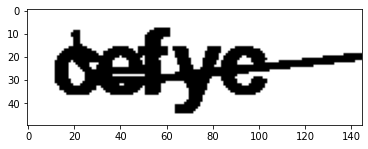

Original label:kma5c     Predict label:kmrbc


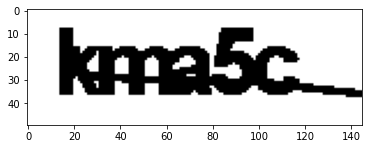

Original label:mna3e     Predict label:mm33e


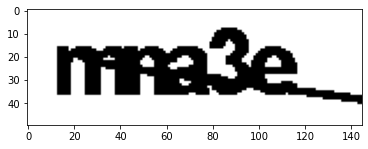

Original label:dbn3f     Predict label:dbr3f


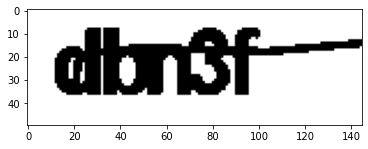

Original label:3hehx     Predict label:3hehk


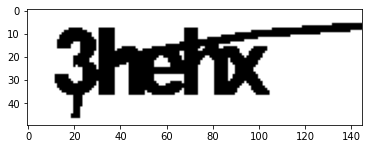

Original label:e6paf     Predict label:e6pwf


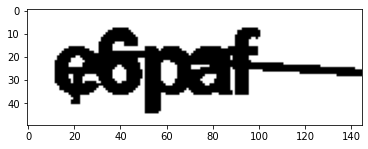

Original label:6ywmf     Predict label:6yymw


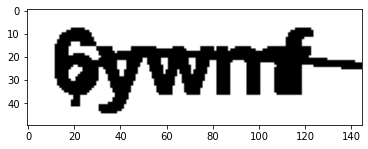

Original label:gr2rd     Predict label:gr2nk


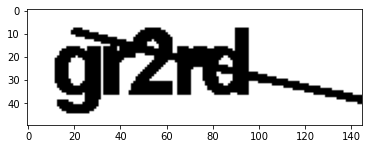

Original label:ya4ay     Predict label:ya4ey


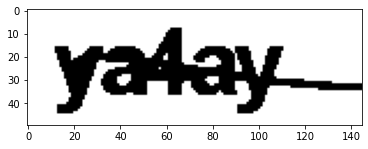

Original label:r7grn     Predict label:rgrb2


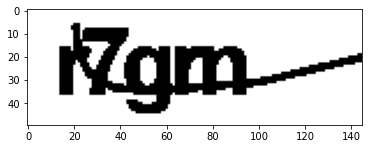

Original label:43dmy     Predict label:43dny


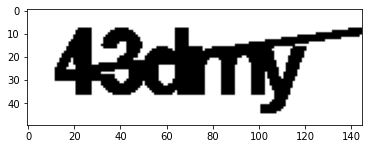

Original label:rhw8n     Predict label:mkxbf


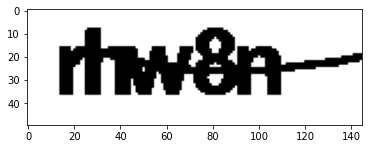

Original label:86xex     Predict label:86xek


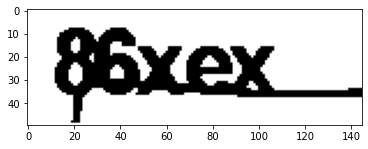

Original label:m6cd2     Predict label:m8kc2


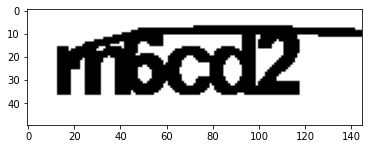

Original label:hpdkr     Predict label:hpdkn


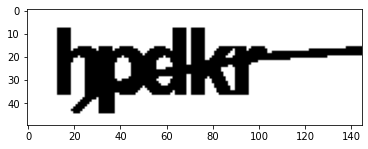

Original label:rbffc     Predict label:r8fca


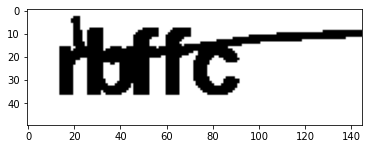

Original label:3fc8r     Predict label:3fpxr


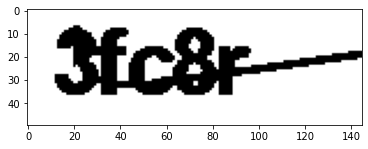

Original label:dfxwc     Predict label:dfwwc


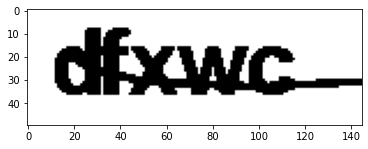

Original label:y4crh     Predict label:y4cah


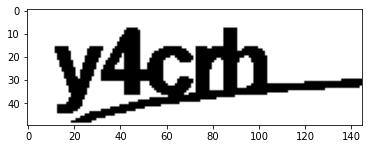

Original label:f4ycd     Predict label:f4pcd


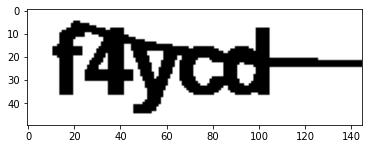

Original label:yf2gc     Predict label:yf8ge


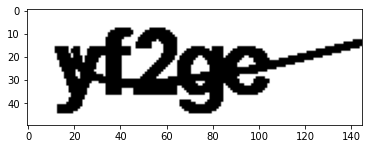

Original label:h8nr4     Predict label:h8nnh


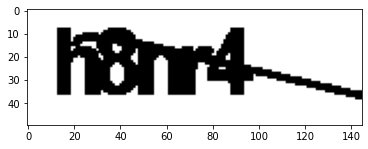

Original label:6pacx     Predict label:6pacw


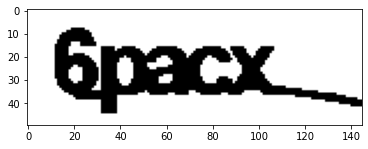

Original label:mr564     Predict label:mm564


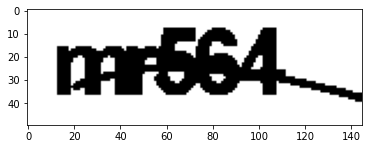

Original label:peab4     Predict label:peabm


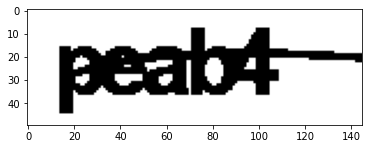

Original label:nahdn     Predict label:nahdh


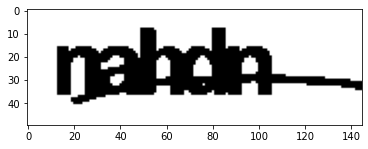

Original label:2amcf     Predict label:2am8c


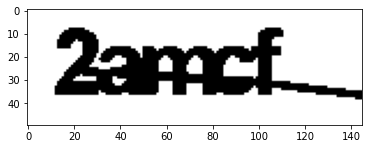

Original label:8b7kw     Predict label:8b7xw


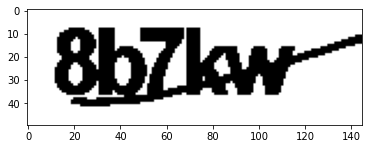

Total accuracy: 0.2700


In [276]:
count_2 = 0
for i in range(300):
    if Y_test_flatten_2[i*5] != Y_pred_flatten_2[i*5] or\
       Y_test_flatten_2[i*5+1] != Y_pred_flatten_2[i*5+1] or\
       Y_test_flatten_2[i*5+2] != Y_pred_flatten_2[i*5+2] or\
       Y_test_flatten_2[i*5+3] != Y_pred_flatten_2[i*5+3] or\
       Y_test_flatten_2[i*5+4] != Y_pred_flatten_2[i*5+4]:
        print("Original label:" +LETTERSTR[Y_test_flatten_2[i*5]]+
                                 LETTERSTR[Y_test_flatten_2[i*5+1]]+
                                 LETTERSTR[Y_test_flatten_2[i*5+2]]+
                                 LETTERSTR[Y_test_flatten_2[i*5+3]]+
                                 LETTERSTR[Y_test_flatten_2[i*5+4]], end='')
        print("     Predict label:" +LETTERSTR[Y_pred_flatten_2[i*5]]+
                                     LETTERSTR[Y_pred_flatten_2[i*5+1]]+
                                     LETTERSTR[Y_pred_flatten_2[i*5+2]]+
                                     LETTERSTR[Y_pred_flatten_2[i*5+3]]+
                                     LETTERSTR[Y_pred_flatten_2[i*5+4]])
        wrong_pic = (X_test[i].astype(np.float32))*255
        plt.imshow(wrong_pic, cmap='gray', vmin=0, vmax=255)
        plt.show()
        count_2 += 1

print("Total accuracy: %.4f" % float((300-count_2)/300))

總體test accuracy為27.00%  
test accuracy非常低，且遠低於first_model的63.37%

### 儲存second_model

In [277]:
second_model.save('./model/second_model.h5', 
            overwrite=True,
            include_optimizer=True,
            save_format='h5')

## <font color="#0000dd">second_model結論</font>
這個model雖然weight數較first_model多了5倍，但accuracy卻明顯下降，代表first_model accuracy沒辦法到很高不是因為dropout或max-pooling做太多的關係。而此model之所以accuracy會這麼低，我推測的原因為剛開始第一、二層Conv2D的kernel_size(2 * 2)太小，造成一開始的圖片就被模糊化太多的感覺，沒辦法明顯顯現出圖形的特徵.

---

## <font color="#0000dd">建third_model</font>
沿用first_model，CNN的架構都沒改變，唯一改變的是input data變多了，為了有更多input data，我又額外手動label了1100張驗證碼，所以在這個model共會有2600筆資料，再用這2600筆資料分割為train及test set

### 資料預處理
手動label完後，一樣照最剛開始的方式處理圖片及產生、分割dataset  
隨機分割20%(520筆)為test data、另外80%(1380筆)為train data

In [280]:
files = os.listdir('./data/label_data/')
i = 0
for im_name in files:
    im = cv2.imread('./data/label_data/' + im_name)
    #轉灰階
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #二值化
    ret, th1 = cv2.threshold(im, 177, 255, cv2.THRESH_BINARY);
    cv2.imwrite('./data/gray_data/'+ im_name, th1)
    
    #去除邊框
    im = Image.open('./data/gray_data/'+im_name)
    width, height = im.size
    pixels = im.load()
    for x in range(0, width):
        for y in range(0, height):
            if x < 5 or x > width - 10:
                pixels[x, y] = 255
            if y < 2 or y > height -2:
                pixels[x, y] = 255
    
    #切掉右邊沒數字部分
    crop_img = im.crop((0, 0, 145, height))
    crop_img.save('./data/gray_data/'+im_name)

w, h = crop_img.size        
print("New image size: (", h, w, ")\n")

files = os.listdir('./data/gray_data/')
X = np.empty((0,50,145,1), int)
Y = np.empty((0,5,23), int)
for im_name in files:
    cur_features = np.asarray(Image.open('./data/gray_data/' + im_name))
    cur_features = np.reshape(cur_features, (50, 145, 1))
    cur_features = (cur_features.astype(np.float32))/255
    X = np.vstack([X, [cur_features]])
    
    labels = im_name.split(".")[0]
    cur_labels = np.empty((0,23), int)
    for i in range(5):
        label = toonehot(labels[i])
        cur_labels = np.append(cur_labels, [label], axis=0)
    Y = np.append(Y, [cur_labels], axis=0)

print("Original X shape:", X.shape)
print("Original Y shape:", Y.shape,"\n")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print("X_train shape:", X_train.shape)
print("Y_train shape:",  Y_train.shape)
print("X_test shape:",  X_test.shape)
print("Y_test shape:", Y_test.shape, "\n")

Y_train_1 = Y_train[:,0,:]
Y_train_2 = Y_train[:,1,:]
Y_train_3 = Y_train[:,2,:]
Y_train_4 = Y_train[:,3,:]
Y_train_5 = Y_train[:,4,:]

Y_test_1 = Y_test[:,0,:]
Y_test_2 = Y_test[:,1,:]
Y_test_3 = Y_test[:,2,:]
Y_test_4 = Y_test[:,3,:]
Y_test_5 = Y_test[:,4,:]

print("Y_train_1 shape:",  Y_train_1.shape)
print("Y_test_1 shape:",  Y_test_1.shape)

New image size: ( 50 145 )

Original X shape: (2600, 50, 145, 1)
Original Y shape: (2600, 5, 23) 

X_train shape: (2080, 50, 145, 1)
Y_train shape: (2080, 5, 23)
X_test shape: (520, 50, 145, 1)
Y_test shape: (520, 5, 23) 

Y_train_1 shape: (2080, 23)
Y_test_1 shape: (520, 23)


<center>共2600筆資料，沒有label重複的資料<center/>
<img src="./report_pic/data_2600.png"  width="600" height="460">

### 建立third_model
架構跟first_model一模一樣

In [295]:
#input layer
inputs = tf.keras.layers.Input(shape=(50,145,1))
outputs = inputs

#第一層Conv2D
outputs = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv_1')(outputs)

#第二層Conv2D
outputs = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv_2')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)

#第三層Conv2D
outputs = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv_3')(outputs)

#第四層Conv2D
outputs = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv_4')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)

#第五層Conv2D
out = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv_5')(outputs)

#第六層Conv2D
outputs = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv_6')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)

#第七層Conv2D
outputs = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv_7')(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.MaxPooling2D((2, 2))(outputs)
outputs = tf.keras.layers.Flatten()(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)

#output layer
outputs = [tf.keras.layers.Dense(23, name='digit1', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit2', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit3', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit4', activation='softmax')(outputs),\
    tf.keras.layers.Dense(23, name='digit5', activation='softmax')(outputs)]

third_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
third_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
third_model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 50, 145, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 50, 145, 32)  320         input_23[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 50, 145, 32)  9248        conv_1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 50, 145, 32)  128         conv_2[0][0]                     
___________________________________________________________________________________________

共有1,229,971個weight要train

### Train third_model
將training dataset丟進model做training，分20%training data為validation，batch_size設為32，並做100次epochs  
由於上一個model在大約70個epochs就train的差不多，這次model的weight數一樣、data數較多，所以我就設epochs數100

In [296]:
history_3 = third_model.fit(X_train, (Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5), 
                    shuffle=True, epochs=100, 
                    batch_size = 32, validation_split=0.2, 
                    verbose=1)

Train on 1664 samples, validate on 416 samples
Epoch 1/100
1664/1664 [==============================] - 7s 4ms/sample - loss: 25.1865 - digit1_loss: 4.6648 - digit2_loss: 5.0756 - digit3_loss: 5.1561 - digit4_loss: 5.2153 - digit5_loss: 5.0748 - digit1_accuracy: 0.1376 - digit2_accuracy: 0.1058 - digit3_accuracy: 0.0998 - digit4_accuracy: 0.0793 - digit5_accuracy: 0.0986 - val_loss: 23.1245 - val_digit1_loss: 5.4759 - val_digit2_loss: 4.4391 - val_digit3_loss: 4.0713 - val_digit4_loss: 4.5528 - val_digit5_loss: 4.5853 - val_digit1_accuracy: 0.0577 - val_digit2_accuracy: 0.0601 - val_digit3_accuracy: 0.0505 - val_digit4_accuracy: 0.0433 - val_digit5_accuracy: 0.0337
Epoch 2/100
1664/1664 [==============================] - 3s 2ms/sample - loss: 14.4520 - digit1_loss: 1.9636 - digit2_loss: 2.7246 - digit3_loss: 3.1338 - digit4_loss: 3.3250 - digit5_loss: 3.3051 - digit1_accuracy: 0.4555 - digit2_accuracy: 0.2794 - digit3_accuracy: 0.2512 - digit4_accuracy: 0.2055 - digit5_accuracy: 0.2314

1664/1664 [==============================] - 4s 2ms/sample - loss: 0.3967 - digit1_loss: 0.0139 - digit2_loss: 0.0495 - digit3_loss: 0.1071 - digit4_loss: 0.1435 - digit5_loss: 0.0826 - digit1_accuracy: 0.9946 - digit2_accuracy: 0.9826 - digit3_accuracy: 0.9669 - digit4_accuracy: 0.9537 - digit5_accuracy: 0.9736 - val_loss: 3.9024 - val_digit1_loss: 0.0677 - val_digit2_loss: 0.4480 - val_digit3_loss: 1.0975 - val_digit4_loss: 1.3357 - val_digit5_loss: 0.9536 - val_digit1_accuracy: 0.9856 - val_digit2_accuracy: 0.8918 - val_digit3_accuracy: 0.7764 - val_digit4_accuracy: 0.7644 - val_digit5_accuracy: 0.8005
Epoch 15/100
1664/1664 [==============================] - 4s 2ms/sample - loss: 0.4210 - digit1_loss: 0.0244 - digit2_loss: 0.0482 - digit3_loss: 0.0944 - digit4_loss: 0.1869 - digit5_loss: 0.0671 - digit1_accuracy: 0.9922 - digit2_accuracy: 0.9832 - digit3_accuracy: 0.9694 - digit4_accuracy: 0.9423 - digit5_accuracy: 0.9736 - val_loss: 2.6240 - val_digit1_loss: 0.0260 - val_digit2_lo

1664/1664 [==============================] - 4s 2ms/sample - loss: 0.1284 - digit1_loss: 0.0066 - digit2_loss: 0.0123 - digit3_loss: 0.0356 - digit4_loss: 0.0407 - digit5_loss: 0.0332 - digit1_accuracy: 0.9988 - digit2_accuracy: 0.9952 - digit3_accuracy: 0.9880 - digit4_accuracy: 0.9874 - digit5_accuracy: 0.9904 - val_loss: 3.8836 - val_digit1_loss: 0.0257 - val_digit2_loss: 0.4546 - val_digit3_loss: 0.9203 - val_digit4_loss: 1.7090 - val_digit5_loss: 0.7741 - val_digit1_accuracy: 0.9904 - val_digit2_accuracy: 0.9399 - val_digit3_accuracy: 0.8726 - val_digit4_accuracy: 0.8245 - val_digit5_accuracy: 0.8726
Epoch 41/100
1664/1664 [==============================] - 4s 2ms/sample - loss: 0.1526 - digit1_loss: 0.0069 - digit2_loss: 0.0280 - digit3_loss: 0.0130 - digit4_loss: 0.0756 - digit5_loss: 0.0291 - digit1_accuracy: 0.9976 - digit2_accuracy: 0.9946 - digit3_accuracy: 0.9946 - digit4_accuracy: 0.9796 - digit5_accuracy: 0.9928 - val_loss: 3.0359 - val_digit1_loss: 0.0140 - val_digit2_lo

1664/1664 [==============================] - 4s 2ms/sample - loss: 0.1576 - digit1_loss: 0.0025 - digit2_loss: 0.0332 - digit3_loss: 0.0486 - digit4_loss: 0.0264 - digit5_loss: 0.0470 - digit1_accuracy: 0.9988 - digit2_accuracy: 0.9916 - digit3_accuracy: 0.9880 - digit4_accuracy: 0.9892 - digit5_accuracy: 0.9886 - val_loss: 3.9174 - val_digit1_loss: 0.0691 - val_digit2_loss: 0.2674 - val_digit3_loss: 1.3391 - val_digit4_loss: 1.7799 - val_digit5_loss: 0.4619 - val_digit1_accuracy: 0.9856 - val_digit2_accuracy: 0.9663 - val_digit3_accuracy: 0.8846 - val_digit4_accuracy: 0.8558 - val_digit5_accuracy: 0.9327
Epoch 67/100
1664/1664 [==============================] - 4s 2ms/sample - loss: 0.1502 - digit1_loss: 0.0022 - digit2_loss: 0.0220 - digit3_loss: 0.0630 - digit4_loss: 0.0382 - digit5_loss: 0.0246 - digit1_accuracy: 0.9988 - digit2_accuracy: 0.9928 - digit3_accuracy: 0.9796 - digit4_accuracy: 0.9904 - digit5_accuracy: 0.9916 - val_loss: 4.2864 - val_digit1_loss: 0.0214 - val_digit2_lo

1664/1664 [==============================] - 4s 2ms/sample - loss: 0.1099 - digit1_loss: 2.4153e-04 - digit2_loss: 0.0100 - digit3_loss: 0.0394 - digit4_loss: 0.0353 - digit5_loss: 0.0249 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9964 - digit3_accuracy: 0.9904 - digit4_accuracy: 0.9904 - digit5_accuracy: 0.9946 - val_loss: 4.2990 - val_digit1_loss: 0.0153 - val_digit2_loss: 0.7186 - val_digit3_loss: 1.0490 - val_digit4_loss: 1.8931 - val_digit5_loss: 0.6230 - val_digit1_accuracy: 0.9904 - val_digit2_accuracy: 0.9423 - val_digit3_accuracy: 0.9014 - val_digit4_accuracy: 0.8726 - val_digit5_accuracy: 0.9135
Epoch 93/100
1664/1664 [==============================] - 4s 2ms/sample - loss: 0.0891 - digit1_loss: 7.4871e-04 - digit2_loss: 0.0454 - digit3_loss: 0.0167 - digit4_loss: 0.0221 - digit5_loss: 0.0041 - digit1_accuracy: 0.9994 - digit2_accuracy: 0.9928 - digit3_accuracy: 0.9958 - digit4_accuracy: 0.9928 - digit5_accuracy: 0.9976 - val_loss: 4.3130 - val_digit1_loss: 0.0151 - val_d

在我的電腦做訓練，一個epoch大約要花4秒，所以共要花約7分鐘完成訓練

### 觀察third_model結果

#### training及validation learning curve
分別畫epochs v.s. loss及accuracy圖

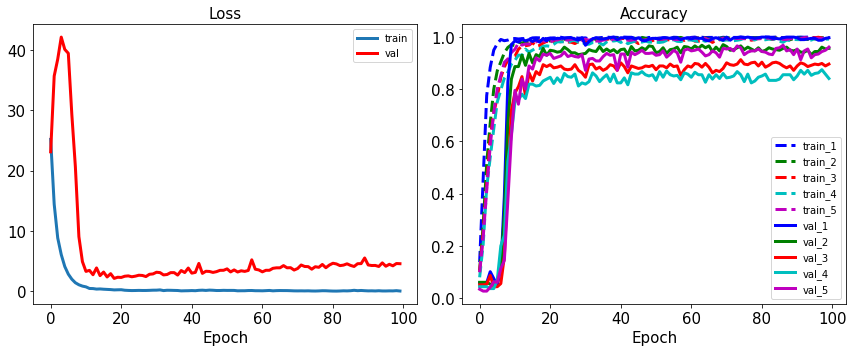

In [297]:
hist_3 = history_3.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist_3['loss'], lw=3, label="train")
ax.plot(hist_3['val_loss'], 'r', lw=3, label="val")
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc="upper right")

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist_3['digit1_accuracy'], 'b--', lw=3, label="train_1")
ax.plot(hist_3['digit2_accuracy'], 'g--', lw=3, label="train_2")
ax.plot(hist_3['digit3_accuracy'], 'r--', lw=3, label="train_3")
ax.plot(hist_3['digit4_accuracy'], 'c--', lw=3, label="train_4")
ax.plot(hist_3['digit5_accuracy'], 'm--', lw=3, label="train_5")
ax.plot(hist_3['val_digit1_accuracy'], 'b', lw=3, label="val_1")
ax.plot(hist_3['val_digit2_accuracy'], 'g', lw=3, label="val_2")
ax.plot(hist_3['val_digit3_accuracy'], 'r', lw=3, label="val_3")
ax.plot(hist_3['val_digit4_accuracy'], 'c', lw=3, label="val_4")
ax.plot(hist_3['val_digit5_accuracy'], 'm', lw=3, label="val_5")
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.legend(loc="lower right")

plt.show()

由上圖可以得知
1. validation loss在大約40個epochs後會越train越大，代表有over-fitting產生了  
2. training accuracy在大約10個epochs後就都趨於穩定，而validation acccuracy則是緩慢上升到約20個epochs後才來到最高點，但在那時loss是緩慢提升，可能為over-fitting現象
3. 其中training accuracy都近乎100%，而validation accuracy則介於約80~100%之間

#### test accuracy
分別計算5個digits的test accuracy

In [293]:
results = third_model.evaluate(X_test, (Y_test_1,Y_test_2,Y_test_3,Y_test_4,Y_test_5), batch_size=200, verbose=1)
print('\nTest loss: %.4f' % results[0])
print("Digit 1 test accuracy: %.4f" % results[6])
print("Digit 2 test accuracy: %.4f" % results[7])
print("Digit 3 test accuracy: %.4f" % results[8])
print("Digit 4 test accuracy: %.4f" % results[9])
print("Digit 5 test accuracy: %.4f" % results[10])

520/520 [==============================] - 1s 2ms/sample - loss: 5.2519 - digit1_loss: 0.1265 - digit2_loss: 0.6441 - digit3_loss: 1.2700 - digit4_loss: 2.3828 - digit5_loss: 0.9424 - digit1_accuracy: 0.9846 - digit2_accuracy: 0.9385 - digit3_accuracy: 0.8731 - digit4_accuracy: 0.8231 - digit5_accuracy: 0.9000

Test loss: 5.2519
Digit 1 test accuracy: 0.9846
Digit 2 test accuracy: 0.9385
Digit 3 test accuracy: 0.8731
Digit 4 test accuracy: 0.8231
Digit 5 test accuracy: 0.9000


五個digits test accuracy分別為：98.46%、93.85%、87.31%、82.31%、90.00%  
最低accuracy也有82%、最高98%，表現相當不錯

#### confusion matrix
畫出confusion matrix

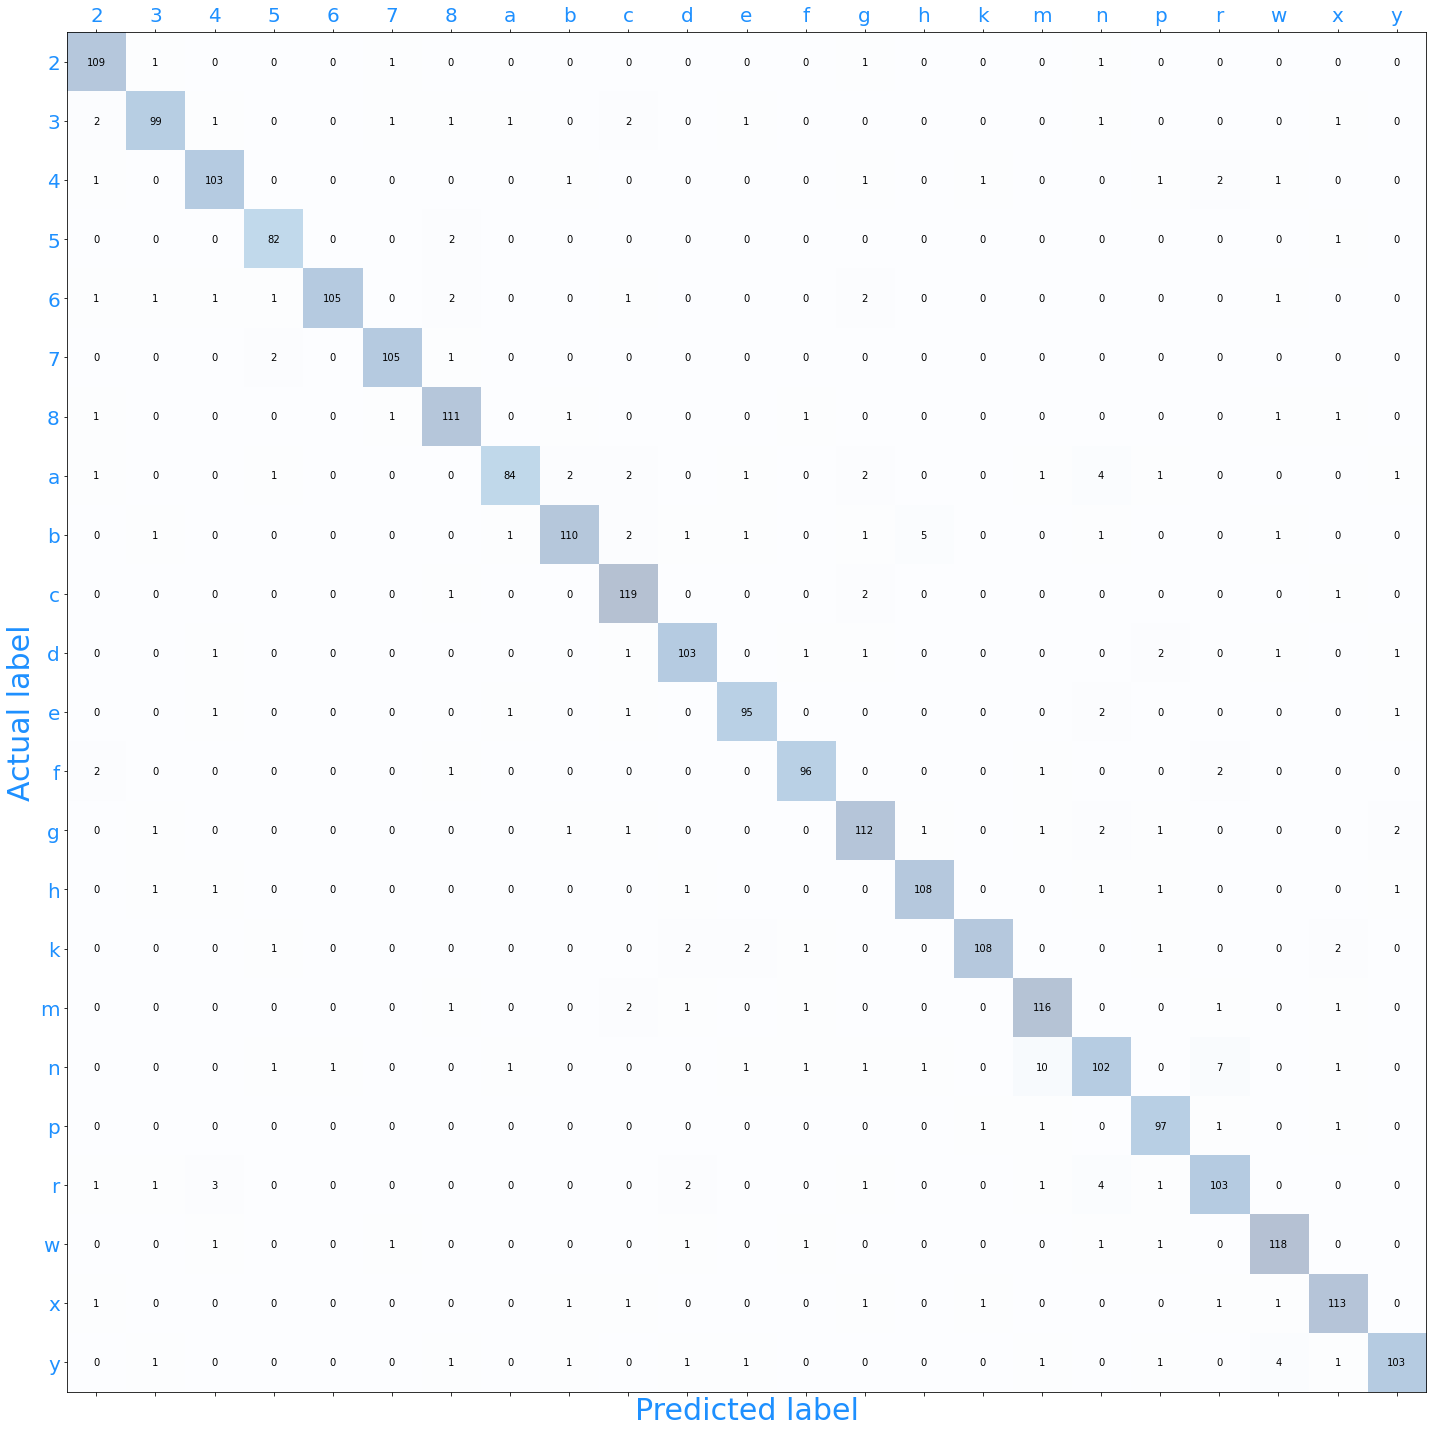

In [308]:
Y_pred_3 = third_model.predict(X_test)

Y_pred_flatten_3 = np.empty((0,23), int)
for i in range(520):
    for j in range(5):
        Y_pred_flatten_3 = np.vstack([Y_pred_flatten_3,Y_pred_3[j][i]])

Y_pred_flatten_3 = np.argmax(Y_pred_flatten_3,axis = 1)

Y_test_flatten_3 = np.reshape(Y_test, (2600, 23))
Y_test_flatten_3 = np.argmax(Y_test_flatten_3,axis = 1)


confmat = confusion_matrix(y_true=Y_test_flatten_3, y_pred=Y_pred_flatten_3)
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label', fontsize=30, c='dodgerblue')
plt.ylabel('Actual label', fontsize=30, c='dodgerblue')

plt.xticks(np.arange(23) ,list(LETTERSTR), fontsize=20, c='dodgerblue')
plt.yticks(np.arange(23), list(LETTERSTR), fontsize=20, c='dodgerblue')

plt.tight_layout()
plt.savefig('./report_pic/third_model_conufusion_matrix.png')
plt.show()

predict錯誤的地方較為分散，幾乎都是單獨1筆或2筆，可能原因為data數太少，所以無法明顯觀察  
而predict錯最多的為n被predict成m，次數為10次，跟second_model一樣這部分錯比較多

#### print predict錯誤的data並觀察

Original label:rknag     Predict label:rkngg


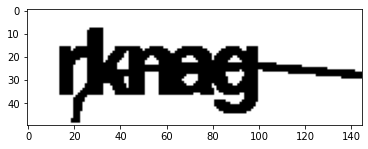

Original label:rerea     Predict label:rerep


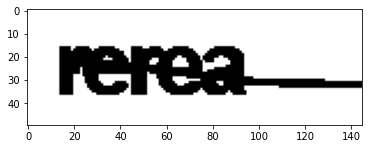

Original label:4mkgd     Predict label:4mxgd


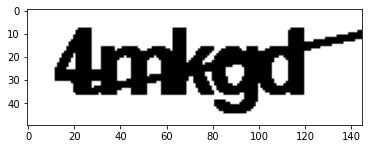

Original label:w2f4d     Predict label:w224d


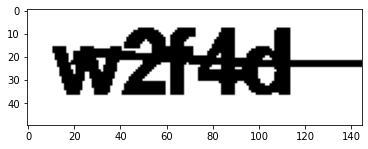

Original label:5epmy     Predict label:5epmw


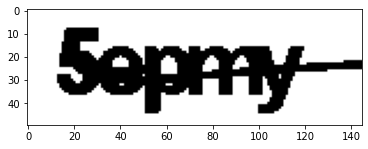

Original label:myn6a     Predict label:mpmga


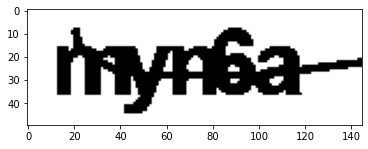

Original label:6wxp3     Predict label:6wbx3


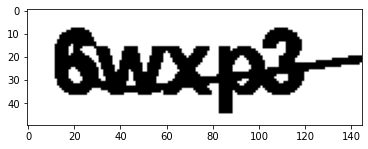

Original label:whabm     Predict label:wh5bm


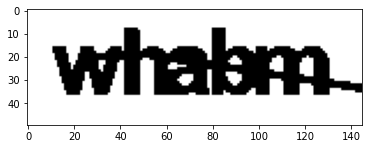

Original label:xm2xc     Predict label:xrn2c


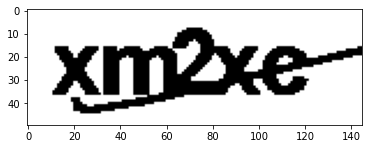

Original label:mpw8c     Predict label:mppw8


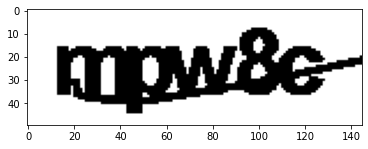

Original label:dw8n6     Predict label:dw8g6


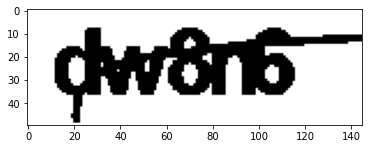

Original label:f24xn     Predict label:f24xm


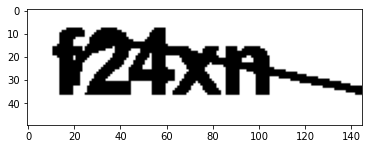

Original label:mhbeb     Predict label:mhheb


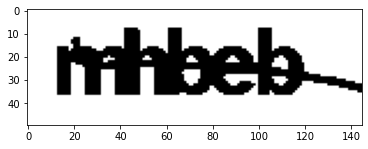

Original label:hmrrg     Predict label:hmnrg


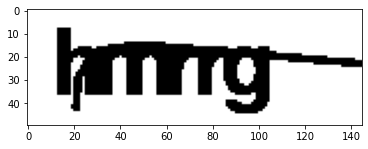

Original label:c3meh     Predict label:c3med


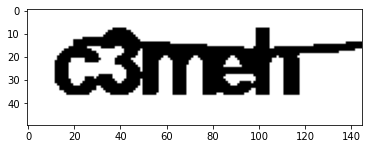

Original label:mna3e     Predict label:mmn2e


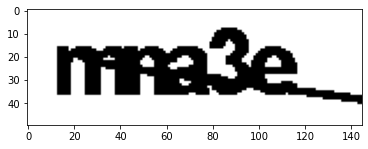

Original label:f7r58     Predict label:f7r88


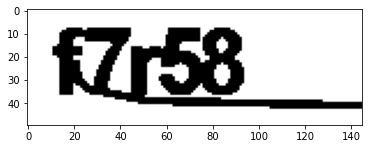

Original label:mpdkf     Predict label:mppdf


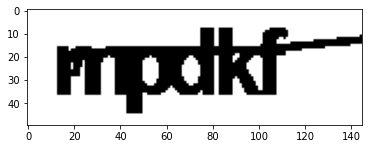

Original label:w3ew4     Predict label:w3e44


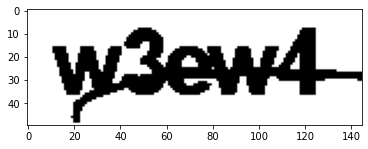

Original label:nywp6     Predict label:nywr6


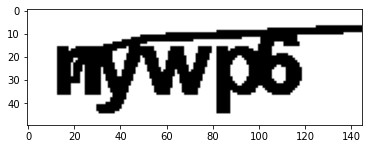

Original label:2wn2p     Predict label:2wm2p


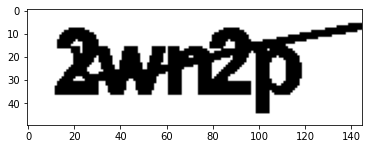

Original label:w7whp     Predict label:w774p


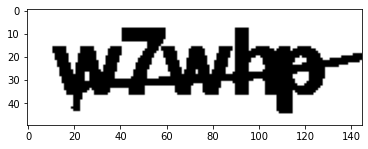

Original label:wdca8     Predict label:wdcc8


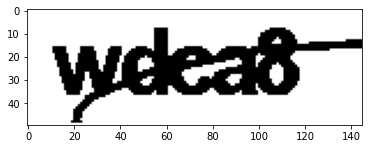

Original label:r3232     Predict label:r3332


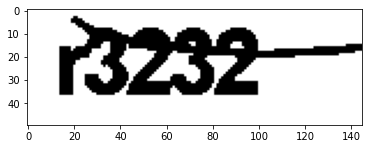

Original label:n2bb2     Predict label:n2bc2


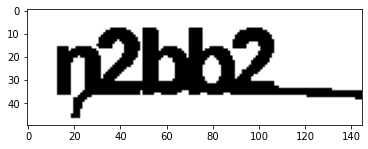

Original label:wkgbx     Predict label:wdgbx


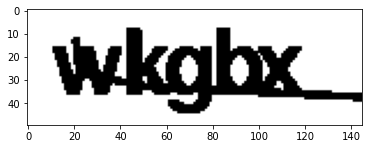

Original label:mygba     Predict label:mdygb


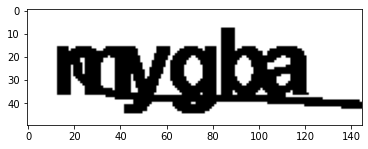

Original label:fcxmx     Predict label:fcgmx


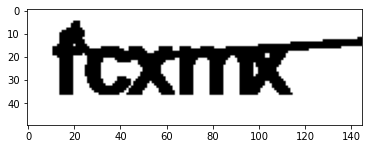

Original label:wb8p8     Predict label:wbbp8


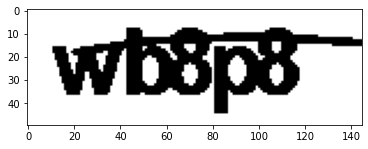

Original label:pgd6c     Predict label:pgdgc


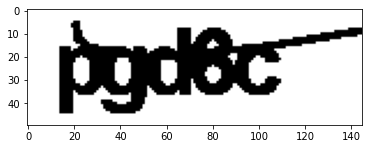

Original label:b8n47     Predict label:b8r47


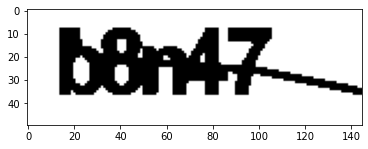

Original label:5f6w8     Predict label:5f5w8


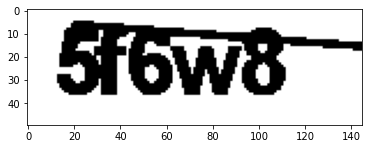

Original label:xm463     Predict label:xmb43


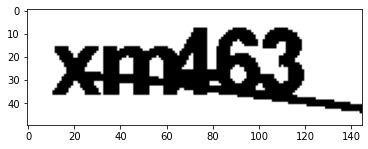

Original label:wr45r     Predict label:wnr5r


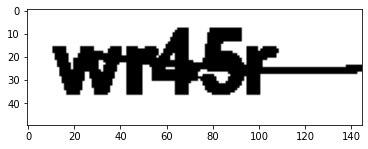

Original label:bwcgx     Predict label:bwccx


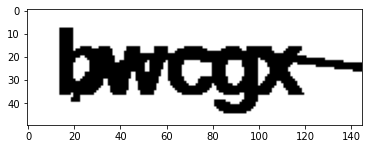

Original label:mhg4f     Predict label:mhhgf


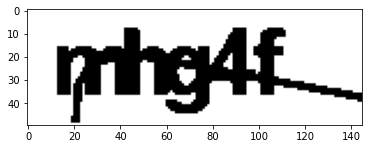

Original label:wpry8     Predict label:wppy8


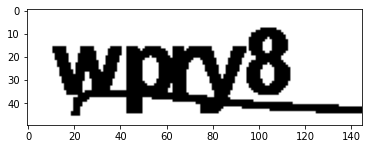

Original label:rfrd4     Predict label:rrd4w


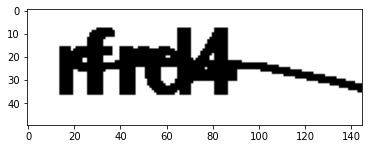

Original label:w2fw8     Predict label:w22f8


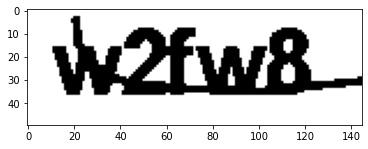

Original label:4nbd3     Predict label:4nbc3


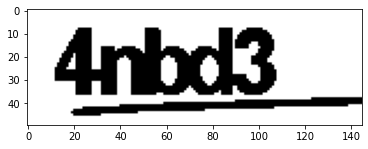

Original label:wxa3x     Predict label:wxaax


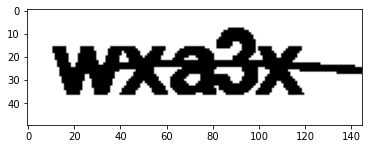

Original label:krfxk     Predict label:krfwk


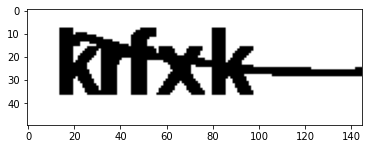

Original label:wpk3x     Predict label:wppcx


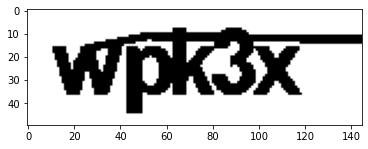

Original label:gcpmh     Predict label:gcpch


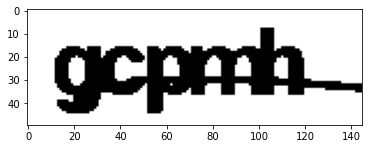

Original label:m7n26     Predict label:m7m26


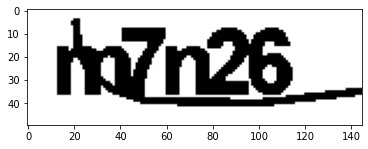

Original label:exrkp     Predict label:cxrkp


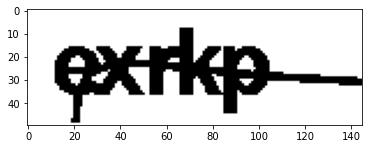

Original label:b5fnw     Predict label:b5frw


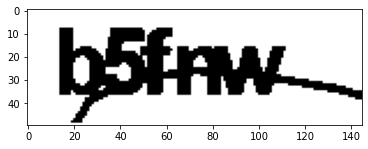

Original label:wnhbh     Predict label:wmnnh


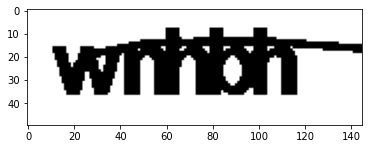

Original label:38fn7     Predict label:38fr5


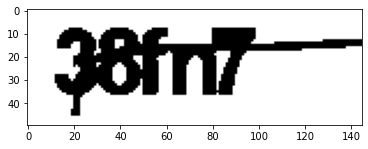

Original label:2pdr2     Predict label:2pd22


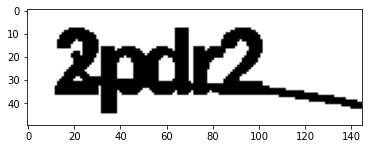

Original label:pwyep     Predict label:pwyyp


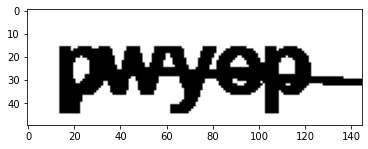

Original label:78bcc     Predict label:78hcc


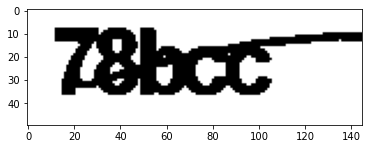

Original label:fhbex     Predict label:fheex


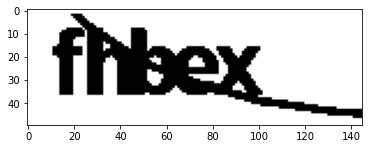

Original label:3mm4r     Predict label:3mmr4


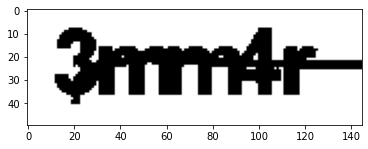

Original label:emrgw     Predict label:emngw


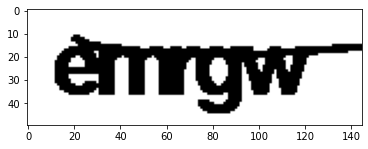

Original label:mekx5     Predict label:meek5


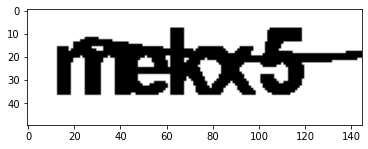

Original label:w4enp     Predict label:w44np


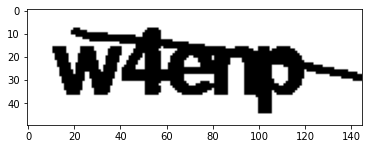

Original label:wngfb     Predict label:wmnfb


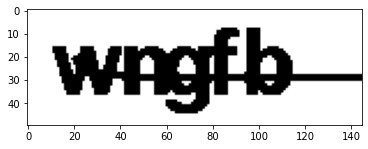

Original label:gw3ry     Predict label:gw33y


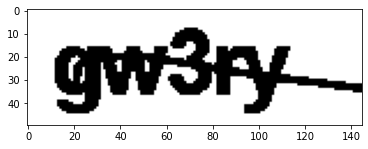

Original label:f7w3c     Predict label:f7n3c


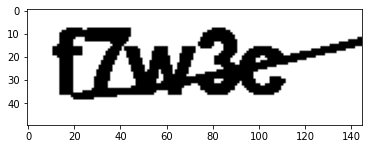

Original label:ymrgg     Predict label:ymngg


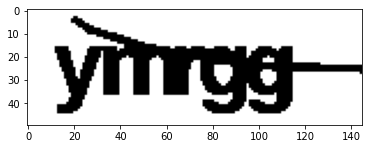

Original label:xf2hn     Predict label:xf2hm


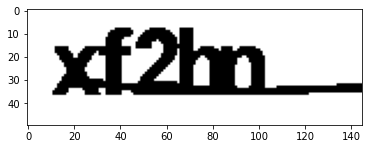

Original label:kwm3y     Predict label:kwmc3


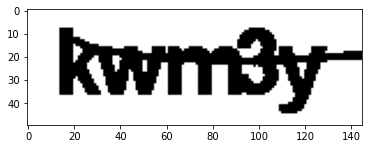

Original label:a5wmg     Predict label:a5wmm


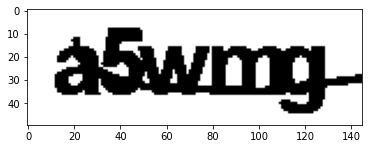

Original label:mnawe     Predict label:mrnwe


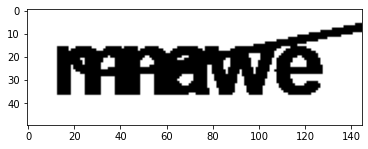

Original label:6xrg8     Predict label:6xrp8


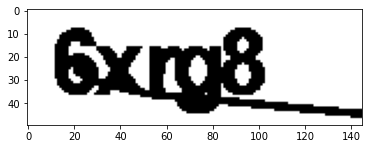

Original label:rrrg3     Predict label:rrg34


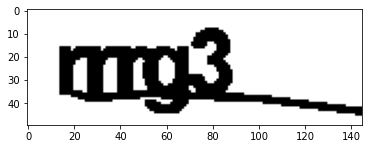

Original label:yndkd     Predict label:xndkd


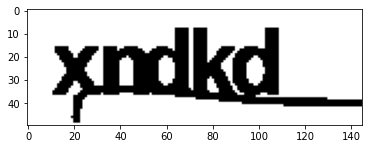

Original label:creyb     Predict label:crebb


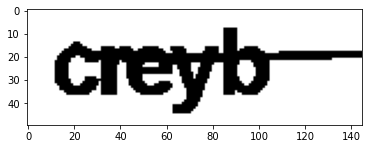

Original label:3rrnr     Predict label:3rmrd


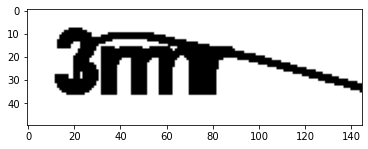

Original label:ymga2     Predict label:ymng2


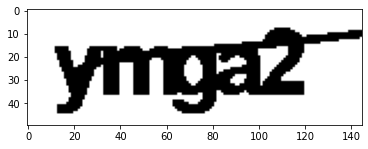

Original label:wgc6m     Predict label:wggcm


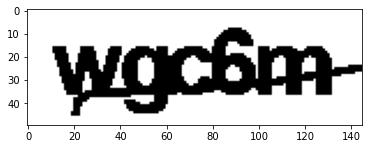

Original label:7wbnb     Predict label:7whnb


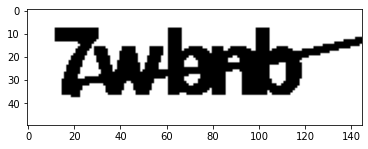

Original label:7r8gy     Predict label:7r8yy


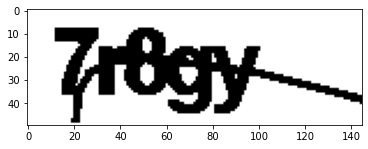

Original label:7w4rk     Predict label:7w44k


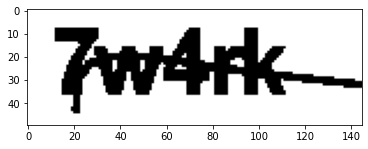

Total accuracy: 0.8558


In [299]:
count_3 = 0
for i in range(300):
    if Y_test_flatten_3[i*5] != Y_pred_flatten_3[i*5] or\
       Y_test_flatten_3[i*5+1] != Y_pred_flatten_3[i*5+1] or\
       Y_test_flatten_3[i*5+2] != Y_pred_flatten_3[i*5+2] or\
       Y_test_flatten_3[i*5+3] != Y_pred_flatten_3[i*5+3] or\
       Y_test_flatten_3[i*5+4] != Y_pred_flatten_3[i*5+4]:
        print("Original label:" +LETTERSTR[Y_test_flatten_3[i*5]]+
                                 LETTERSTR[Y_test_flatten_3[i*5+1]]+
                                 LETTERSTR[Y_test_flatten_3[i*5+2]]+
                                 LETTERSTR[Y_test_flatten_3[i*5+3]]+
                                 LETTERSTR[Y_test_flatten_3[i*5+4]], end='')
        print("     Predict label:" +LETTERSTR[Y_pred_flatten_3[i*5]]+
                                     LETTERSTR[Y_pred_flatten_3[i*5+1]]+
                                     LETTERSTR[Y_pred_flatten_3[i*5+2]]+
                                     LETTERSTR[Y_pred_flatten_3[i*5+3]]+
                                     LETTERSTR[Y_pred_flatten_3[i*5+4]])
        wrong_pic = (X_test[i].astype(np.float32))*255
        plt.imshow(wrong_pic, cmap='gray', vmin=0, vmax=255)
        plt.show()
        count_3 += 1

print("Total accuracy: %.4f" % float((520-count_3)/520))

總體test accuracy為85.58%  
test accuracy表現相當不錯，已經有一定的水準，並且比first_model accuracy 67.37%高了不少

### 儲存third_model

In [309]:
third_model.save('./model/third_model.h5', 
            overwrite=True,
            include_optimizer=True,
            save_format='h5')

## <font color="#0000dd">third_model結論</font>
原本我就猜想在深度學習中只training dataset只有1200筆(960筆training、240筆validatoin)資料應該不夠，後來觀察first_model及third_model的結果，就可以得知在CNN中這樣的資料量確實不夠，再將資料變更多有顯著提升model表現的效果。若將總data數再從2600調到更高，model表現可能還會再提升。

---

## <font color="#0000dd">結果與討論</font>
1. test accuracy

model        |first_model | second_model |  third_model
------------ |----------- | ------------ | ------
test accuracy|67.63%      | 27.00%       | 85.58%

2. 從confusion matrix可以看出，predict錯誤較多的有：
   1. r被predict為n
   2. r被predict為m
   3. n被predict成m
   
   可以看出以上三者並不是本來就長得很像，而是原data前後字母相連導致判斷錯誤  
   <center>e.g.,  actual label：hmrrg，    third_model predict：hmnrg</center>
   <img src="./report_pic/hmrrg.png"  width="290" height="100">
   若要有效解決這個問題，方法應該是做資料處理時，就將每個字元切割開來，input及output就會是一個一個獨立的字母，而不是一次丟五個字母進去。但同時也是因為字母相連，所以要寫演算法讓它好好的一個一個字元分離也是相當困難，在這邊我並沒有成功實作出來
3. 從first_model及second_model可以觀察出並不是trainable weight越多越好，還是要配合好的架構才能有好的效果。之所以second_model會比first_model差這麼多，我推測原因為在second_model前兩層Conv2D layer的kernel_size設太小，導致一開始就丟掉太多資訊
4. third_model及first_model架構相同，多一點dataset就可以大幅提升accuracy，這代表原本的data數量遠小於這個架構實際需要的data數。若將總data數再從2600調到更高，model表現可能還會再提升
5. CNN圖形識別能力確實不錯，但與其它深度學習一樣，它所需training資料量滿大的